In [9]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd
import os
import re 
import sys 
import importlib
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	RobustScaler,
)
from sklearn.preprocessing import (
	PowerTransformer, 
	QuantileTransformer
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_validate
sklearn.set_config(enable_metadata_routing=False)
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from xgboost import XGBClassifier, XGBRegressor
import time 
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import pearsonr
import plotly.express as px
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error

import shap
shap.initjs()

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd()))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data', )

# Add project root to sys.path for script usage
sys.path.append(project_root)

# Import and reload (optional) custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import variables 
from scripts import feature_selection as fs
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(variables)
importlib.reload(fs)


################ DEFINE column variables from data ###################
from scripts.variables import id_columns, baseline_cols, weekly_cols, all_cols, daily_cols_v1, daily_cols_v2
from scripts.variables import phq2_cols, phq9_cols

# Define label variables
df_names = ['v1_day', 'v2_day', 'v1_week', 'v2_week']
aggregate_dfs = ['alldays_df','week_df']
# Update endings list if order changes


import warnings
warnings.filterwarnings(
	"ignore",
	message="Skipping features without any observed values",
	category=UserWarning,
	module="sklearn.impute._base"
)


# Defining the transformations
yj_pipeline = Pipeline(steps=[
	('impute', SimpleImputer(strategy='mean')),
	('power', PowerTransformer(method='yeo-johnson')),
	('scale', StandardScaler()),
])

bc_pipeline = Pipeline(steps=[
	('impute', SimpleImputer(strategy='mean')),
	('power', PowerTransformer(method='yeo-johnson')),
	('scale', StandardScaler()),
])

categorical_pipeline = Pipeline(steps=[
	('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
	('impute', SimpleImputer(strategy='median')),
])

ordinal_pipeline = Pipeline(steps=[
	('impute', SimpleImputer(strategy='median')),
])

non_skewed_pipeline = Pipeline(steps=[
	('impute', SimpleImputer(strategy='mean')),
	('scale', StandardScaler())
])

target_pipeline = Pipeline(steps=[
	('scale', StandardScaler())
])

########################################## MODELS #######################################


# Models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
# Dummy baseline model
class GroupMeanRegressor(BaseEstimator, RegressorMixin):
	def fit(self, X, y, groups):
		self.group_means_ = y.groupby(groups.squeeze()).mean().squeeze()
		self.global_mean_ = y.mean().squeeze()
		return self
	
	def predict(self, X, groups):
		return groups.squeeze().map(self.group_means_).fillna(self.global_mean_).values

# Pearson scorer
def pearsonr_scorer(y_true, y_pred):
	return pearsonr(y_true, y_pred)[0]

models = {
	'Random Forest': RandomForestRegressor(random_state=42),
	'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
	'Hist Gradient Boost': HistGradientBoostingRegressor(),
	'Group Mean': GroupMeanRegressor(),
	'Ridge': Ridge(alpha=1.0)
}
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

def pearsonr_scorer(y_true, y_pred):
	return pearsonr(y_true, y_pred)[0]

scoring_metrics = {
	'r2': 'r2',
	'neg_mae': 'neg_mean_absolute_error',
	'neg_rmse': 'neg_root_mean_squared_error',
}



my pipeline: 
1. remove outliers
4. apply log transform to skewed or wide-tailed data
5. remove too-skewed data (?)
6. Impute
7. Scale
8. Drop columns with too few unique values or too little variance

In [ ]:
## Investigate kurtosis and skewedness
skewed_cols = {}
for name in df_names:
	skewed_cols[name] = {}
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval.csv'))
	print(f'\n\nFor {name}:')
	numeric_cols = [col for col in df.columns.to_list() if col in numeric_cols+baseline_cols+weekly_cols+phq9_cols+phq2_cols]
	non_bin_cols = [col for col in numeric_cols if '_bin' not in col and "_indicator" not in col and "_missing" not in col and "nonzero" not in col]
	
	skew_list = df[non_bin_cols].skew(numeric_only=True).sort_values(ascending=False) # sort by highest, display    
	if len(skew_list[skew_list > 1])>0:
		skewed_cols[name]['skew'] = skew_list[skew_list > 1].index
		print(f'Of {len(skew_list)} measures, {len(skew_list[skew_list > 1])} measures have skew > 1:')
		display(skew_list[skew_list > 1])

	# Calculate kurtosis for numeric columns
	kurtosis_vals = df[non_bin_cols].kurtosis(numeric_only=True)
	kurtosis_sorted = kurtosis_vals.sort_values(ascending=False) # Sort by highest kurtosis
	skewed_cols[name]['kurtosis'] = kurtosis_sorted[kurtosis_sorted > 2].index
	
	if len(kurtosis_sorted[kurtosis_sorted > 2])>0:
		print(f'Of {len(kurtosis_sorted)} measures, {len(kurtosis_sorted[kurtosis_sorted > 2])} measures have Kurtosis > 2:')
		display(kurtosis_sorted[kurtosis_sorted > 2]) #display

	if len(kurtosis_sorted[kurtosis_sorted.isna()])>0:
		print(f'{len(kurtosis_sorted[kurtosis_sorted.isna()])} columns have NaN in Kurtosis:')
		display(kurtosis_sorted[kurtosis_sorted.isna()]) #display

	# More investigation into kurtosis NaN values
	for col in kurtosis_sorted[kurtosis_sorted.isna()].index:
		print(f'Kurtosis is NaN for {col}:')
		if col in df.columns:
			print('Unique values:', df[col].nunique())      # Unique values
			print("Missing values:", df[col].isna().sum())   # Missing values
			print("Variance:", df[col].var())     # Summary stats



For v1_day:
Of 64 measures, 15 measures have skew > 1:


device            6.669650
screen_4          5.358306
screen_1          4.382990
heard_about_us    2.970104
phq9_9            2.336415
screen_2          2.244308
phq9_8            2.013592
phq9_9_base       2.009691
screen_3          1.823606
alc_2             1.760357
mhs_3             1.713952
alc_3             1.643072
gender            1.258190
mhs_2             1.244183
mhs_4             1.004248
dtype: float64

Of 64 measures, 11 measures have Kurtosis > 2:


device            42.943429
screen_4          26.957553
screen_1          17.369149
mhs_3              9.139820
heard_about_us     8.117782
phq9_9             5.016952
phq9_9_base        3.951344
phq9_8             3.684197
alc_2              3.130578
screen_2           3.064825
alc_3              2.373983
dtype: float64

1 columns have NaN in Kurtosis:


cid   NaN
dtype: float64

Kurtosis is NaN for cid:
Unique values: 0
Missing values: 15630
Variance: nan


For v2_day:
Of 63 measures, 17 measures have skew > 1:


screen_4          4.051370
screen_3          2.583803
mhs_3             2.544314
phq9_9_base       2.196688
heard_about_us    1.883902
screen_2          1.867589
phq9_9            1.533144
sds_1             1.366123
gender            1.285649
sds_3             1.269832
alc_2             1.182741
mhs_1             1.179541
mhs_2             1.152318
gad7_7            1.120397
mood_1            1.094948
phq9_8            1.051026
sds_2             1.036828
dtype: float64

Of 63 measures, 6 measures have Kurtosis > 2:


screen_4          15.259516
device             9.673000
mhs_3              7.014635
phq9_9_base        5.000476
screen_3           4.948195
heard_about_us     2.980474
dtype: float64



For v1_week:
Of 64 measures, 15 measures have skew > 1:


device            6.669650
screen_4          5.358306
screen_1          4.382990
heard_about_us    2.970104
phq9_9            2.336415
screen_2          2.244308
phq9_8            2.013592
phq9_9_base       2.009691
screen_3          1.823606
alc_2             1.760357
mhs_3             1.713952
alc_3             1.643072
gender            1.258190
mhs_2             1.244183
mhs_4             1.004248
dtype: float64

Of 64 measures, 11 measures have Kurtosis > 2:


device            42.943429
screen_4          26.957553
screen_1          17.369149
mhs_3              9.139820
heard_about_us     8.117782
phq9_9             5.016952
phq9_9_base        3.951344
phq9_8             3.684197
alc_2              3.130578
screen_2           3.064825
alc_3              2.373983
dtype: float64

1 columns have NaN in Kurtosis:


cid   NaN
dtype: float64

Kurtosis is NaN for cid:
Unique values: 0
Missing values: 15630
Variance: nan


For v2_week:
Of 63 measures, 17 measures have skew > 1:


screen_4          4.051370
screen_3          2.583803
mhs_3             2.544314
phq9_9_base       2.196688
heard_about_us    1.883902
screen_2          1.867589
phq9_9            1.533144
sds_1             1.366123
gender            1.285649
sds_3             1.269832
alc_2             1.182741
mhs_1             1.179541
mhs_2             1.152318
gad7_7            1.120397
mood_1            1.094948
phq9_8            1.051026
sds_2             1.036828
dtype: float64

Of 63 measures, 6 measures have Kurtosis > 2:


screen_4          15.259516
device             9.673000
mhs_3              7.014635
phq9_9_base        5.000476
screen_3           4.948195
heard_about_us     2.980474
dtype: float64

# Do preprocessing column transformer on long data before making it wide

In [149]:
from scripts.variables import id_columns
from scripts.variables import all_cols, all_daily_cols, weekly_cols, baseline_cols, drop_weekly_cols
from scripts.variables import daily_cols_v1, daily_v2_sensor_hr, daily_v2_weather, daily_cols_v2 
from scripts.variables import gad_cols, phq9_base, alc_cols, phq9_cols, phq2_cols, sleep_cols, gic_cols, sds_cols


target_columns = phq2_cols + phq9_cols
to_categorical = ['race','gender', 'education', 'income_satisfaction','incomelastyear', 'marital_status', 'season', 'cohort']
ordinal_columns = gad_cols + phq9_base + alc_cols + sleep_cols + gic_cols + sds_cols

box_cox_columns = ['mobility','mobility_radius']
yeo_johnson_columns = [col for col in skewed_cols[name]['skew'].to_list()+skewed_cols[name]['kurtosis'].to_list() if col not in box_cox_columns+target_columns+to_categorical+id_columns+ordinal_columns+baseline_cols]
non_skewed_columns = [col for col in all_daily_cols if col not in box_cox_columns+target_columns+to_categorical+yeo_johnson_columns+ordinal_columns+id_columns]

print(f'Target columns: {target_columns}')

print(f'Box cox columns: {box_cox_columns}')

print(f'yeo_johnson_columns: {yeo_johnson_columns}')

print(f'Ordinal columns: {ordinal_columns}')

print(f'Non-skewed columns: {non_skewed_columns}')

print(f'Target cols: {target_columns}')

print(f'Remainder: {[col for col in all_cols if col not in to_categorical+ordinal_columns+box_cox_columns+yeo_johnson_columns+non_skewed_columns+target_columns]}')



Target columns: ['phq2_1', 'phq2_2', 'phq2_sum', 'phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9', 'phq9_sum', 'phq9_bin', 'phq9_cat']
Box cox columns: ['mobility', 'mobility_radius']
yeo_johnson_columns: []
Ordinal columns: ['gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'gad_cat', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base', 'phq9_sum_base', 'alc_1', 'alc_2', 'alc_3', 'alc_sum', 'alc_cat', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support']
Non-skewed columns: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'sms_count', 'sms_length', 'unreturned_calls', 'distance_walking', 'hours_active', 'distance_active', 'came_to_work', 'distance_powered_vehicle', 'hours_high_speed_transportation', 'hours_of_sleep', 'distance_hig

In [ ]:

for name in df_names:
	print(f"\n=== Processing: {name} ===")
	fname = f'{name}_trainval.csv'
	df = pd.read_csv(os.path.join(brighten_dir, fname), low_memory=False)
	print('id columns originally:', [col for col in df.columns if col in id_columns])

	# Column transformer
	cat_cols = [item for item in df.columns if any(term in item for term in to_categorical)]
	yj_cols = [item for item in df.columns if any(term in item for term in yeo_johnson_columns)]
	bc_cols = [item for item in df.columns if any(term in item for term in box_cox_columns)]
	non_skewed_cols = [item for item in df.columns if any(term in item for term in non_skewed_columns)]
	ordinal_cols = [col for col in df.columns if any(term in col for term in ordinal_columns)]
	target_cols = [col for col in df.columns if any(term in col for term in target_columns)]

	print(f'yeo_johnson_columns: {yj_cols}')
	print(f'Ordinal columns: {ordinal_cols}')
	print(f'Non-skewed columns: {[item for item in df_transformed.columns if any(term in item for term in non_skewed_columns)]}')
	print(f'Cat columns: {cat_cols}')

	display(df[cat_cols].head())

	preprocessing = ColumnTransformer(transformers=[
		('yj', yj_pipeline, yj_cols),
		('bc', bc_pipeline, bc_cols),
		('cat', categorical_pipeline, cat_cols),
		('non-skew', non_skewed_pipeline, non_skewed_cols),
		('ord', ordinal_pipeline, ordinal_cols),
		('target', target_pipeline, target_cols)
		], remainder='passthrough',
	).set_output(transform='pandas')

	df_transformed = preprocessing.fit_transform(df)
	id_columns_intact = [col for col in id_columns if f"remainder__{col}" in df_transformed.columns]
	print('id columns intact:', id_columns_intact)
	print(f'Remainder columns: {[item for item in df_transformed.columns if "remainder" in item]}')


	for col in id_columns_intact:
		df_transformed = df_transformed.rename(columns={f"remainder__{col}": col})
	
	df_transformed = df_transformed[id_columns_intact + [col for col in df_transformed.columns if col not in id_columns_intact]]

	df_transformed.to_csv(os.path.join(brighten_dir, f'{name}_trainval_transformed.csv'))
	display(df_transformed.head())
	print(f'Saved {name}_trainval_transformed.csv to brighten_dir')






=== Processing: v1_day ===
id columns originally: ['dt', 'v', 'day', 'cohort', 'num_id', 'idx', 'day_of_week', 'season', 'week', 'week_id']
yeo_johnson_columns: []
Ordinal columns: ['alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base']
Non-skewed columns: ['non-skew__cloud_cover_IQR', 'non-skew__cloud_cover_mean', 'non-skew__cloud_cover_median', 'non-skew__cloud_cover_std', 'non-skew__dew_point_IQR', 'non-skew__dew_point_mean', 'non-skew__dew_point_median', 'non-skew__dew_point_std', 'non-skew__humidity_IQR', 'non-skew__humidity_mean', 'non-skew__humidity_median', 'non-skew__humidity_std', 'non-skew__precip_sum', 'non-skew__temp_IQR', 'non-skew__temp_mean', 'non-skew__temp_median', 'non-s

cohort  gender  education  income_satisfaction  marital_status  race  season
0    NaN     1.0        2.0                  3.0             0.0   2.0  summer
1    NaN     NaN        NaN                  NaN             NaN   NaN  summer
2    PST     NaN        NaN                  NaN             NaN   NaN  summer
3    PST     NaN        NaN                  NaN             NaN   NaN  summer
4    PST     NaN        NaN                  NaN             NaN   NaN  summer

id columns intact: ['num_id', 'dt', 'week', 'day', 'week_id', 'idx', 'v', 'day_of_week']
Remainder columns: ['remainder__Unnamed: 0.1', 'remainder__Unnamed: 0', 'remainder__dt', 'remainder__participant_id', 'remainder__v', 'remainder__day', 'remainder__mhs_1', 'remainder__mhs_2', 'remainder__mhs_3', 'remainder__mhs_4', 'remainder__mhs_5', 'remainder__user_phone_type', 'remainder__hours_accounted_for', 'remainder__hours_stationary', 'remainder__hours_stationary_nhw', 'remainder__hours_walking', 'remainder__cid', 'remainder__category', 'remainder__subcategories', 'remainder__study', 'remainder__screen_1', 'remainder__screen_2', 'remainder__screen_3', 'remainder__screen_4', 'remainder__working', 'remainder__income_lastyear', 'remainder__age', 'remainder__heard_about_us', 'remainder__device', 'remainder__study_arm', 'remainder__num_id', 'remainder__idx', 'remainder__day_of_week', 'remainder__month', 'remainder__week', 'remainder__week_id', 'remainder__phq2_indicator']


num_id          dt  week  day week_id    idx   v  day_of_week  \
0     1.0  2014-07-31     0    0   1.0_0  1.0_0  V1            4   
1     1.0  2014-08-01     0    1   1.0_0  1.0_1  V1            5   
2     1.0  2014-08-02     0    2   1.0_0  1.0_2  V1            6   
3     1.0  2014-08-03     0    3   1.0_0  1.0_3  V1            7   
4     1.0  2014-08-04     0    4   1.0_0  1.0_4  V1            1   

   bc__mobility  bc__mobility_radius  ...  remainder__screen_3  \
0      0.216809             0.633800  ...                  NaN   
1      0.216809             0.633800  ...                  0.0   
2      3.160733            -0.170236  ...                  NaN   
3      2.641419            -0.224768  ...                  NaN   
4      3.001668             1.167708  ...                  NaN   

   remainder__screen_4  remainder__working  remainder__income_lastyear  \
0                  NaN                 0.0                         6.0   
1                  0.0                 NaN                         NaN   
2                  NaN                 NaN                         NaN   
3                  NaN                 NaN                         NaN   
4                  NaN                 NaN                         NaN   

   remainder__age  remainder__heard_about_us  remainder__device  \
0            30.0                        6.0                0.0   
1             NaN                        NaN                NaN   
2             NaN                        NaN                NaN   
3             NaN                        NaN                NaN   
4             NaN                        NaN                NaN   

   remainder__study_arm  remainder__month  remainder__phq2_indicator  
0                   2.0                 7                          1  
1                   NaN                 8                          1  
2                   NaN                 8                          1  
3                   NaN                 8                          1  
4                   NaN                 8                          1  

[5 rows x 142 columns]

Saved v1_day_trainval_transformed.csv to brighten_dir

=== Processing: v2_day ===
id columns originally: ['dt', 'v', 'day', 'cohort', 'num_id', 'idx', 'day_of_week', 'season', 'week', 'week_id']
yeo_johnson_columns: []
Ordinal columns: ['alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base']
Non-skewed columns: ['non-skew__aggregate_communication', 'non-skew__call_count', 'non-skew__call_duration', 'non-skew__interaction_diversity', 'non-skew__missed_interactions', 'non-skew__sms_count', 'non-skew__sms_length', 'non-skew__unreturned_calls', 'non-skew__aggregate_communication_indicator', 'non-skew__call_count_indicator', 'non-skew__call_duration_indicator', 'non-skew__interaction_diversity_in

cohort  gender  education  income_satisfaction  marital_status  race  \
0     NaN     1.0        4.0                  2.0             1.0   6.0   
1     NaN     NaN        NaN                  NaN             NaN   NaN   
2     NaN     NaN        NaN                  NaN             NaN   NaN   
3     NaN     NaN        NaN                  NaN             NaN   NaN   
4     NaN     NaN        NaN                  NaN             NaN   NaN   

   season  
0  summer  
1  summer  
2  summer  
3  summer  
4  summer

id columns intact: ['num_id', 'dt', 'week', 'day', 'week_id', 'idx', 'v', 'day_of_week']
Remainder columns: ['remainder__Unnamed: 0.1', 'remainder__Unnamed: 0', 'remainder__dt', 'remainder__participant_id', 'remainder__v', 'remainder__day', 'remainder__mhs_1', 'remainder__mhs_2', 'remainder__mhs_3', 'remainder__mhs_4', 'remainder__mhs_5', 'remainder__user_phone_type', 'remainder__hours_accounted_for', 'remainder__hours_stationary', 'remainder__hours_stationary_nhw', 'remainder__hours_walking', 'remainder__cid', 'remainder__category', 'remainder__subcategories', 'remainder__study', 'remainder__screen_1', 'remainder__screen_2', 'remainder__screen_3', 'remainder__screen_4', 'remainder__working', 'remainder__income_lastyear', 'remainder__age', 'remainder__heard_about_us', 'remainder__device', 'remainder__study_arm', 'remainder__num_id', 'remainder__idx', 'remainder__day_of_week', 'remainder__month', 'remainder__week', 'remainder__week_id', 'remainder__phq2_indicator']


num_id          dt  week  day  week_id      idx   v  day_of_week  \
0   213.0  2016-08-12     0    0  213.0_0  213.0_0  V2            5   
1   213.0  2016-08-13     0    1  213.0_0  213.0_1  V2            6   
2   213.0  2016-08-14     0    2  213.0_0  213.0_2  V2            7   
3   213.0  2016-08-15     0    3  213.0_0  213.0_3  V2            1   
4   213.0  2016-08-16     0    4  213.0_0  213.0_4  V2            2   

   cat__cohort_nan  cat__gender_0.0  ...  remainder__screen_3  \
0              1.0              0.0  ...                  NaN   
1              1.0              0.0  ...                  NaN   
2              1.0              0.0  ...                  NaN   
3              1.0              0.0  ...                  NaN   
4              1.0              0.0  ...                  NaN   

   remainder__screen_4  remainder__working  remainder__income_lastyear  \
0                  NaN                 1.0                         0.0   
1                  NaN                 NaN                         NaN   
2                  NaN                 NaN                         NaN   
3                  NaN                 NaN                         NaN   
4                  NaN                 NaN                         NaN   

   remainder__age  remainder__heard_about_us  remainder__device  \
0            35.0                        3.0                1.0   
1             NaN                        NaN                NaN   
2             NaN                        NaN                NaN   
3             NaN                        NaN                NaN   
4             NaN                        NaN                NaN   

   remainder__study_arm  remainder__month  remainder__phq2_indicator  
0                   2.0                 8                          1  
1                   NaN                 8                          1  
2                   NaN                 8                          1  
3                   NaN                 8                          1  
4                   NaN                 8                          1  

[5 rows x 217 columns]

Saved v2_day_trainval_transformed.csv to brighten_dir

=== Processing: v1_week ===
id columns originally: ['idx', 'dt', 'v', 'day', 'cohort', 'num_id', 'day_of_week', 'season', 'week', 'week_id']
yeo_johnson_columns: []
Ordinal columns: ['alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base']
Non-skewed columns: ['non-skew__cloud_cover_IQR', 'non-skew__cloud_cover_mean', 'non-skew__cloud_cover_median', 'non-skew__cloud_cover_std', 'non-skew__dew_point_IQR', 'non-skew__dew_point_mean', 'non-skew__dew_point_median', 'non-skew__dew_point_std', 'non-skew__humidity_IQR', 'non-skew__humidity_mean', 'non-skew__humidity_median', 'non-skew__humidity_std', 'non-skew__precip_sum', 'non-skew__temp_IQR',

cohort  gender  education  income_satisfaction  marital_status  race  season
0    NaN     1.0        2.0                  3.0             0.0   2.0  summer
1    NaN     NaN        NaN                  NaN             NaN   NaN  summer
2    PST     NaN        NaN                  NaN             NaN   NaN  summer
3    PST     NaN        NaN                  NaN             NaN   NaN  summer
4    PST     NaN        NaN                  NaN             NaN   NaN  summer

id columns intact: ['num_id', 'dt', 'week', 'day', 'week_id', 'idx', 'v', 'day_of_week']
Remainder columns: ['remainder__Unnamed: 0.1', 'remainder__Unnamed: 0', 'remainder__idx', 'remainder__dt', 'remainder__participant_id', 'remainder__v', 'remainder__day', 'remainder__mhs_1', 'remainder__mhs_2', 'remainder__mhs_3', 'remainder__mhs_4', 'remainder__mhs_5', 'remainder__user_phone_type', 'remainder__hours_accounted_for', 'remainder__hours_stationary', 'remainder__hours_stationary_nhw', 'remainder__hours_walking', 'remainder__cid', 'remainder__category', 'remainder__subcategories', 'remainder__study', 'remainder__screen_1', 'remainder__screen_2', 'remainder__screen_3', 'remainder__screen_4', 'remainder__working', 'remainder__income_lastyear', 'remainder__age', 'remainder__heard_about_us', 'remainder__device', 'remainder__study_arm', 'remainder__num_id', 'remainder__day_of_week', 'remainder__month', 'remainder__week', 'remainder__week_id', 'remainder__phq2_indicator']


num_id          dt  week   day week_id     idx   v  day_of_week  \
0     1.0  2014-07-31   0.0   0.0   1.0_0   1.0_0  V1          4.0   
1     1.0  2014-08-01   0.0   1.0   1.0_0   1.0_1  V1          5.0   
2     1.0  2014-08-10   1.0  10.0   1.0_1  1.0_10  V1          7.0   
3     1.0  2014-08-11   1.0  11.0   1.0_1  1.0_11  V1          1.0   
4     1.0  2014-08-12   1.0  12.0   1.0_1  1.0_12  V1          2.0   

   bc__mobility  bc__mobility_radius  ...  remainder__screen_3  \
0      0.216809             0.633800  ...                  NaN   
1      0.216809             0.633800  ...                  0.0   
2      3.322954             0.668671  ...                  NaN   
3      2.469223            -0.646175  ...                  NaN   
4     -0.353453            -0.829968  ...                  NaN   

   remainder__screen_4  remainder__working  remainder__income_lastyear  \
0                  NaN                 0.0                         6.0   
1                  0.0                 NaN                         NaN   
2                  NaN                 NaN                         NaN   
3                  NaN                 NaN                         NaN   
4                  NaN                 NaN                         NaN   

   remainder__age  remainder__heard_about_us  remainder__device  \
0            30.0                        6.0                0.0   
1             NaN                        NaN                NaN   
2             NaN                        NaN                NaN   
3             NaN                        NaN                NaN   
4             NaN                        NaN                NaN   

   remainder__study_arm  remainder__month  remainder__phq2_indicator  
0                   2.0               7.0                          1  
1                   NaN               8.0                          1  
2                   NaN               8.0                          1  
3                   NaN               8.0                          1  
4                   NaN               8.0                          1  

[5 rows x 142 columns]

Saved v1_week_trainval_transformed.csv to brighten_dir

=== Processing: v2_week ===
id columns originally: ['idx', 'dt', 'v', 'day', 'cohort', 'num_id', 'day_of_week', 'season', 'week', 'week_id']
yeo_johnson_columns: []
Ordinal columns: ['alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'sds_1', 'sds_2', 'sds_3', 'stress', 'support', 'sleep_1', 'sleep_2', 'sleep_3', 'mood_1', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base']
Non-skewed columns: ['non-skew__aggregate_communication', 'non-skew__call_count', 'non-skew__call_duration', 'non-skew__interaction_diversity', 'non-skew__missed_interactions', 'non-skew__sms_count', 'non-skew__sms_length', 'non-skew__unreturned_calls', 'non-skew__aggregate_communication_indicator', 'non-skew__call_count_indicator', 'non-skew__call_duration_indicator', 'non-skew__interaction_diversity_

cohort  gender  education  income_satisfaction  marital_status  race season
0     NaN     0.0        3.0                  2.0             0.0   3.0   fall
1     NaN     NaN        NaN                  NaN             NaN   NaN   fall
2     NaN     NaN        NaN                  NaN             NaN   NaN   fall
3     NaN     NaN        NaN                  NaN             NaN   NaN   fall
4     NaN     NaN        NaN                  NaN             NaN   NaN   fall

id columns intact: ['num_id', 'dt', 'week', 'day', 'week_id', 'idx', 'v', 'day_of_week']
Remainder columns: ['remainder__Unnamed: 0.1', 'remainder__Unnamed: 0', 'remainder__idx', 'remainder__dt', 'remainder__participant_id', 'remainder__v', 'remainder__day', 'remainder__mhs_1', 'remainder__mhs_2', 'remainder__mhs_3', 'remainder__mhs_4', 'remainder__mhs_5', 'remainder__user_phone_type', 'remainder__hours_accounted_for', 'remainder__hours_stationary', 'remainder__hours_stationary_nhw', 'remainder__hours_walking', 'remainder__cid', 'remainder__category', 'remainder__subcategories', 'remainder__study', 'remainder__screen_1', 'remainder__screen_2', 'remainder__screen_3', 'remainder__screen_4', 'remainder__working', 'remainder__income_lastyear', 'remainder__age', 'remainder__heard_about_us', 'remainder__device', 'remainder__study_arm', 'remainder__num_id', 'remainder__day_of_week', 'remainder__month', 'remainder__week', 'remainder__week_id', 'remainder__phq2_indicator']


num_id          dt  week   day   week_id        idx   v  day_of_week  \
0  1001.0  2016-10-21   0.0   0.0  1001.0_0   1001.0_0  V2          5.0   
1  1001.0  2016-10-31   1.0  10.0  1001.0_1  1001.0_10  V2          1.0   
2  1001.0  2016-11-01   1.0  11.0  1001.0_1  1001.0_11  V2          2.0   
3  1001.0  2016-11-02   1.0  12.0  1001.0_1  1001.0_12  V2          3.0   
4  1001.0  2016-11-03   1.0  13.0  1001.0_1  1001.0_13  V2          4.0   

   cat__cohort_nan  cat__gender_0.0  ...  remainder__screen_3  \
0              1.0              1.0  ...                  NaN   
1              1.0              0.0  ...                  NaN   
2              1.0              0.0  ...                  NaN   
3              1.0              0.0  ...                  NaN   
4              1.0              0.0  ...                  NaN   

   remainder__screen_4  remainder__working  remainder__income_lastyear  \
0                  NaN                 1.0                         1.0   
1                  NaN                 NaN                         NaN   
2                  NaN                 NaN                         NaN   
3                  NaN                 NaN                         NaN   
4                  NaN                 NaN                         NaN   

   remainder__age  remainder__heard_about_us  remainder__device  \
0             6.0                        1.0                1.0   
1             NaN                        NaN                NaN   
2             NaN                        NaN                NaN   
3             NaN                        NaN                NaN   
4             NaN                        NaN                NaN   

   remainder__study_arm  remainder__month  remainder__phq2_indicator  
0                   3.0              10.0                          1  
1                   NaN              10.0                          0  
2                   NaN              11.0                          0  
3                   NaN              11.0                          1  
4                   NaN              11.0                          1  

[5 rows x 217 columns]

Saved v2_week_trainval_transformed.csv to brighten_dir


In [ ]:
## Investigate kurtosis and skewedness
skewed_cols = {}
for name in df_names:
	skewed_cols[name] = {}
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval_transformed.csv'))
	print(f'\n\nFor {name}:')
	numeric_cols = [col for col in df.columns.to_list() if col in all_daily_cols+baseline_cols+weekly_cols+phq9_cols+phq2_cols]
	non_bin_cols = [col for col in numeric_cols if '_bin' not in col and "_indicator" not in col and "_missing" not in col and "nonzero" not in col]
	
	skew_list = df[non_bin_cols].skew(numeric_only=True).sort_values(ascending=False) # sort by highest, display    
	if len(skew_list[skew_list > 1])>0:
		skewed_cols[name]['skew'] = skew_list[skew_list > 1]
		print(f'Of {len(skew_list)} measures, {len(skew_list[skew_list > 1])} measures have skew > 1:')
		print(skew_list[skew_list > 1])

	# Calculate kurtosis for numeric columns
	kurtosis_vals = df[non_bin_cols].kurtosis(numeric_only=True)
	kurtosis_sorted = kurtosis_vals.sort_values(ascending=False) # Sort by highest kurtosis
	skewed_cols[name]['kurtosis'] = kurtosis_sorted[kurtosis_sorted > 2]
	if len(kurtosis_sorted[kurtosis_sorted > 2])>0:
		print(f'Of {len(kurtosis_sorted)} measures, {len(kurtosis_sorted[kurtosis_sorted > 2])} measures have Kurtosis > 2:')
		print(kurtosis_sorted[kurtosis_sorted > 2]) #display

	if len(kurtosis_sorted[kurtosis_sorted.isna()])>0:
		print(f'{len(kurtosis_sorted[kurtosis_sorted.isna()])} columns have NaN in Kurtosis:')
		print(kurtosis_sorted[kurtosis_sorted.isna()]) #display

	# More investigation into kurtosis NaN values
	for col in kurtosis_sorted[kurtosis_sorted.isna()].index:
		print(f'Kurtosis is NaN for {col}:')
		if col in df.columns:
			print('Unique values:', df[col].nunique())      # Unique values
			print("Missing values:", df[col].isna().sum())   # Missing values
			print("Variance:", df[col].var())     # Summary stats



For v1_day:


For v2_day:


For v1_week:


For v2_week:


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_34485/2859442161.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda g: g.ffill().bfill().infer_objects(copy=False))


Saved v1_day_trainval_transformed_baseFilled.csv


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_34485/2859442161.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda g: g.ffill().bfill().infer_objects(copy=False))


Saved v2_day_trainval_transformed_baseFilled.csv


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_34485/2859442161.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda g: g.ffill().bfill().infer_objects(copy=False))


Saved v1_week_trainval_transformed_baseFilled.csv


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_34485/2859442161.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda g: g.ffill().bfill().infer_objects(copy=False))


Saved v2_week_trainval_transformed_baseFilled.csv


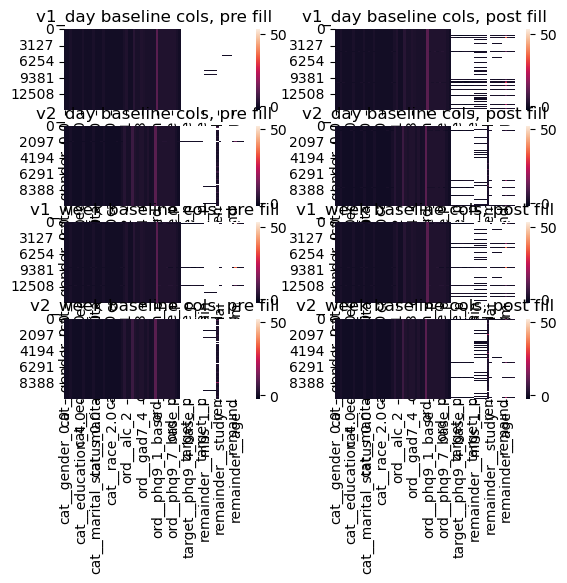

In [10]:
fig, axes = plt.subplots(nrows=len(df_names), ncols=2)

for i, name in enumerate(df_names):
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval_transformed.csv'))
	baseline_cols_present = [col for col in df.columns if any(item in col for item in baseline_cols)]

	# --- Create a numeric copy just for visualization ---
	df_viz = df[baseline_cols_present].copy()
	for col in df_viz.columns:
		if not pd.api.types.is_numeric_dtype(df_viz[col]):
			unique_vals = df_viz[col].dropna().unique()
			mapping = {val: idx + 1 for idx, val in enumerate(unique_vals)}
			df_viz[col] = df_viz[col].map(mapping)

	sns.heatmap(df_viz, ax=axes[i, 0])
	axes[i, 0].set_title(f'{name} baseline cols, pre fill')

	# --- Fill step ---
	df[baseline_cols_present] = (
		df.groupby("week_id")[baseline_cols_present]
		.apply(lambda g: g.ffill().bfill().infer_objects(copy=False))
		.reset_index(drop=True)
	)

	# --- Numeric again for post-fill visualization ---
	df_viz_filled = df[baseline_cols_present].copy()
	for col in df_viz_filled.columns:
		if not pd.api.types.is_numeric_dtype(df_viz_filled[col]):
			unique_vals = df_viz_filled[col].dropna().unique()
			mapping = {val: idx + 1 for idx, val in enumerate(unique_vals)}
			df_viz_filled[col] = df_viz_filled[col].map(mapping)

	sns.heatmap(df_viz_filled, ax=axes[i, 1])
	axes[i, 1].set_title(f'{name} baseline cols, post fill')

	# --- Save the filled original (not the numeric version) ---
	df.to_csv(os.path.join(brighten_dir, f'{name}_trainval_transformed_baseFilled.csv'), index=False)
	print(f'Saved {name}_trainval_transformed_baseFilled.csv')

plt.show()

['Unnamed: 0', 'num_id', 'dt', 'week', 'day', 'week_id', 'idx', 'v', 'day_of_week', 'bc__mobility', 'bc__mobility_radius', 'bc__mobility_indicator', 'bc__mobility_radius_indicator', 'cat__cohort_Akili', 'cat__cohort_Health tips', 'cat__cohort_PST', 'cat__cohort_nan', 'cat__gender_0.0', 'cat__gender_1.0', 'cat__gender_nan', 'cat__education_0.0', 'cat__education_2.0', 'cat__education_3.0', 'cat__education_4.0', 'cat__education_nan', 'cat__income_satisfaction_0.0', 'cat__income_satisfaction_1.0', 'cat__income_satisfaction_3.0', 'cat__income_satisfaction_nan', 'cat__marital_status_0.0', 'cat__marital_status_1.0', 'cat__marital_status_2.0', 'cat__marital_status_nan', 'cat__race_0.0', 'cat__race_1.0', 'cat__race_2.0', 'cat__race_3.0', 'cat__race_4.0', 'cat__race_5.0', 'cat__race_6.0', 'cat__race_nan', 'cat__season_fall', 'cat__season_spring', 'cat__season_summer', 'cat__season_winter', 'non-skew__aggregate_communication', 'non-skew__call_count', 'non-skew__call_duration', 'non-skew__interact

Saved v1_day_trainval_transformed_weekFilled.csv
Saved v2_day_trainval_transformed_weekFilled.csv
Saved v1_week_trainval_transformed_weekFilled.csv
Saved v2_week_trainval_transformed_weekFilled.csv


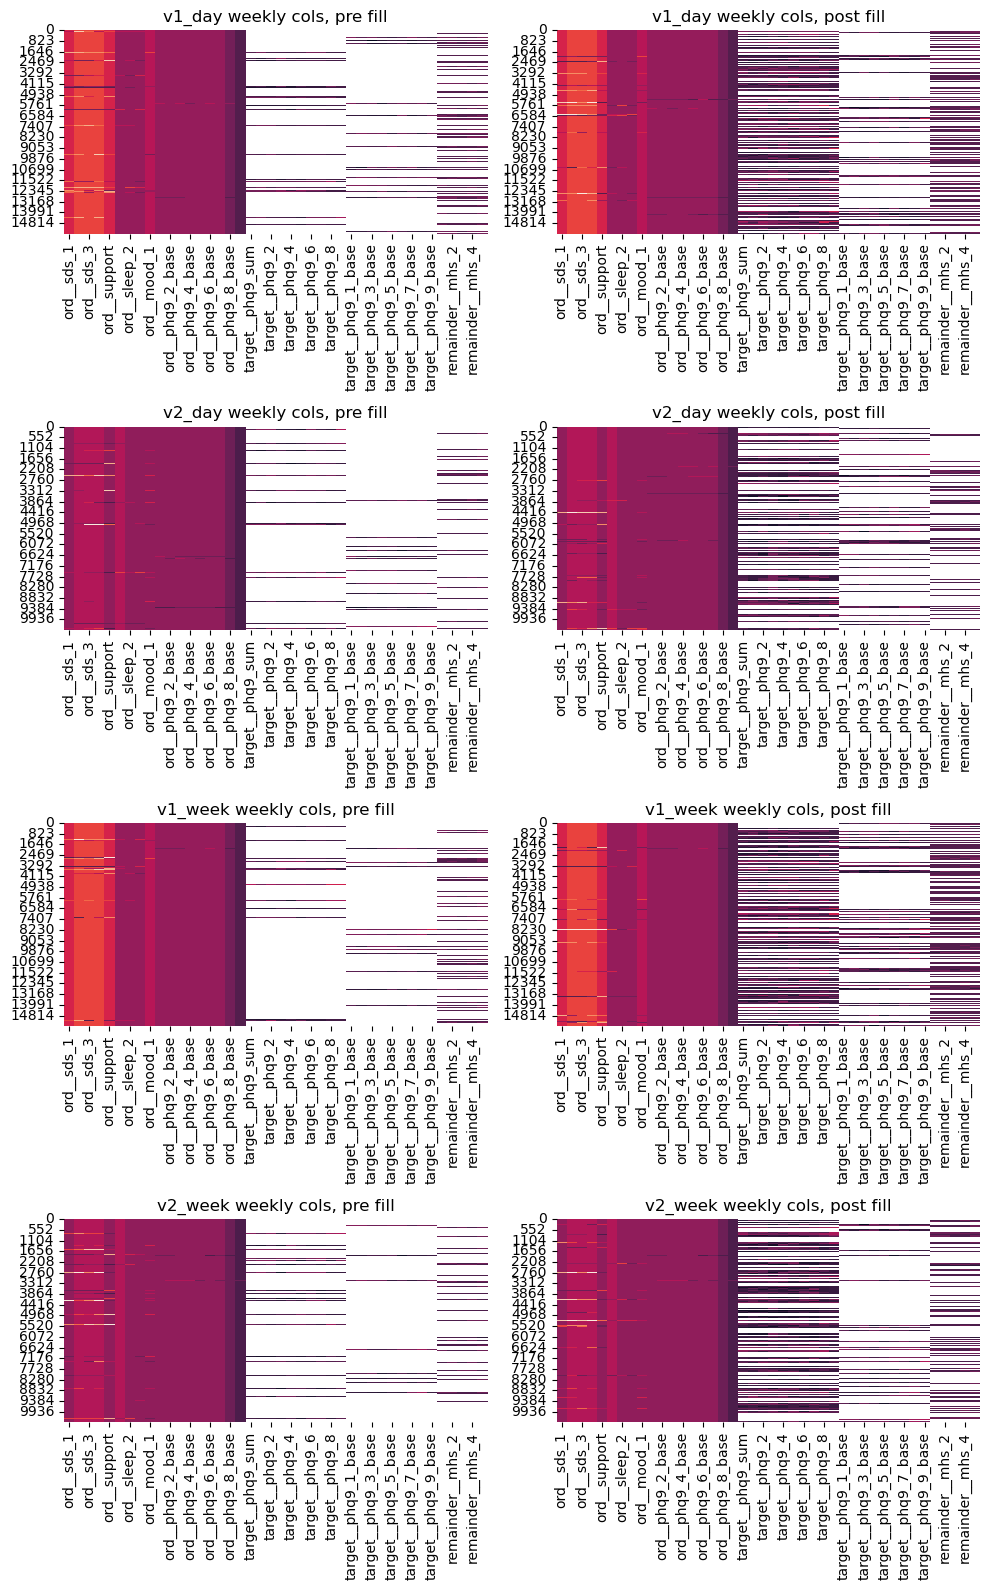

In [11]:
# # BFill and FFill the weekly_cols by week
fig, axes = plt.subplots(nrows=len(df_names), ncols=2, figsize=(10, 4 * len(df_names)))

# If len(df_names) == 1, make sure axes is 2D
if len(df_names) == 1:
    axes = np.array([axes])

for i, name in enumerate(df_names):
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval_transformed_baseFilled.csv'))
    weekly_cols_present = [col for col in df.columns if any(item in col for item in weekly_cols)]

    sns.heatmap(df[weekly_cols_present], ax=axes[i, 0], cbar=False)
    axes[i, 0].set_title(f'{name} weekly cols, pre fill')

    df[weekly_cols_present] = (
        df.groupby("week_id")[weekly_cols_present]
        .apply(lambda g: g.ffill().bfill())
        .reset_index(drop=True)
    )

    sns.heatmap(df[weekly_cols_present], ax=axes[i, 1], cbar=False)
    axes[i, 1].set_title(f'{name} weekly cols, post fill')

    df.to_csv(os.path.join(brighten_dir, f'{name}_trainval_transformed_weekFilled.csv'), index=False)
    print(f'Saved {name}_trainval_transformed_weekFilled.csv')

plt.tight_layout()
plt.show()	

In [28]:
# Add season
seasons = {
	'fall': [9, 10, 11],
	'winter': [12, 1, 2],
	'spring': [3, 4, 5],
	'summer': [6, 7, 8]
}

# Assign season labels (strings)
for i, name in enumerate(df_names):
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_Xy_8wks_long_trainval.csv'))
	print('entries',len(df))
	print('cols',len(df.columns.to_list()))
	# if 'remainder__season' in df.columns:
	# 	# Encode seasons numerically
	# 	season_mapping = {season: i + 1 for i, season in enumerate(seasons.keys())}
	# 	df['remainder__season'] = df['remainder__season'].map(season_mapping)
	# 	df.to_csv(os.path.join(brighten_dir, f'{name}_Xy_8wks_long_trainval.csv'))



entries 16218
cols 129
entries 10313
cols 312
entries 16218
cols 129
entries 10313
cols 312


In [ ]:

# y_cols =['change_cat','change_sum','change_binary','phq9_mean','phq9_cat_mean'] 
y_cols_regex = 'phq9'
models = {
	'HistGradientBoostingRegressor': [HistGradientBoostingRegressor(), HistGradientBoostingClassifier()]
}
model_dict = {}



for name in ['v1_day','v2_day','v1_week','v2_week']:
	model_dict[name] = {}
	print(f'####### {name} #######')
	for y_col in ['target__phq9_1','target__phq9_2','target__phq9_3','target__phq9_4','target__phq9_6','target__phq9_5','target__phq9_7']:
		model_dict[name][y_col] = {}
		Xy=pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval_transformed_weekFilled.csv'))
		Xy=Xy.dropna(subset=[y_col]).drop(columns=['dt','week','day','idx','v'])
		Xy=Xy.select_dtypes(include=['int64','float64'])
		y=Xy[y_col]
		# print(Xy.columns.to_list())
		baseline_cols_present = matches = [item for item in Xy.columns if any(col in item for col in baseline_cols)]
		# print(baseline_cols_present)
		y_cols_present = [item for item in Xy.columns if any(col in item for col in y_cols_regex)]
		# print(y_cols_present)
		unnamed_present = [item for item in Xy.columns if 'Unnamed' in item]

		for type in ['baseline','8wks','both']:
			model_dict[name][y_col][type] = {}
			if 'baseline' in type:
				X1=Xy[['num_id']+baseline_cols_present].copy()
				X1=X1
			elif '8wks' in type:
				X1 = Xy.drop(columns=baseline_cols_present+y_cols_present+unnamed_present).copy()
			else:
				X1=Xy.drop(columns=y_cols_present+unnamed_present)
			
			# Inputs
			groups = Xy['num_id']
			gkf = GroupKFold(n_splits=5)
			X2 = X1.drop(columns='num_id').copy()  # drop group id from features for group KFold

			# print('models...')
			for model_name in models:
				model_dict[name][y_col][type][model_name] = {}
				model_dict[name][y_col][type][model_name]['model']=[]
				model_dict[name][y_col][type][model_name]['X_test']=[]
				model_dict[name][y_col][type][model_name]['r2_scores']=[]
				model_dict[name][y_col][type][model_name]['mae_scores']=[]
				for train_idx, test_idx in gkf.split(X2, y, groups):
					X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
					y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

					model = models[model_name][0]
					if y_col in ['change_cat','change_binary']:
						model= models[model_name][1]
					model.fit(X_train, y_train)
					model_dict[name][y_col][type][model_name]['model'].append(model)

					y_pred = np.round(model.predict(X_test)).astype(int) #ordinal Y
					model_dict[name][y_col][type][model_name]['X_test'].append(X_test)

					r2 = r2_score(y_test, y_pred)
					model_dict[name][y_col][type][model_name]['r2_scores'].append(r2)

					mae = mean_absolute_error(y_test, y_pred)
					model_dict[name][y_col][type][model_name]['mae_scores'].append(mae)
					

				print(f"{y_col} from {type} -- mean R²: {round(np.mean(model_dict[name][y_col][type][model_name]['r2_scores']), 4)}, mean MAE: {round(np.mean(model_dict[name][y_col][type][model_name]['mae_scores']), 4)} of scores [{round(y.min(), 1)}-{round(y.max(), 1)}]")
	
		if 'phq9_mean' in y_col:
			phq9_base_col = [col for col in Xy.columns if 'phq9_sum_base' in col]
			yy = pd.concat([Xy[phq9_base_col], y], axis=1)
			yy=yy.dropna()
			y_pred = yy[phq9_base_col]
			y_test=yy['phq9_mean']
			r2_base = r2_score(y_pred,y_test)
			print(f"{y_col} predicted from phq9_sum_baseline survey -- mean R²: {round(np.mean(r2_base), 4)}, mean MAE: {round(np.mean(model_dict[name][y_col][type][model_name]['mae_scores']), 4)} of scores [{round(y.min(), 1)}-{round(y.max(), 1)}]")
			model_dict[name]['baseline_phq9'] = {}
			model_dict[name]['baseline_phq9']['r2'] = r2_base
			
	

####### v1_day #######


In [ ]:
import gc 

for name in ['v1_day', 'v2_day', 'v1_week', 'v2_week']: #4
	for y_col in ['phq9_mean']: #2
		for type in ['8wks']: #3
			for model_name in models: #only one atm 
				mean_r2 = round(np.mean(model_dict[name][y_col][type][model_name]['r2_scores']), 3)
				print(name, type, model_name, f'Mean R2: {mean_r2}')
				i=0 #change based on which CV you want to see
				explainer = shap.Explainer(model_dict[name][y_col][type][model_name]['model'][i], approximate=True)
				shap_values = explainer(model_dict[name][y_col][type][model_name]['X_test'][i], check_additivity=False)
				shap.plots.bar(shap_values)
				del explainer, shap_values
				gc.collect()  
				
				#shap.summary_plot(shap_values, model_dict[name][y_col][type][model_name]['X_test'][i], show=False)


In [ ]:
## WIDE DF

# Define coverage and only keep subjects where they have >=threshold% of daily data over 12 weeks
coverage_threshold=0.5
filter_for_coverage = False
results=[]
for v in ['v1', 'v2']:
	for time in ['day', 'week']:
		print(f"\n=== Processing: {v} {time} ===")
		fname = f'{v}_{time}_Xy_long_trainval.csv'
		df = pd.read_csv(os.path.join(brighten_dir, fname), low_memory=False)

		df_filtered_byDay = df.loc[df['day']<56] # only keep 8weeks of data

		##### Create wide df of daily cols ######
		sensor_columns = daily_cols_v1 if v == 'v1' else daily_v2_sensor_hr + daily_v2_weather
		sensor_columns_present = [col for col in df_filtered_byDay.columns if any(term in col for term in sensor_columns)]

		dailySurvey_cols = phq2_cols + sensor_columns
		daily_cols_present = [col for col in df_filtered_byDay.columns if any(term in col for term in dailySurvey_cols)]
		#print(daily_cols_present)

		indicator_cols = [f'{col}_indicator' for col in sensor_columns]
		indicator_cols_present = [col for col in df_filtered_byDay.columns if any(term in col for term in indicator_cols)]

		# Only keep subjects where they have >=70% of daily data over 12 weeks
		if filter_for_coverage:
			grouped = df_filtered_byDay.groupby('num_id')[sensor_columns_present].apply(lambda x: x.notna().mean(axis=1).mean())
			keep_ids_days = grouped[grouped >= coverage_threshold].index
			df_filtered_bySub = df_filtered_byDay[df_filtered_byDay['num_id'].isin(keep_ids_days)]
			print(f'{df_filtered_byDay['num_id'].nunique()} subs before >{coverage_threshold} daily filtering, {df_filtered_bySub['num_id'].nunique()} subs after >{coverage_threshold} daily filtering,')
		else:
			df_filtered_bySub = df_filtered_byDay

		daily_df_wide = pd.DataFrame()
		for id in df_filtered_bySub['num_id'].unique():
			df_sub = df_filtered_bySub[df_filtered_bySub['num_id'] == id].copy()
			df_sub['day'] = df_sub['day'].astype(int)
			df_wide = df_sub.set_index(['day','num_id'])[daily_cols_present].unstack(level='day')
			df_wide.columns = [f"{col}_{day}" for col, day in df_wide.columns]
			df_wide = df_wide.reset_index()
			if df_wide.shape[0] > 1:
				print('df_wide')
				display(df_wide)
				df_wide_filled = df_wide.bfill().ffill().drop_duplicates()
				print('df_wide_filled')
				display(df_wide_filled)
			else:
				df_wide_filled = df_wide

			daily_df_wide = pd.concat([daily_df_wide, df_wide])

		
		assert daily_df_wide['num_id'].is_unique, "Duplicate num_id rows in daily_df_wide"


		##### Create wide df of weekly cols ######
		weekly_cols_present = [col for col in weekly_cols if col in df.columns]


		weekly_df_wide = pd.DataFrame()
		for id in df_filtered_byDay['num_id'].unique():
			df_sub = df_filtered_byDay[df_filtered_byDay['num_id'] == id].copy()
			df_sub['week'] = df_sub['week'].astype(int)
			df_agg = df_sub.groupby(['num_id', 'week'])[weekly_cols_present].mean()
			df_wide = df_agg.unstack(level='week')
			df_wide.columns = [f"{col}_week{week}" for col, week in df_wide.columns]
			df_wide = df_wide.reset_index()
			if df_wide.shape[0] > 1:
				df_wide_filled = df_wide.bfill().ffill().drop_duplicates()
			else:
				df_wide_filled=df_wide
			#present_drop_weekly_cols = [col for col in drop_weekly_cols if col in df_wide_filled.columns.to_list()]
			#df_wide_filled = df_wide_filled.drop(columns=present_drop_weekly_cols)
			#print('for sub', id, 'coverage:', df_wide_filled.columns.notna().sum()/df_wide_filled.shape[1])
			if filter_for_coverage:
				if df_wide_filled.notna().mean(axis=1)[0] > coverage_threshold:
					weekly_df_wide = pd.concat([weekly_df_wide, df_wide_filled])
			else:
				weekly_df_wide = pd.concat([weekly_df_wide, df_wide_filled])

		if filter_for_coverage:
			print(f'{df_filtered_byDay['num_id'].nunique()} subs before >{coverage_threshold} weekly filtering, {weekly_df_wide['num_id'].nunique()} subs after >{coverage_threshold} weekly filtering,')
		
		assert weekly_df_wide['num_id'].is_unique, "Duplicate num_id rows in weekly_df_wide"

		##### Create wide df of baseline cols ######
		baseline_cols_present = [col for col in df.columns if any(item in col for item in baseline_cols+['dt','num_id'])]
		df_base = df[baseline_cols_present]
		print(baseline_cols_present)
		df_subs_full=pd.DataFrame()
		df_subs = df_base.groupby('num_id')
		for sub, sub_df in df_subs:
			sub_df_filled = sub_df.bfill().ffill().infer_objects(copy=False).drop(columns='dt').drop_duplicates()
			if sub_df_filled.shape[0] > 1:
				for col in sub_df_filled.columns:
					if len(sub_df_filled[col].unique()) > 1:
						sub_df_filled[col] = sub_df_filled[col].unique()[0]
				sub_df_filled = sub_df_filled.drop_duplicates()
			if sub_df_filled.shape[0] > 1:
				raise ValueError("Multiple rows found for a subject in baseline that should be 1-row")
			
			df_subs_full = pd.concat([df_subs_full, sub_df_filled])
		# print('df_subs_full')
		# display(df_subs_full[['num_id']+[col for col in df_subs_full if col != 'num_id']])

		if filter_for_coverage:
			print(f'{df_subs_full['num_id'].nunique()} subs in df_subs_full, {weekly_df_wide['num_id'].nunique()} subs in weekly_df_wide, {daily_df_wide['num_id'].nunique()} subs in daily_df_wide')
		
		assert df_subs_full['num_id'].is_unique, "Duplicate num_id rows in df_subs_full"


		##### Combine base, weekly and daily ######
		df_combined = weekly_df_wide.merge(df_subs_full, on='num_id', how='left')
		df_combined = df_combined.merge(daily_df_wide, on='num_id', how='left')
		df_combined = df_combined.loc[:, ~df_combined.columns.astype(str).str.contains('^Unnamed')]
		print('df_combined shape:', df_combined.shape, 'df_combined subs:', df_combined['num_id'].nunique())
		assert df_combined['num_id'].is_unique, "Duplicate num_id rows in df_combined"
		

		df_combined.to_csv(os.path.join(brighten_dir, f'{v}_{time}_Xy_8wks_wide_trainval.csv'))


In [ ]:
for name in ['v1_day','v2_day','v1_week','v2_week']:
	if 'v1' in name:
		change_cat_df = pd.read_csv(os.path.join(brighten_dir, f'v1_day_phq9_cat_change.csv')) #change_cat
		change_sum_df = pd.read_csv(os.path.join(brighten_dir, f'v1_day_phq9_sum_change.csv')) #change_sum, change_binary
	elif 'v2' in name:
		change_cat_df = pd.read_csv(os.path.join(brighten_dir, f'v2_day_phq9_cat_change.csv')) #change_cat
		change_sum_df = pd.read_csv(os.path.join(brighten_dir, f'v2_day_phq9_sum_change.csv')) #change_sum, change_binary

	results=[]
	print(f"\n=== Processing: {name} ===")
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_8wks_wide_trainval.csv'))
	y_df_merged = df['num_id'].copy().drop_duplicates()

	sensor_columns = daily_cols_v1 if 'v1'in name else daily_v2_sensor_hr + daily_v2_weather
	sensor_columns_present = [item for item in df.columns if any(term in item for term in sensor_columns)]
	target_columns = phq9_cols 
	target_columns_present = [item for item in df.columns if any(term in item for term in target_columns) and 'base' not in item]
	drop_sensor_cols = [f"{col}_0" for col in sensor_columns]

	# Features and target
	for y_col in ['change_cat','change_sum','change_binary','phq9_mean','phq9_cat_mean']:
		if y_col in change_cat_df.columns:
			cat_ids = change_cat_df[['num_id', y_col]]
		elif y_col in change_sum_df.columns:
			cat_ids = change_sum_df[['num_id', y_col]]
		y_df_merged = pd.merge(y_df_merged, cat_ids, on='num_id', how='right')
	
	y_df_merged = y_df_merged[y_df_merged['num_id'].isin(df['num_id'])]
	print(f'there are {y_df_merged['num_id'].nunique()} subs in y_df_merged')
	y_df_merged.to_csv(os.path.join(brighten_dir, f'{name}_y_8wks_wide_trainval.csv'))

	
	print(f'Saved {name}_y_8wks_wide_trainval.csv')
	drop_cols = [col for col in drop_sensor_cols+target_columns_present if col in df.columns.to_list()]
	print(f'Dropping cols from X: {drop_cols}')
	X = df.drop(columns=drop_cols).copy()
	print(f'there are {X['num_id'].nunique()} subs in X')
	X.to_csv(os.path.join(brighten_dir, f'{name}_X_8wks_wide_trainval.csv'))
	print(f'Saved {name}_X_8wks_wide_trainval.csv')

	Xy = pd.merge(y_df_merged, X, on='num_id', how='outer')
	print(f'there are {Xy['num_id'].nunique()} subs in Xy')
	display(Xy)
	Xy.to_csv(os.path.join(brighten_dir, f'{name}_Xy_8wks_wide_trainval.csv'))

		



=== Processing: v1_day ===
there are 173 subs in y_df_merged
Saved v1_day_y_8wks_wide_trainval.csv
Dropping cols from X: []
there are 231 subs in X
Saved v1_day_X_8wks_wide_trainval.csv
there are 231 subs in Xy


num_id  change_cat  change_sum  change_binary  phq9_mean  phq9_cat_mean  \
0       2.0         NaN         NaN            NaN        NaN            NaN   
1       3.0         NaN         NaN            NaN        NaN            NaN   
2       4.0         NaN         NaN            NaN        NaN            NaN   
3       6.0         NaN         NaN            NaN        NaN            NaN   
4       7.0         NaN         NaN            NaN        NaN            NaN   
..      ...         ...         ...            ...        ...            ...   
226  2070.0         NaN         NaN            NaN        NaN            NaN   
227  2071.0         0.0        -3.0            0.0   3.428571       0.428571   
228  2074.0         NaN         NaN            NaN        NaN            NaN   
229  2087.0         NaN         NaN            NaN        NaN            NaN   
230  2107.0         NaN         NaN            NaN        NaN            NaN   

     Unnamed: 0  yj__alc_2  yj__alc_3  yj__phq9_8_base  ...  \
0             0   0.038711   0.030891         0.011764  ...   
1             1   0.038711   0.030891         0.011764  ...   
2             2   0.038711   0.030891         0.011764  ...   
3             3   0.038711   0.030891         0.011764  ...   
4             4   0.038711   0.030891         0.011764  ...   
..          ...        ...        ...              ...  ...   
226         226   0.038711   0.030891        -9.862875  ...   
227         227   0.038711   0.030891        -9.862875  ...   
228         228   0.038711   0.030891         1.244266  ...   
229         229   0.038711   0.030891         0.011764  ...   
230         230   0.038711   0.030891         0.011764  ...   

     remainder__phq2_sum_46  remainder__phq2_sum_47  remainder__phq2_sum_48  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     NaN   
4                       NaN                     NaN                     NaN   
..                      ...                     ...                     ...   
226                     NaN                     NaN                     NaN   
227                     2.0                     2.0                     2.0   
228                     NaN                     NaN                     NaN   
229                     NaN                     NaN                     NaN   
230                     NaN                     NaN                     NaN   

     remainder__phq2_sum_49  remainder__phq2_sum_50  remainder__phq2_sum_51  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     NaN   
4                       NaN                     NaN                     NaN   
..                      ...                     ...                     ...   
226                     NaN                     NaN                     NaN   
227                     2.0                     7.0                     2.0   
228                     NaN                     NaN                     NaN   
229                     NaN                     NaN                     NaN   
230                     NaN                     NaN                     NaN   

     remainder__phq2_sum_52  remainder__phq2_sum_53  remainder__phq2_sum_54  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     N


=== Processing: v2_day ===
there are 111 subs in y_df_merged
Saved v2_day_y_8wks_wide_trainval.csv
Dropping cols from X: []
there are 185 subs in X
Saved v2_day_X_8wks_wide_trainval.csv
there are 185 subs in Xy


num_id  change_cat  change_sum  change_binary  phq9_mean  phq9_cat_mean  \
0     208.0         NaN         NaN            NaN        NaN            NaN   
1     216.0        -1.0        -7.0           -1.0   4.833333          0.500   
2     221.0         0.0        -4.0            0.0   8.625000          1.375   
3     222.0         NaN         NaN            NaN        NaN            NaN   
4     229.0         NaN         NaN            NaN        NaN            NaN   
..      ...         ...         ...            ...        ...            ...   
180  1120.0         NaN         NaN            NaN        NaN            NaN   
181  1142.0         NaN         NaN            NaN        NaN            NaN   
182  1163.0         0.0        -3.0            0.0  17.000000          3.000   
183  1168.0         NaN         NaN            NaN        NaN            NaN   
184  1178.0         0.0        -4.0            0.0  17.000000          3.000   

     Unnamed: 0  yj__alc_2  yj__alc_3  yj__phq9_8_base  ...  \
0             0   0.013342   0.013949        -8.205410  ...   
1             1   0.013342   0.013949         1.471014  ...   
2             2   0.013342   0.013949         8.666036  ...   
3             3   0.013342   0.013949         1.471014  ...   
4             4   0.013342   0.013949        -8.205410  ...   
..          ...        ...        ...              ...  ...   
180         180   0.013342   0.013949         1.471014  ...   
181         181   0.013342   0.013949        -8.205410  ...   
182         182   0.013342   0.013949         8.666036  ...   
183         183   0.013342   0.013949        -8.205410  ...   
184         184   0.013342   0.013949         8.666036  ...   

     remainder__location_variance_indicator_46  \
0                                          NaN   
1                                          0.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                                        0.0   
183                                        NaN   
184                                        0.0   

     remainder__location_variance_indicator_47  \
0                                          NaN   
1                                          1.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                                        0.0   
183                                        NaN   
184                                        0.0   

     remainder__location_variance_indicator_48  \
0                                          NaN   
1                                          0.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                                        0.0   
183                                        NaN   
184                                        0.0   

     remainder__location_variance_indicator_49  \
0                                          NaN   
1                                          0.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                               


=== Processing: v1_week ===
there are 173 subs in y_df_merged
Saved v1_week_y_8wks_wide_trainval.csv
Dropping cols from X: []
there are 231 subs in X
Saved v1_week_X_8wks_wide_trainval.csv
there are 231 subs in Xy


num_id  change_cat  change_sum  change_binary  phq9_mean  phq9_cat_mean  \
0       2.0         NaN         NaN            NaN        NaN            NaN   
1       3.0         NaN         NaN            NaN        NaN            NaN   
2       4.0         NaN         NaN            NaN        NaN            NaN   
3       6.0         NaN         NaN            NaN        NaN            NaN   
4       7.0         NaN         NaN            NaN        NaN            NaN   
..      ...         ...         ...            ...        ...            ...   
226  2070.0         NaN         NaN            NaN        NaN            NaN   
227  2071.0         0.0        -3.0            0.0   3.428571       0.428571   
228  2074.0         NaN         NaN            NaN        NaN            NaN   
229  2087.0         NaN         NaN            NaN        NaN            NaN   
230  2107.0         NaN         NaN            NaN        NaN            NaN   

     Unnamed: 0  yj__alc_2  yj__alc_3  yj__phq9_8_base  ...  \
0             0   0.038711   0.030891         0.011764  ...   
1             1   0.038711   0.030891         0.011764  ...   
2             2   0.038711   0.030891         0.011764  ...   
3             3   0.038711   0.030891         0.011764  ...   
4             4   0.038711   0.030891         0.011764  ...   
..          ...        ...        ...              ...  ...   
226         226   0.038711   0.030891        -9.862875  ...   
227         227   0.038711   0.030891        -9.862875  ...   
228         228   0.038711   0.030891         1.244266  ...   
229         229   0.038711   0.030891         0.011764  ...   
230         230   0.038711   0.030891         0.011764  ...   

     remainder__phq2_sum_46  remainder__phq2_sum_47  remainder__phq2_sum_48  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     NaN   
4                       NaN                     NaN                     NaN   
..                      ...                     ...                     ...   
226                     NaN                     NaN                     NaN   
227                     2.0                     2.0                     2.0   
228                     NaN                     NaN                     NaN   
229                     NaN                     NaN                     NaN   
230                     NaN                     NaN                     NaN   

     remainder__phq2_sum_49  remainder__phq2_sum_50  remainder__phq2_sum_51  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     NaN   
4                       NaN                     NaN                     NaN   
..                      ...                     ...                     ...   
226                     NaN                     NaN                     NaN   
227                     2.0                     7.0                     2.0   
228                     NaN                     NaN                     NaN   
229                     NaN                     NaN                     NaN   
230                     NaN                     NaN                     NaN   

     remainder__phq2_sum_52  remainder__phq2_sum_53  remainder__phq2_sum_54  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     N


=== Processing: v2_week ===
there are 111 subs in y_df_merged
Saved v2_week_y_8wks_wide_trainval.csv
Dropping cols from X: []
there are 185 subs in X
Saved v2_week_X_8wks_wide_trainval.csv
there are 185 subs in Xy


num_id  change_cat  change_sum  change_binary  phq9_mean  phq9_cat_mean  \
0     208.0         NaN         NaN            NaN        NaN            NaN   
1     216.0        -1.0        -7.0           -1.0   4.833333          0.500   
2     221.0         0.0        -4.0            0.0   8.625000          1.375   
3     222.0         NaN         NaN            NaN        NaN            NaN   
4     229.0         NaN         NaN            NaN        NaN            NaN   
..      ...         ...         ...            ...        ...            ...   
180  1120.0         NaN         NaN            NaN        NaN            NaN   
181  1142.0         NaN         NaN            NaN        NaN            NaN   
182  1163.0         0.0        -3.0            0.0  17.000000          3.000   
183  1168.0         NaN         NaN            NaN        NaN            NaN   
184  1178.0         0.0        -4.0            0.0  17.000000          3.000   

     Unnamed: 0  yj__alc_2  yj__alc_3  yj__phq9_8_base  ...  \
0             0   0.013342   0.013949        -8.205410  ...   
1             1   0.013342   0.013949         1.471014  ...   
2             2   0.013342   0.013949         8.666036  ...   
3             3   0.013342   0.013949         1.471014  ...   
4             4   0.013342   0.013949        -8.205410  ...   
..          ...        ...        ...              ...  ...   
180         180   0.013342   0.013949         1.471014  ...   
181         181   0.013342   0.013949        -8.205410  ...   
182         182   0.013342   0.013949         8.666036  ...   
183         183   0.013342   0.013949        -8.205410  ...   
184         184   0.013342   0.013949         8.666036  ...   

     remainder__location_variance_indicator_46  \
0                                          NaN   
1                                          0.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                                        0.0   
183                                        NaN   
184                                        0.0   

     remainder__location_variance_indicator_47  \
0                                          NaN   
1                                          1.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                                        0.0   
183                                        NaN   
184                                        0.0   

     remainder__location_variance_indicator_48  \
0                                          NaN   
1                                          0.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                                        0.0   
183                                        NaN   
184                                        0.0   

     remainder__location_variance_indicator_49  \
0                                          NaN   
1                                          0.0   
2                                          0.0   
3                                          NaN   
4                                          0.0   
..                                         ...   
180                                        0.0   
181                                        NaN   
182                               

In [ ]:
# Correlated features
correlated={}
for name in ['v1_day','v2_day','v1_week','v2_week']:
	correlated[name]=[]
	X = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_8wks_wide_trainval.csv'))
	for i in range(0, len(X.columns)):
		if i < len(X.columns)-1:
			cols_df = X[[X.columns[i], X.columns[i+1]]]
			corr = cols_df.corr()
			if corr.iat[0,1] > 0.7:
				correlated[name].append((X.columns[i], X.columns[i+1]))

	correlated[name]=set(correlated[name])

for name in ['v1_day','v2_day','v1_week','v2_week']:
	X = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_8wks_wide_trainval.csv'))
	print(name, ', number correlated:', len(correlated[name]), ', total number of columns:', len(X.columns))





v1_day , number correlated: 246 , total number of columns: 1225
v2_day , number correlated: 493 , total number of columns: 3914
v1_week , number correlated: 246 , total number of columns: 1225
v2_week , number correlated: 493 , total number of columns: 3914


## trying HistGradientBoosting on my data


In [30]:

y_cols =['change_cat','change_sum','change_binary','phq9_mean','phq9_cat_mean'] 
models = {
	'HistGradientBoostingRegressor': [HistGradientBoostingRegressor(), HistGradientBoostingClassifier()]
}
model_dict = {}

for name in ['v1_day','v2_day','v1_week','v2_week']:
	model_dict[name] = {}
	print(f'####### {name} #######')
	for y_col in ['phq9_mean','phq9_cat_mean']:
		model_dict[name][y_col] = {}
		Xy=pd.read_csv(os.path.join(brighten_dir, f'{name}_Xy_8wks_wide_trainval.csv'))
		Xy=Xy.dropna(subset=[y_col])
		y=Xy[y_col]
		# print(Xy.columns.to_list())
		baseline_cols_present = matches = [item for item in Xy.columns if any(col in item for col in baseline_cols)]
		# print(baseline_cols_present)
		y_cols_present = [item for item in Xy.columns if any(col in item for col in y_cols)]
		# print(y_cols_present)
		unnamed_present = [item for item in Xy.columns if 'Unnamed' in item]

		for type in ['baseline','8wks','both']:
			model_dict[name][y_col][type] = {}
			if 'baseline' in type:
				X1=Xy[['num_id']+baseline_cols_present].copy()
			elif '8wks' in type:
				X1 = Xy.drop(columns=baseline_cols_present+y_cols_present+unnamed_present).copy()
			else:
				X1=Xy.drop(columns=y_cols_present+unnamed_present)
			
			# Inputs
			groups = Xy['num_id']
			gkf = GroupKFold(n_splits=5)
			X2 = X1.drop(columns='num_id').copy()  # drop group id from features for group KFold

			# print('models...')
			for model_name in models:
				model_dict[name][y_col][type][model_name] = {}
				model_dict[name][y_col][type][model_name]['model']=[]
				model_dict[name][y_col][type][model_name]['X_test']=[]
				model_dict[name][y_col][type][model_name]['r2_scores']=[]
				model_dict[name][y_col][type][model_name]['mae_scores']=[]
				for train_idx, test_idx in gkf.split(X2, y, groups):
					X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
					y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

					model = models[model_name][0]
					if y_col in ['change_cat','change_binary']:
						model= models[model_name][1]
					model.fit(X_train, y_train)
					model_dict[name][y_col][type][model_name]['model'].append(model)

					y_pred = np.round(model.predict(X_test)).astype(int) #ordinal Y
					model_dict[name][y_col][type][model_name]['X_test'].append(X_test)

					r2 = r2_score(y_test, y_pred)
					model_dict[name][y_col][type][model_name]['r2_scores'].append(r2)

					mae = mean_absolute_error(y_test, y_pred)
					model_dict[name][y_col][type][model_name]['mae_scores'].append(mae)
					

				print(f"{y_col} from {type} -- mean R²: {round(np.mean(model_dict[name][y_col][type][model_name]['r2_scores']), 4)}, mean MAE: {round(np.mean(model_dict[name][y_col][type][model_name]['mae_scores']), 4)} of scores [{round(y.min(), 1)}-{round(y.max(), 1)}]")
	
		if 'phq9_mean' in y_col:
			phq9_base_col = [col for col in Xy.columns if 'phq9_sum_base' in col]
			yy = pd.concat([Xy[phq9_base_col], y], axis=1)
			yy=yy.dropna()
			y_pred = yy[phq9_base_col]
			y_test=yy['phq9_mean']
			r2_base = r2_score(y_pred,y_test)
			print(f"{y_col} predicted from phq9_sum_baseline survey -- mean R²: {round(np.mean(r2_base), 4)}, mean MAE: {round(np.mean(model_dict[name][y_col][type][model_name]['mae_scores']), 4)} of scores [{round(y.min(), 1)}-{round(y.max(), 1)}]")
			model_dict[name]['baseline_phq9'] = {}
			model_dict[name]['baseline_phq9']['r2'] = r2_base
			
	

####### v1_day #######
phq9_mean from baseline -- mean R²: 0.133, mean MAE: 3.3184 of scores [0.0-24.0]
phq9_mean from 8wks -- mean R²: 0.4184, mean MAE: 2.8224 of scores [0.0-24.0]
phq9_mean from both -- mean R²: 0.4364, mean MAE: 2.7335 of scores [0.0-24.0]
phq9_mean predicted from phq9_sum_baseline survey -- mean R²: -32.0022, mean MAE: 2.7335 of scores [0.0-24.0]
phq9_cat_mean from baseline -- mean R²: 0.0188, mean MAE: 0.6905 of scores [0.0-4.0]
phq9_cat_mean from 8wks -- mean R²: 0.2069, mean MAE: 0.6421 of scores [0.0-4.0]
phq9_cat_mean from both -- mean R²: 0.2347, mean MAE: 0.5954 of scores [0.0-4.0]
####### v2_day #######
phq9_mean from baseline -- mean R²: 0.1042, mean MAE: 4.0954 of scores [3.0-26.7]
phq9_mean from 8wks -- mean R²: 0.1226, mean MAE: 4.1354 of scores [3.0-26.7]
phq9_mean from both -- mean R²: 0.1574, mean MAE: 4.0465 of scores [3.0-26.7]
phq9_mean predicted from phq9_sum_baseline survey -- mean R²: 0.0, mean MAE: 4.0465 of scores [3.0-26.7]
phq9_cat_mean fro

v1_day 8wks HistGradientBoostingRegressor Mean R2: 0.418


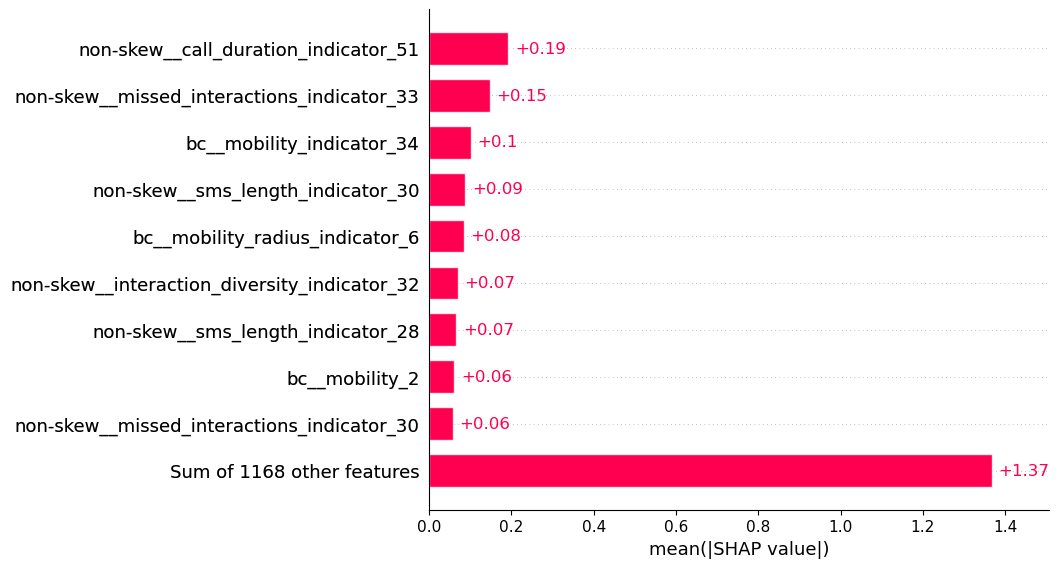

v2_day 8wks HistGradientBoostingRegressor Mean R2: 0.123


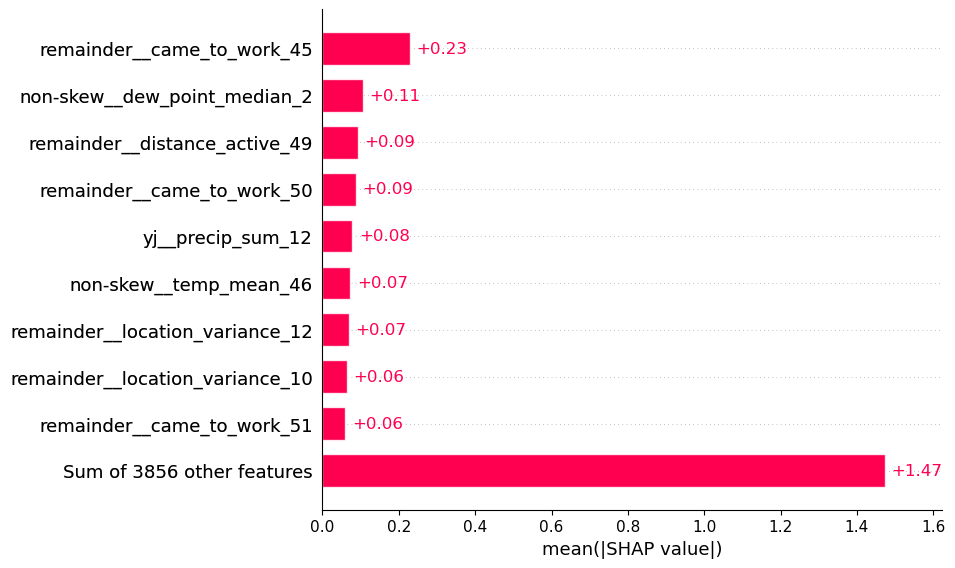

v1_week 8wks HistGradientBoostingRegressor Mean R2: 0.418


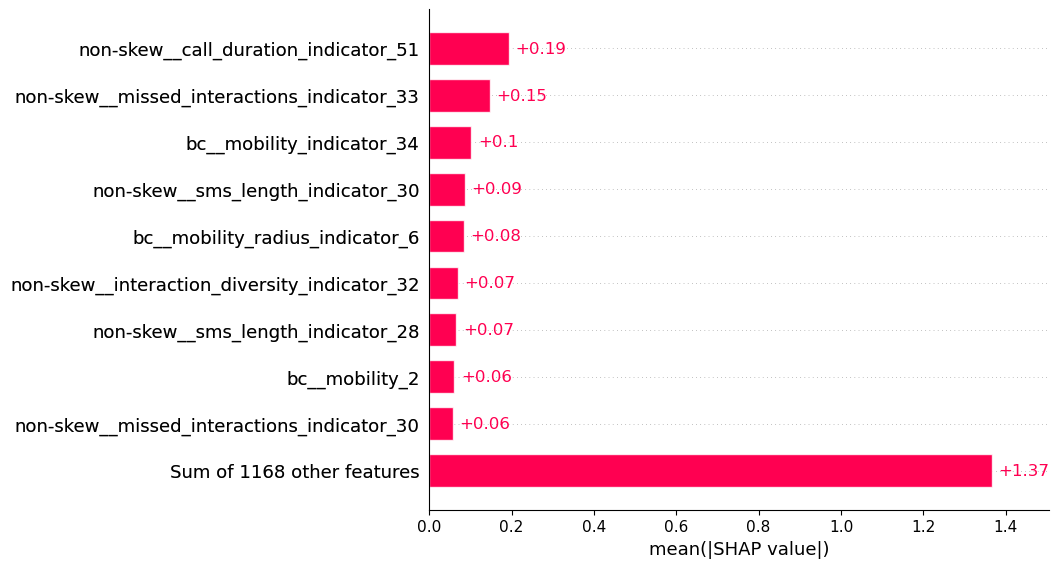

v2_week 8wks HistGradientBoostingRegressor Mean R2: 0.123


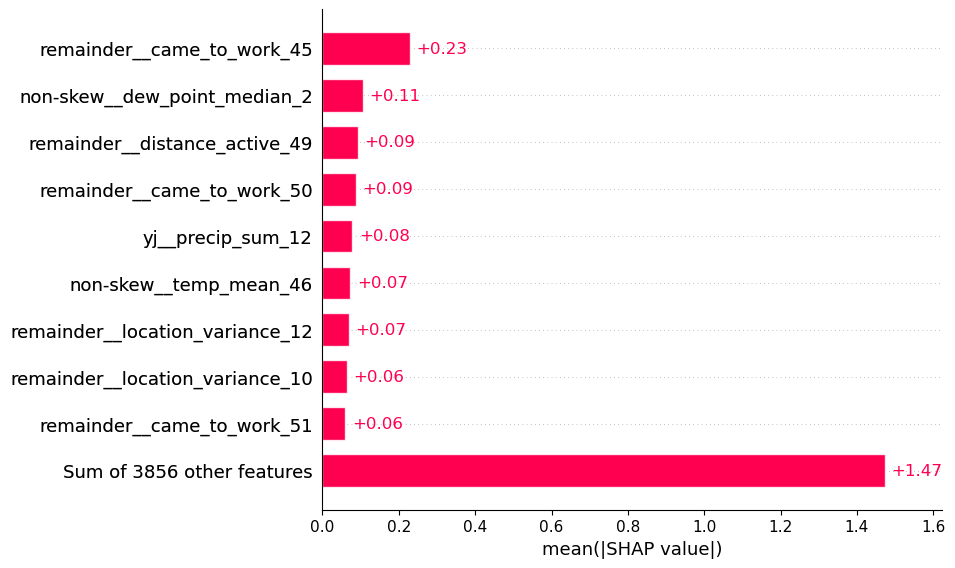

In [32]:
# SHAP Printing -- do after above, can't run without first making results {}
import gc 

for name in ['v1_day', 'v2_day', 'v1_week', 'v2_week']: #4
	for y_col in ['phq9_mean']: #2
		for type in ['8wks']: #3
			for model_name in models: #only one atm 
				mean_r2 = round(np.mean(model_dict[name][y_col][type][model_name]['r2_scores']), 3)
				print(name, type, model_name, f'Mean R2: {mean_r2}')
				i=0 #change based on which CV you want to see
				explainer = shap.Explainer(model_dict[name][y_col][type][model_name]['model'][i], approximate=True)
				shap_values = explainer(model_dict[name][y_col][type][model_name]['X_test'][i], check_additivity=False)
				shap.plots.bar(shap_values)
				del explainer, shap_values
				gc.collect()  
				
				#shap.summary_plot(shap_values, model_dict[name][y_col][type][model_name]['X_test'][i], show=False)


v1_day both HistGradientBoostingRegressor Mean R2: 0.436


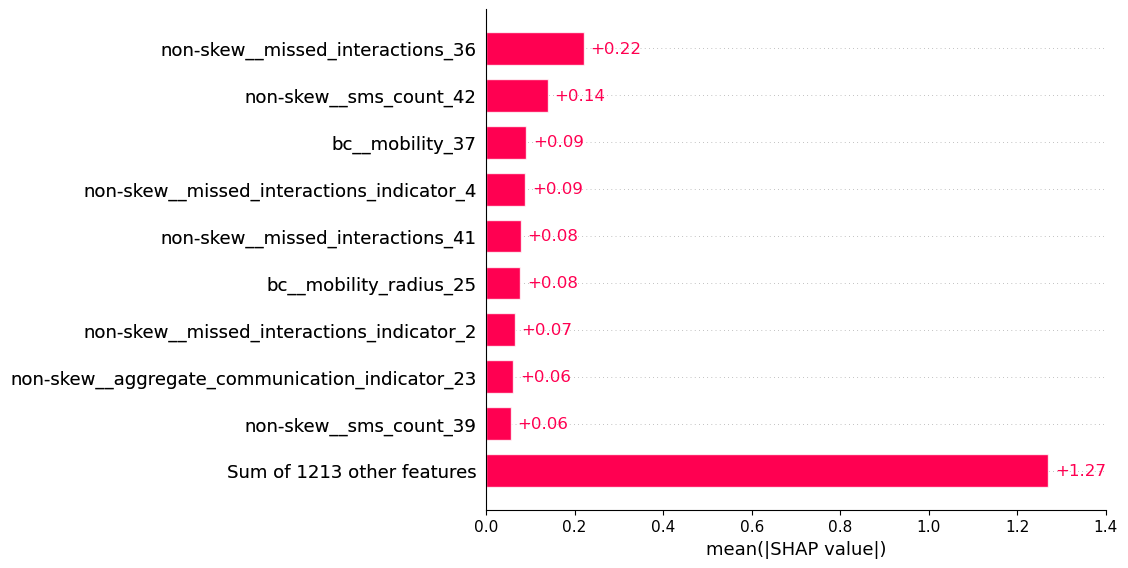

v2_day both HistGradientBoostingRegressor Mean R2: 0.157


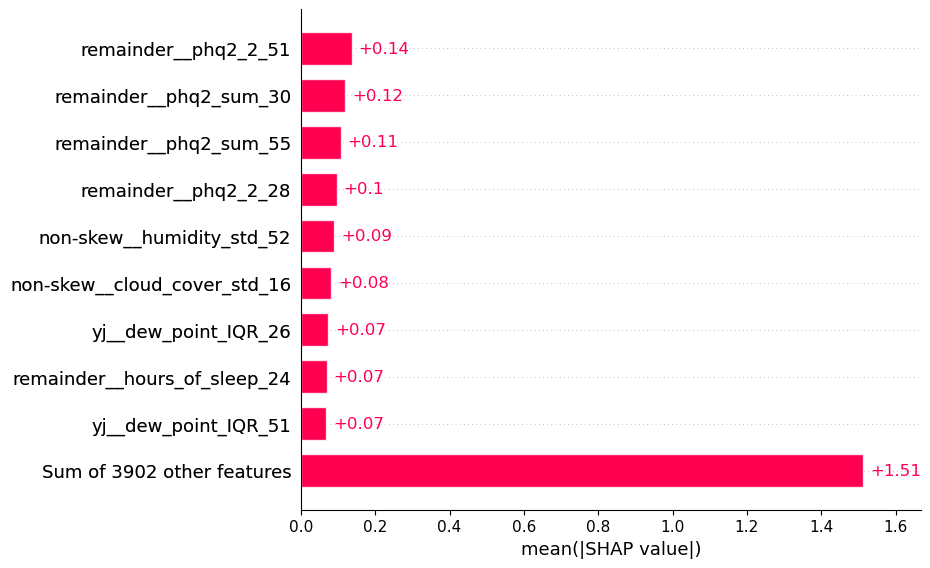

v1_week both HistGradientBoostingRegressor Mean R2: 0.436


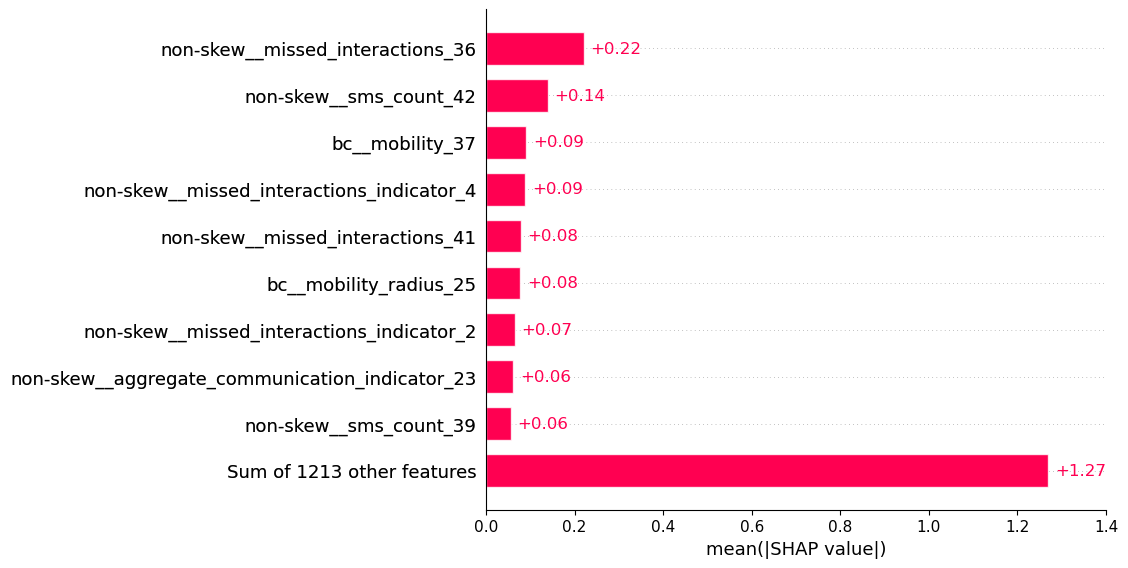

v2_week both HistGradientBoostingRegressor Mean R2: 0.157


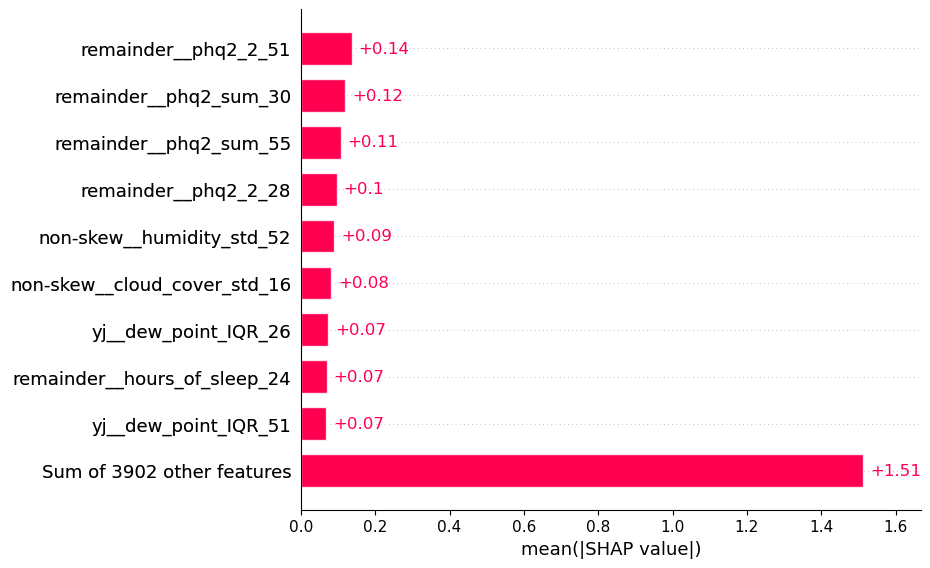

In [ ]:

for name in ['v1_day', 'v2_day', 'v1_week', 'v2_week']: #4
	for y_col in ['phq9_mean']: #2
		for type in ['both']: #3
			for model_name in models: #only one atm 
				mean_r2 = round(np.mean(model_dict[name][y_col][type][model_name]['r2_scores']), 3)
				print(name, type, model_name, f'Mean R2: {mean_r2}')
				i=0 #change based on which CV you want to see
				explainer = shap.Explainer(model_dict[name][y_col][type][model_name]['model'][i], approximate=True)
				shap_values = explainer(model_dict[name][y_col][type][model_name]['X_test'][i], check_additivity=False)
				shap.plots.bar(shap_values)
				del explainer, shap_values
				gc.collect()  

# Extract slope and intercept from each week of daily data


In [ ]:
from scipy import stats

slope_intercept_2wks = {}
for name in df_names:
	slope_intercept_2wks[name] = []
	print(f"\n=== Processing: {name} ===")
	fname = f'{name}_trainval_transformed_weekFilled.csv'

	df = pd.read_csv(os.path.join(brighten_dir, fname), low_memory=False)

	baseline_cols_present = [col for col in df.columns if any(item in col for item in baseline_cols+['dt','num_id'])]

	sensor_columns = daily_cols_v1 if 'v1' in name else daily_v2_sensor_hr + daily_v2_weather
	sensor_columns_present = [item for item in df.columns if any(term in item for term in sensor_columns) and 'indicator' not in item]

	target_columns = phq9_cols + phq2_cols #change to just phq9 if you want to add phq2
	target_columns_present = [item for item in df.columns if any(term in item for term in target_columns) and 'base' not in item]

	weekly_columns_present = [item for item in df.columns if any(term in item for term in weekly_cols) and 'base' not in item]
	
	for sub, sub_df in df.groupby('num_id'):
		last_day = sub_df['day'].max()
		num_2wk_blocks = int(round((last_day / 14), 0))
		# print('num_2wk_blocks',num_2wk_blocks)
		skipped={}
		for i in range(1, num_2wk_blocks+1):
			skipped[i]=[]
			block=sub_df[sub_df['day']>(i-1)*14]
			block=block[block['day']<i*14]
			# print(f'block from range {(i-1)*14} - {i*14}')
			# display(block)

			n_cols_present = len(sensor_columns_present+target_columns_present+weekly_columns_present)
			for col in sensor_columns_present+target_columns_present+weekly_columns_present:
				col_block = block[['day', col]].dropna()
				if col_block.shape[0] < 2:
					if col_block.shape[0] == 0:
						skipped[i].append(col)
						slope_intercept_2wks[name].append([sub, i, col, np.nan, np.nan, np.nan, np.nan, np.nan])
						continue
					else:
						mean = col_block[col].mean()
						slope_intercept_2wks[name].append([sub, i, col, np.nan, np.nan, np.nan, mean, np.nan])
						continue
				else:
					x = col_block['day']
					y = col_block[col]
					mean_value=col_block[col].mean()
					std = col_block[col].std()
					slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
					slope_intercept_2wks[name].append([sub, i, col, slope, intercept, p_value, mean_value, std])


			
			if len(skipped[i])>0:
				print(f'For sub {sub}, block {i} of {num_2wk_blocks}, skipped {len(skipped[i])} cols of {n_cols_present}: {skipped[i]}')
	
	slope_intercept_2wks_df = pd.DataFrame(slope_intercept_2wks[name], columns = ['num_id', '2week_block', 'col', 'slope', 'intercept', 'p_value','mean', 'std'])
	slope_intercept_2wks_df.to_csv(os.path.join(brighten_dir, f"{name}_long_slopeintercept_2wks.csv"))
	display(slope_intercept_2wks_df.head())







			



=== Processing: v1_day ===


FileNotFoundError: [Errno 2] No such file or directory: '/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/BRIGHTEN_data/v1_day_trainval_transformed_weekFilled.csv'

In [ ]:
from scipy import stats

slope_intercept_2wks4wks8wks = {}
for name in df_names:
	slope_intercept_2wks4wks8wks[name] = []
	print(f"\n=== Processing: {name} ===")
	fname = f'{name}_trainval_transformed.csv'
	df = pd.read_csv(os.path.join(brighten_dir, fname), low_memory=False)

	baseline_cols_present = [col for col in df.columns if any(item in col for item in baseline_cols+['dt','num_id'])]

	sensor_columns = daily_cols_v1 if 'v1' in name else daily_v2_sensor_hr + daily_v2_weather
	sensor_columns_present = [item for item in df.columns if any(term in item for term in sensor_columns) and 'indicator' not in item]

	target_columns = phq9_cols + phq2_cols #change to just phq9 if you want to add phq2
	target_columns_present = [item for item in df.columns if any(term in item for term in target_columns) and 'base' not in item]

	weekly_columns_present = [item for item in df.columns if any(term in item for term in weekly_cols) and 'base' not in item]
	
	for sub, sub_df in df.groupby('num_id'):
		last_day = sub_df['day'].max()
		# print('last_day',last_day)
		num_2wk_blocks = int(round((last_day / 7), 0))
		# print('num_2wk_blocks',num_2wk_blocks)
		skipped={}
		for i in range(1, num_2wk_blocks+1):
			skipped[i+1]=[]
			block=sub_df[sub_df['day']>(i-1)*14]
			block=block[block['day']<i*14]
			# print(f'block from range {(i-1)*14} - {i*14}')
			# display(block)

			n_cols_present = len(sensor_columns_present+target_columns_present+weekly_columns_present)
			for col in sensor_columns_present+target_columns_present+weekly_columns_present:
				col_block = block[['day', col]].dropna()
				if col_block.shape[0] < 2:
					if col_block.shape[0] == 0:
						skipped[i+1].append(col)
						slope_intercept_2wks4wks8wks[name].append([sub, i, col, np.nan, np.nan, np.nan, np.nan, np.nan])
						continue
					else:
						mean = col_block[col].mean()
						slope_intercept_2wks4wks8wks[name].append([sub, i, col, np.nan, np.nan, np.nan, mean, np.nan])
						continue
				else:
					x = col_block['day']
					y = col_block[col]
					mean_value=col_block[col].mean()
					std = col_block[col].std()
					slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
					slope_intercept_2wks4wks8wks[name].append([sub, i, col, slope, intercept, p_value, mean_value, std])


			
			if len(skipped[i+1])>0:
				print(f'For sub {sub}, block {i+1} of {num_2wk_blocks}, skipped {len(skipped[i+1])} cols of {n_cols_present}: {skipped[i+1]}')
	
	slope_intercept_2wks4wks8wks_df = pd.DataFrame(slope_intercept_2wks4wks8wks[name], columns = ['num_id', '2week_block', 'col', 'slope', 'intercept', 'p_value','mean', 'std'])
	slope_intercept_2wks4wks8wks_df.to_csv(os.path.join(brighten_dir, f"{name}_long_slopeintercept_wk.csv"))







			



=== Processing: v1_day ===


FileNotFoundError: [Errno 2] No such file or directory: '/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/BRIGHTEN_data/v1_day_trainval_transformed.csv'

In [122]:
slope_intercept_2wks4wks8wks_df = pd.read_csv(os.path.join(brighten_dir, f"{name}_long_slopeintercept_2wks.csv"))
display(slope_intercept_2wks4wks8wks_df)

Unnamed: 0  num_id  2week_block                           col  \
0               0   213.0            1     non-skew__cloud_cover_IQR   
1               1   213.0            1    non-skew__cloud_cover_mean   
2               2   213.0            1  non-skew__cloud_cover_median   
3               3   213.0            1     non-skew__cloud_cover_std   
4               4   213.0            1       non-skew__dew_point_IQR   
...           ...     ...          ...                           ...   
59357       59357  1195.0            5              remainder__mhs_1   
59358       59358  1195.0            5              remainder__mhs_2   
59359       59359  1195.0            5              remainder__mhs_3   
59360       59360  1195.0            5              remainder__mhs_4   
59361       59361  1195.0            5              remainder__mhs_5   

          slope  intercept   p_value      mean       std  
0     -0.046152   0.547438  0.424937  0.224377  0.741522  
1     -0.020865  -0.353437  0.620563 -0.499490  0.535294  
2      0.000278  -0.518672  0.995251 -0.516722  0.590774  
3     -0.040107   0.429899  0.467621  0.149147  0.706038  
4      0.053754  -0.836776  0.263803 -0.460498  0.625654  
...         ...        ...       ...       ...       ...  
59357  0.000000   1.000000  1.000000  1.000000  0.000000  
59358  0.000000   1.000000  1.000000  1.000000  0.000000  
59359  0.000000   0.000000  1.000000  0.000000  0.000000  
59360  0.000000   0.000000  1.000000  0.000000  0.000000  
59361  0.000000   1.000000  1.000000  1.000000  0.000000  

[59362 rows x 9 columns]

In [ ]:
# Print out number of blocks for each participant
for name in df_names:
	slope_intercept_2wks_df = pd.read_csv(os.path.join(brighten_dir, f"{name}_long_slopeintercept_2wks.csv"))
	display(slope_intercept_2wks_df.head())
	for sub, sub_df in slope_intercept_2wks_df.groupby('num_id'):
		print(f'for sub {sub}, num blocks is {sub_df["week_block"].nunique()}')
		break
	break


In [ ]:
# Create slope and intercept wide df
for name in df_names:
	slope_intercept_2wks_df = pd.read_csv(
		os.path.join(brighten_dir, f"{name}_long_slopeintercept_2wks.csv")
	)

	df_wide = []

	for sub, df_sub in slope_intercept_2wks_df.groupby('num_id'):
		wide_sub = {'num_id': sub}

		for block, df_block in df_sub.groupby('2week_block'):
			for _, row in df_block.iterrows():
				col = row['col']
				wide_sub[f'{col}_block{block}_slope'] = row['slope']
				wide_sub[f'{col}_block{block}_intercept'] = row['intercept']
				wide_sub[f'{col}_block{block}_mean'] = row['mean']
				wide_sub[f'{col}_block{block}_std'] = row['std']

		df_wide.append(wide_sub)

	df_wide = pd.DataFrame(df_wide).set_index('num_id')

	y_df_merged=pd.read_csv(os.path.join(brighten_dir, f'{name}_y_8wks_wide_trainval.csv'))
	y_df_merged = y_df_merged.loc[:, ~y_df_merged.columns.str.contains('Unnamed')]

	# Merge Features and target
	Xy = pd.merge(df_wide, y_df_merged, on='num_id', how='left')

	phq9_end_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_phq9sum_last'))
	phq9_end_df = phq9_end_df.loc[:, ~phq9_end_df.columns.str.contains('Unnamed')]
	Xy = pd.merge(Xy, phq9_end_df, on='num_id', how='left')
	
	Xy.to_csv(os.path.join(brighten_dir, f"{name}_wide_slopeintercept_2wks.csv"))
	display(Xy.head())

	


FileNotFoundError: [Errno 2] No such file or directory: '/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/BRIGHTEN_data/v1_day_long_slopeintercept_2wks.csv'

In [ ]:
# Modelling using slope, int and mean features 
# First 4 weeks

from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_classif, SelectKBest
fs = SelectKBest(score_func=f_classif, k=25)

print('Using smartphone sensor data + surveys, over 8 weeks')

y_cols =['change_cat','change_sum','change_binary','phq9_mean','phq9_cat_mean','phq9_sum_last', 'depressed_binary'] 
models = {
	'HistGradientBoostingRegressor': [HistGradientBoostingRegressor(), HistGradientBoostingClassifier()]
}

model_dict_slopeint = {}
for name in df_names: 
	Xy = pd.read_csv(os.path.join(brighten_dir, f"{name}_wide_slopeintercept_2wks.csv"))
	model_dict_slopeint[name] = {}
	

	print(f'####### {name} #######')
	for y_col in y_cols:
		print(f'\nPREDICTING: {y_col} ')
		Xy = Xy.dropna(subset=[y_col])
		model_dict_slopeint[name][y_col] = {}
		for type in ['8wks']:
			model_dict_slopeint[name][y_col][type]={}
						
			y=Xy[y_col]
			# columns to drop
			X_drop = [col for col in Xy.columns if any(item in col for item in y_cols+['phq9', 'mhs', 'Unnamed: 0'])]
			X=Xy.drop(columns=X_drop).copy()
			X=X.drop(columns=[col for col in X.columns if 'block3' in col or 'block4' in col or 'block5' in col or 'block6' in col]).copy()		
			print(f'X has {X.shape[0]} observations, {X.shape[1]} features')
			
			#display(X)
			non_numeric_cols = X.select_dtypes(include=['object']).columns
			if len(non_numeric_cols) > 0:
				print("Non-numeric columns found:", non_numeric_cols)
				print(X[non_numeric_cols].head())
			
			# Inputs
			groups = Xy['num_id']
			gkf = GroupKFold(n_splits=5)
			X2 = X.drop(columns='num_id').copy()  # drop group id from features for group KFold
			#print(([col for col in X2.columns if X2.isna().sum()[col]<200]))

			# print('models...')
			model = HistGradientBoostingRegressor()
			model_name = 'HistGradientBoostingRegressor'
			if y_col in ['change_cat','change_binary','depressed_binary']:
				model = HistGradientBoostingClassifier()
				model_name = 'HistGradientBoostingClassifier'
			print(f'Using model: {model_name}')

			for model_name in models:
				model_dict_slopeint[name][y_col][type][model_name] = {}
				model_dict_slopeint[name][y_col][type][model_name]['model']=[]
				model_dict_slopeint[name][y_col][type][model_name]['X_test']=[]
				model_dict_slopeint[name][y_col][type][model_name]['X_train']=[]
				model_dict_slopeint[name][y_col][type][model_name]['y_pred'] = []
				model_dict_slopeint[name][y_col][type][model_name]['y_test'] = []
				model_dict_slopeint[name][y_col][type][model_name]['r2_scores']=[]
				model_dict_slopeint[name][y_col][type][model_name]['mae']=[]

				for train_idx, test_idx in gkf.split(X2, y, groups):
					X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
					y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
					
					model_dict_slopeint[name][y_col][type][model_name]['X_train'].append(X_train)
					model_dict_slopeint[name][y_col][type][model_name]['X_test'].append(X_test)
					model_dict_slopeint[name][y_col][type][model_name]['y_test'] = y_test

					model.fit(X_train, y_train)
					model_dict_slopeint[name][y_col][type][model_name]['model'].append(model)
					
					y_pred = np.round(model.predict(X_test)).astype(int) #ordinal Y
					model_dict_slopeint[name][y_col][type][model_name]['y_pred'] = y_pred

					r2 = r2_score(y_test, y_pred)
					model_dict_slopeint[name][y_col][type][model_name]['r2_scores'].append(r2)
					mae = mean_absolute_error(y_test, y_pred)
					model_dict_slopeint[name][y_col][type][model_name]['mae'].append(mae)


				print(f"{y_col} type {type} -- mean R²: {round(np.mean(model_dict_slopeint[name][y_col][type][model_name]['r2_scores']), 4)}, mean MAE: {round(np.mean(model_dict_slopeint[name][y_col][type][model_name]['mae']), 4)} of {round(y.min(), 1)}-{round(y.max(), 1)}")




Using smartphone sensor data + surveys, over 8 weeks
####### v1_day #######

PREDICTING: change_cat 
X has 173 observations, 169 features
Using model: HistGradientBoostingClassifier
change_cat type 8wks -- mean R²: -0.4326, mean MAE: 0.8269 of -3.0-2.0

PREDICTING: change_sum 
X has 173 observations, 169 features
Using model: HistGradientBoostingRegressor
change_sum type 8wks -- mean R²: -0.2863, mean MAE: 3.9802 of -19.0-17.0

PREDICTING: change_binary 
X has 173 observations, 169 features
Using model: HistGradientBoostingClassifier
change_binary type 8wks -- mean R²: -0.6125, mean MAE: 0.376 of -1.0-1.0

PREDICTING: phq9_mean 
X has 173 observations, 169 features
Using model: HistGradientBoostingRegressor
phq9_mean type 8wks -- mean R²: 0.464, mean MAE: 2.6053 of 0.0-24.0

PREDICTING: phq9_cat_mean 
X has 173 observations, 169 features
Using model: HistGradientBoostingRegressor
phq9_cat_mean type 8wks -- mean R²: 0.3038, mean MAE: 0.6033 of 0.0-4.0

PREDICTING: phq9_sum_last 
X has 1

In [ ]:
# Feature importance 
import gc
top_features_dict = {}

for name in ['v1_day', 'v2_day', 'v1_week', 'v2_week']:
	for y_col in y_cols:
		for type in ['8wks']:
			for model_name in ['HistGradientBoostingRegressor']:  # assuming `models` is defined
				mean_r2 = round(np.mean(model_dict_slopeint[name][y_col][type][model_name]['r2_scores']), 3)
				print(name, type, model_name, f'Mean R2: {mean_r2}')
				
				i = 0  # CV split index
				model = model_dict_slopeint[name][y_col][type][model_name]['model'][i]
				X_test = model_dict_slopeint[name][y_col][type][model_name]['X_test'][i]
				X_train = model_dict_slopeint[name][y_col][type][model_name]['X_train'][i]
				indexes = np.rand(0, len(X_test), size=1000)
				X_train_sample = X_train.iloc[indexes]

				# Use at most 500 rows for SHAP
				if len(X_test) > 500:
					X_test_sample = X_test.sample(500, random_state=0)
				else:
					X_test_sample = X_test
				explainer = shap.TreeExplainer(model, data=X_train_sample, feature_perturbation="interventional")
				shap_values = explainer.shap_values(X_test_sample, check_additivity=False)
				print(shap_values)
				break
			break
		break
	break

				
				# feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'feature_{j}' for j in range(X_test.shape[1])]

				# shap_df = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': shap_vals})
				# top10 = shap_df.sort_values('mean_abs_shap', ascending=False).head(10).reset_index(drop=True)
				
				# # Store in dictionary
				# key = f'{name}_{y_col}_{type}_{model_name}'
				# top_features_dict[key] = top10

				# # Optional: save to CSV
				# top10.to_csv(os.path.join(brighten_dir, f'top10_{key}.csv'), index=False)
				# print(f"Saved to top10_{key}.csv")

				# # shap.plots.bar(shap_values, max_display=10) # Displays the bar plot

				# del explainer, shap_values
				# gc.collect()

				


v1_day 8wks HistGradientBoostingRegressor Mean R2: -0.433


AttributeError: module 'numpy' has no attribute 'randint'

In [ ]:
# Using only the top 10 features 

model_dict_slopeint_top10 = {}

for name in df_names: 
	Xy = pd.read_csv(os.path.join(brighten_dir, f"{name}_wide_slopeintercept_2wks.csv"))
	model_dict_slopeint_top10[name] = {}
	

	print(f'####### {name} #######')
	for y_col in ['phq9_mean','phq9_cat_mean']:
		Xy = Xy.dropna(subset=[y_col])
		model_dict_slopeint_top10[name][y_col] = {}
		for type in ['8wks']:
			model_dict_slopeint_top10[name][y_col][type]={}
			key = f'{name}_{y_col}_8wks_{model_name}'
			top10 = pd.read_csv(os.path.join(brighten_dir, f'top10_{key}.csv'))
			y=Xy[y_col]
			X=Xy[top10['feature'].to_list()+['num_id']]
						
			#display(X)
			non_numeric_cols = X.select_dtypes(include=['object']).columns
			if len(non_numeric_cols) > 0:
				print("Non-numeric columns found:", non_numeric_cols)
				print(X[non_numeric_cols].head())

				
			# Inputs
			groups = Xy['num_id']
			gkf = GroupKFold(n_splits=5)
			X2 = X.drop(columns='num_id').copy()  # drop group id from features for group KFold
			#print(([col for col in X2.columns if X2.isna().sum()[col]<200]))

			model = models['HistGradientBoostingRegressor'][0]
			model_name = 'HistGradientBoostingRegressor'
			if y_col in ['change_cat','change_binary']:
				model= models['HistGradientBoostingRegressor'][1]
				model_name = 'HistGradientBoostingClassifier'

			for model_name in models:
				model_dict_slopeint_top10[name][y_col][type][model_name] = {}
				model_dict_slopeint_top10[name][y_col][type][model_name]['model']=[]
				model_dict_slopeint_top10[name][y_col][type][model_name]['X_test']=[]
				model_dict_slopeint_top10[name][y_col][type][model_name]['y_pred'] = []
				model_dict_slopeint_top10[name][y_col][type][model_name]['y_test'] = []
				model_dict_slopeint_top10[name][y_col][type][model_name]['r2_scores']=[]
				
				model_dict_slopeint_top10[name][y_col][type][model_name]['mae']=[]
				for train_idx, test_idx in gkf.split(X2, y, groups):
					X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
					y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

					model = models[model_name][0]
					if y_col in ['change_cat','change_binary']:
						model= models[model_name][1]
					model.fit(X_train, y_train)
					model_dict_slopeint_top10[name][y_col][type][model_name]['model'].append(model)

					y_pred = np.round(model.predict(X_test)).astype(int) #ordinal Y
					model_dict_slopeint_top10[name][y_col][type][model_name]['X_test'].append(X_test)
					model_dict_slopeint_top10[name][y_col][type][model_name]['y_pred'] = y_pred
					model_dict_slopeint_top10[name][y_col][type][model_name]['y_test'] = y_test

					r2 = r2_score(y_test, y_pred)
					model_dict_slopeint_top10[name][y_col][type][model_name]['r2_scores'].append(r2)
					mae = mean_absolute_error(y_test, y_pred)
					model_dict_slopeint_top10[name][y_col][type][model_name]['mae'].append(mae)


					print(f"{y_col} type {type} -- mean R²: {round(np.mean(model_dict_slopeint_top10[name][y_col][type][model_name]['r2_scores']), 4)}, mean MAE: {round(np.mean(model_dict_slopeint_top10[name][y_col][type][model_name]['mae']), 4)} of {round(y.min(), 1)}-{round(y.max(), 1)}")






####### v1_day #######
phq9_mean type 8wks -- mean R²: 0.4002, mean MAE: 2.8927 of 0.0-24.0
phq9_mean type 8wks -- mean R²: 0.2622, mean MAE: 3.3784 of 0.0-24.0
phq9_mean type 8wks -- mean R²: 0.2813, mean MAE: 3.3863 of 0.0-24.0
phq9_mean type 8wks -- mean R²: 0.2669, mean MAE: 3.293 of 0.0-24.0
phq9_mean type 8wks -- mean R²: 0.1982, mean MAE: 3.245 of 0.0-24.0


FileNotFoundError: [Errno 2] No such file or directory: '/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/BRIGHTEN_data/top10_v1_day_phq9_cat_mean_8wks_HistGradientBoostingRegressor.csv'

R2 has slightly improved!

In [ ]:
# Create binary of depression score at the end of the time
count=0
start_depressed=np.nan
end_depressed=np.nan
for name in df_names: 
	phq9_end = []
	Xy = pd.read_csv(os.path.join(brighten_dir, f"{name}_wide_slopeintercept_2wks.csv"))
	for sub, sub_df in Xy.groupby('num_id'):
		if count < 10:
			print(sub)
			phq9_cols = [col for col in Xy.columns if 'phq9' in col]
			last_block = [col for col in phq9_cols if 'block6' in col]
			block = 6
			count+=1
			# print(f'block {block}')
			# display(sub_df[last_block].dropna(axis=1))

			if len(last_block) == 0 or sub_df[last_block].dropna(axis=1).shape[1] == 0:
				last_block = [col for col in phq9_cols if 'block5' in col]
				block = 5
				# print(f'block {block}')
				# display(sub_df[last_block].dropna(axis=1))

				if len(last_block) == 0 or sub_df[last_block].dropna(axis=1).shape[1] == 0:
					last_block = [col for col in phq9_cols if 'block4' in col]
					block = 4
					# print(f'block {block}')
					# display(sub_df[last_block].dropna(axis=1))

					if len(last_block)==0 or sub_df[last_block].dropna(axis=1).shape[1] == 0:
						continue
			
			print(f'found block {block}')
			display(sub_df[last_block].dropna(axis=1))
			last_phq9_col_name = [col for col in last_block if 'phq9_sum' in col and 'mean' in col and 'yj' in col]
			print('last_phq9_col_name', last_phq9_col_name)
			if len(last_phq9_col_name) > 0:
				last_sum = sub_df[last_phq9_col_name]
				if last_sum.squeeze() > 12:
					end_depressed = 1
				else:
					end_depressed = 0

				first_phq9_col_name = [col for col in sub_df.columns if 'block1' in col and 'phq9_sum' in col and 'mean' in col and 'yj' in col]
				first_sum = sub_df[first_phq9_col_name]
				if first_sum.squeeze() > 12:
					start_depressed = 1
				else:
					start_depressed = 0

				print(f'adding sub {sub} with block {block}, first_sum.squeeze(), start_depressed, last_sum.squeeze(), end_depressed, block {first_sum.squeeze(), start_depressed, last_sum.squeeze(), end_depressed, block}')
				phq9_end.append([sub, first_sum.squeeze(), start_depressed, last_sum.squeeze(), end_depressed, block])

	phq9_end_df = pd.DataFrame(phq9_end, columns=['num_id', 'phq9_sum_start', 'start_depressed_binary', 'phq9_sum_end', 'end_depressed_binary', 'block'])

	phq9_end_df.to_csv(os.path.join(brighten_dir, f'{name}_phq9sum_last'))
	display(phq9_end_df.head(5))

		
	

2.0
3.0
found block 6


yj__phq9_8_block6_slope  yj__phq9_8_block6_intercept  \
1                      0.0                     0.112764   

   yj__phq9_8_block6_mean  yj__phq9_8_block6_std  yj__phq9_9_block6_slope  \
1                0.112764           1.444446e-17                      0.0   

   yj__phq9_9_block6_intercept  yj__phq9_9_block6_mean  yj__phq9_9_block6_std  \
1                     0.132242                0.132242           5.777784e-17   

   ord__phq9_bin_block6_slope  ord__phq9_bin_block6_intercept  \
1                         0.0                             0.0   

   ord__phq9_bin_block6_mean  ord__phq9_bin_block6_std  
1                        0.0                       0.0

last_phq9_col_name []
4.0
found block 6


yj__phq9_8_block6_slope  yj__phq9_8_block6_intercept  \
2                      0.0                     0.112764   

   yj__phq9_8_block6_mean  yj__phq9_8_block6_std  yj__phq9_9_block6_slope  \
2                0.112764           1.444446e-17                      0.0   

   yj__phq9_9_block6_intercept  yj__phq9_9_block6_mean  yj__phq9_9_block6_std  \
2                     0.132242                0.132242           5.777784e-17   

   ord__phq9_bin_block6_slope  ord__phq9_bin_block6_intercept  \
2                         0.0                             0.0   

   ord__phq9_bin_block6_mean  ord__phq9_bin_block6_std  
2                        0.0                       0.0

last_phq9_col_name []
6.0
found block 4


yj__phq9_8_block4_slope  yj__phq9_8_block4_intercept  \
3                      0.0                     0.112764   

   yj__phq9_8_block4_mean  yj__phq9_8_block4_std  yj__phq9_9_block4_slope  \
3                0.112764                    0.0                      0.0   

   yj__phq9_9_block4_intercept  yj__phq9_9_block4_mean  yj__phq9_9_block4_std  \
3                     0.132242                0.132242           2.925695e-17   

   ord__phq9_bin_block4_slope  ord__phq9_bin_block4_intercept  \
3                         0.0                             0.0   

   ord__phq9_bin_block4_mean  ord__phq9_bin_block4_std  
3                        0.0                       0.0

last_phq9_col_name []
7.0
9.0
22.0
found block 6


yj__phq9_8_block6_slope  yj__phq9_8_block6_intercept  \
6                      0.0                     0.112764   

   yj__phq9_8_block6_mean  yj__phq9_8_block6_std  yj__phq9_9_block6_slope  \
6                0.112764           1.444446e-17                      0.0   

   yj__phq9_9_block6_intercept  yj__phq9_9_block6_mean  yj__phq9_9_block6_std  \
6                     0.132242                0.132242           5.777784e-17   

   ord__phq9_bin_block6_slope  ord__phq9_bin_block6_intercept  \
6                         0.0                             0.0   

   ord__phq9_bin_block6_mean  ord__phq9_bin_block6_std  
6                        0.0                       0.0

last_phq9_col_name []
25.0
found block 6


yj__phq9_8_block6_slope  yj__phq9_8_block6_intercept  \
7                -0.068433                      5.62162   

   yj__phq9_8_block6_mean  yj__phq9_8_block6_std  yj__phq9_9_block6_slope  \
7                 0.35228               0.863585                 0.076292   

   yj__phq9_9_block6_intercept  yj__phq9_9_block6_mean  yj__phq9_9_block6_std  \
7                    -6.009261                -0.13478               0.962761   

   ord__phq9_bin_block6_slope  ord__phq9_bin_block6_intercept  ...  \
7                   -0.021978                        1.769231  ...   

   ord__phq9_bin_block6_std  remainder__phq9_sum_block6_mean  \
7                   0.27735                             12.0   

   remainder__phq9_1_block6_mean  remainder__phq9_2_block6_mean  \
7                            2.0                            2.0   

   remainder__phq9_3_block6_mean  remainder__phq9_4_block6_mean  \
7                            2.0                            1.0   

   remainder__phq9_5_block6_mean  remainder__phq9_6_block6_mean  \
7                            2.0                            1.0   

   remainder__phq9_7_block6_mean  remainder__phq9_cat_block6_mean  
7                            1.0                              2.0  

[1 rows x 21 columns]

last_phq9_col_name []
52.0
found block 6


yj__phq9_8_block6_slope  yj__phq9_8_block6_intercept  \
8                 0.115225                    -9.028458   

   yj__phq9_8_block6_mean  yj__phq9_8_block6_std  yj__phq9_9_block6_slope  \
8               -0.156095               0.969387                 0.114438   

   yj__phq9_9_block6_intercept  yj__phq9_9_block6_mean  yj__phq9_9_block6_std  \
8                    -8.946501                -0.13478               0.962761   

   ord__phq9_bin_block6_slope  ord__phq9_bin_block6_intercept  ...  \
8                         0.0                             0.0  ...   

   ord__phq9_bin_block6_std  remainder__phq9_sum_block6_mean  \
8                       0.0                              3.0   

   remainder__phq9_1_block6_mean  remainder__phq9_2_block6_mean  \
8                            1.0                            0.0   

   remainder__phq9_3_block6_mean  remainder__phq9_4_block6_mean  \
8                            1.0                            1.0   

   remainder__phq9_5_block6_mean  remainder__phq9_6_block6_mean  \
8                            0.0                            0.0   

   remainder__phq9_7_block6_mean  remainder__phq9_cat_block6_mean  
8                            0.0                              0.0  

[1 rows x 21 columns]

last_phq9_col_name []
68.0
found block 4


yj__phq9_8_block4_slope  yj__phq9_8_block4_intercept  \
9                  0.13443                    -6.698343   

   yj__phq9_8_block4_mean  yj__phq9_8_block4_std  yj__phq9_9_block4_slope  \
9                 -0.1785                1.00897                -0.121122   

   yj__phq9_9_block4_intercept  yj__phq9_9_block4_mean  yj__phq9_9_block4_std  \
9                     6.269102                0.394673                0.90909   

   ord__phq9_bin_block4_slope  ord__phq9_bin_block4_intercept  ...  \
9                         0.0                             0.0  ...   

   ord__phq9_bin_block4_std  remainder__phq9_sum_block4_mean  \
9                       0.0                              4.0   

   remainder__phq9_1_block4_mean  remainder__phq9_2_block4_mean  \
9                            0.0                            1.0   

   remainder__phq9_3_block4_mean  remainder__phq9_4_block4_mean  \
9                            0.0                            0.0   

   remainder__phq9_5_block4_mean  remainder__phq9_6_block4_mean  \
9                            0.0                            1.0   

   remainder__phq9_7_block4_mean  remainder__phq9_cat_block4_mean  
9                            1.0                              0.0  

[1 rows x 21 columns]

last_phq9_col_name []


Empty DataFrame
Columns: [num_id, phq9_sum_start, start_depressed_binary, phq9_sum_end, end_depressed_binary, block]
Index: []

Empty DataFrame
Columns: [num_id, phq9_sum_start, start_depressed_binary, phq9_sum_end, end_depressed_binary, block]
Index: []

Empty DataFrame
Columns: [num_id, phq9_sum_start, start_depressed_binary, phq9_sum_end, end_depressed_binary, block]
Index: []

Empty DataFrame
Columns: [num_id, phq9_sum_start, start_depressed_binary, phq9_sum_end, end_depressed_binary, block]
Index: []

In [ ]:
### Adding in baseline columns to see the impact


df_slopeint = pd.read_csv(os.path.join(brighten_dir, 'wide_df_slopeintercept.csv'), low_memory=False)

y_cols =['change_cat','change_sum','change_binary','phq9_mean','phq9_cat_mean'] 
models = {
	'HistGradientBoostingRegressor': [HistGradientBoostingRegressor(), HistGradientBoostingClassifier()]
}

for name in df_names: 
	df_slopeint_name = df_slopeint[df_slopeint['df_name']==name]
	df_slopeint_filtered = df_slopeint_name[[col for col in df_slopeint_name.columns if 'phq9' not in col]]
	df_slopeint_filtered2 = df_slopeint_filtered.drop(columns='df_name')

	baseline_cols_present = [col for col in df_wide.columns if any(item in col for item in baseline_cols+['dt','num_id'])]
	df_base = df_wide[baseline_cols_present]
	

	df_merged = pd.merge(df_base, df_slopeint_filtered2, on='num_id')

	y_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_8wks_wide_trainval.csv'))


	for y_col in ['phq9_mean']:
		for type in ['both']:
			for model_name in models:
				key = f'{name}_{y_col}_8wks_{model_name}'
				top10 = pd.read_csv(os.path.join(brighten_dir, f'top10_{key}.csv'))

				model_dict_slopeint[name][y_col]['both']={}
				
				Xy_df = pd.merge(df_merged, y_df[['num_id', y_col]], on='num_id', how='outer')
				Xy_df=Xy_df.dropna(subset=y_col)
				
				y=Xy_df[y_col]
				X=Xy_df[top10['feature'].to_list()+['num_id']]
				print(f'X has {X.shape[0]} observations, {X.shape[1]} features.')
				
				#display(X)
				non_numeric_cols = X.select_dtypes(include=['object']).columns
				if len(non_numeric_cols) > 0:
					print("Non-numeric columns found:", non_numeric_cols)
					print(X[non_numeric_cols].head())
				
				# Inputs
				groups = Xy_df['num_id']
				gkf = GroupKFold(n_splits=5)
				X2 = X.drop(columns='num_id').copy()  # drop group id from features for group KFold
				#print(([col for col in X2.columns if X2.isna().sum()[col]<200]))

				# print('models...')
				for model_name in models:
					model_dict_slopeint[name][y_col]['both'][model_name] = {}
					model_dict_slopeint[name][y_col]['both'][model_name] = {}
					model_dict_slopeint[name][y_col]['both'][model_name]['model']=[]
					model_dict_slopeint[name][y_col]['both'][model_name]['X_test']=[]
					model_dict_slopeint[name][y_col]['both'][model_name]['y_pred']=[]
					model_dict_slopeint[name][y_col]['both'][model_name]['y_test']=[]
					model_dict_slopeint[name][y_col]['both'][model_name]['r2_scores']=[]
					model_dict_slopeint[name][y_col]['both'][model_name]['mae']=[]
					for train_idx, test_idx in gkf.split(X2, y, groups):
						X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
						y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

						model = models[model_name][0]
						if y_col in ['change_cat','change_binary']:
							model= models[model_name][1]
						model.fit(X_train, y_train)
						model_dict_slopeint[name][y_col]['both'][model_name]['model'].append(model)

						y_pred = np.round(model.predict(X_test)).astype(int) #ordinal Y
						model_dict_slopeint[name][y_col]['both'][model_name]['y_pred'] = y_pred
						model_dict_slopeint[name][y_col]['both'][model_name]['y_test'] = y_test
						model_dict_slopeint[name][y_col]['both'][model_name]['X_test'].append(X_test)

						r2 = r2_score(y_test, y_pred)
						model_dict_slopeint[name][y_col]['both'][model_name]['r2_scores'].append(r2)
						mae = mean_absolute_error(y_test, y_pred)
						model_dict_slopeint[name][y_col]['both'][model_name]['mae'].append(mae)


					print(f"{y_col} type {type} -- mean R²: {round(np.mean(model_dict_slopeint[name][y_col][type][model_name]['r2_scores']), 4)}, mean MAE: {round(np.mean(model_dict_slopeint[name][y_col][type][model_name]['mae']), 4)} of {round(y.min(), 1)}-{round(y.max(), 1)}")

		




X has 173 observations, 11 features.
phq9_mean type both -- mean R²: -0.0824, mean MAE: 3.8139 of 0.0-24.0
X has 111 observations, 11 features.
phq9_mean type both -- mean R²: 0.178, mean MAE: 3.9674 of 3.0-26.7
X has 173 observations, 11 features.
phq9_mean type both -- mean R²: -0.0824, mean MAE: 3.8139 of 0.0-24.0
X has 111 observations, 11 features.
phq9_mean type both -- mean R²: 0.1919, mean MAE: 3.9635 of 3.0-26.7


Interesting. So just the slope/int features without the baseline is worse than just the raw features, for predicting either phq9 score. But adding the baseline to the slope/int features just as much as \adding the baseline to the raw features. 

v1_day both HistGradientBoostingRegressor Mean R2: -0.082


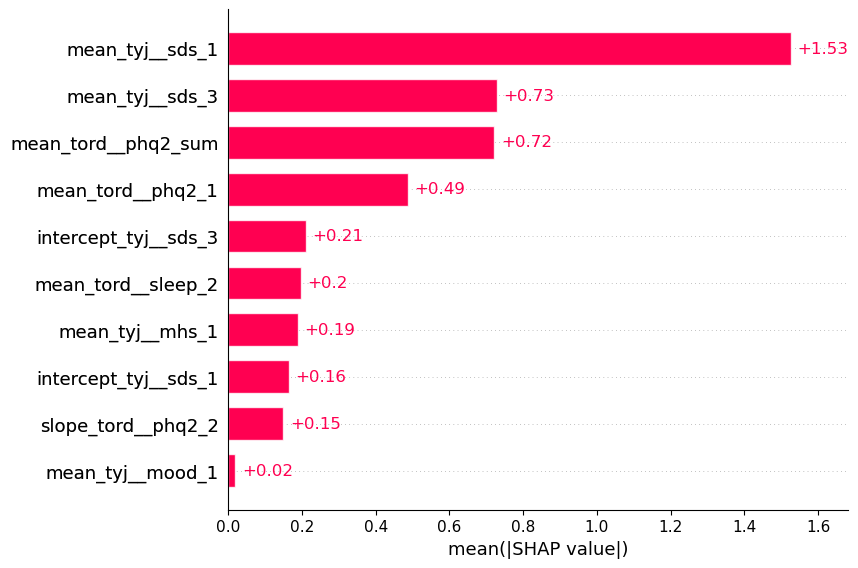

v2_day both HistGradientBoostingRegressor Mean R2: 0.178


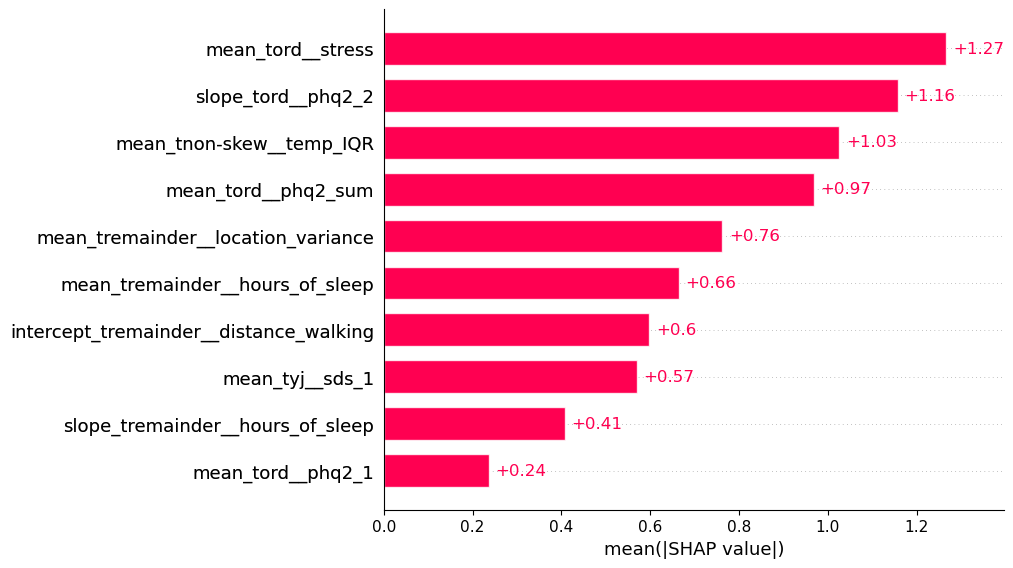

v1_week both HistGradientBoostingRegressor Mean R2: -0.082


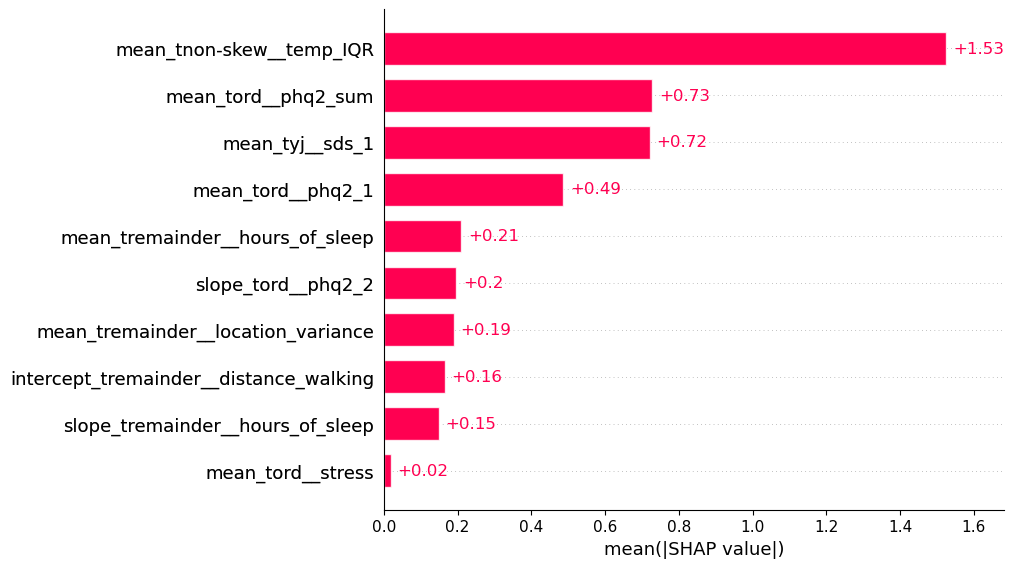

v2_week both HistGradientBoostingRegressor Mean R2: 0.192


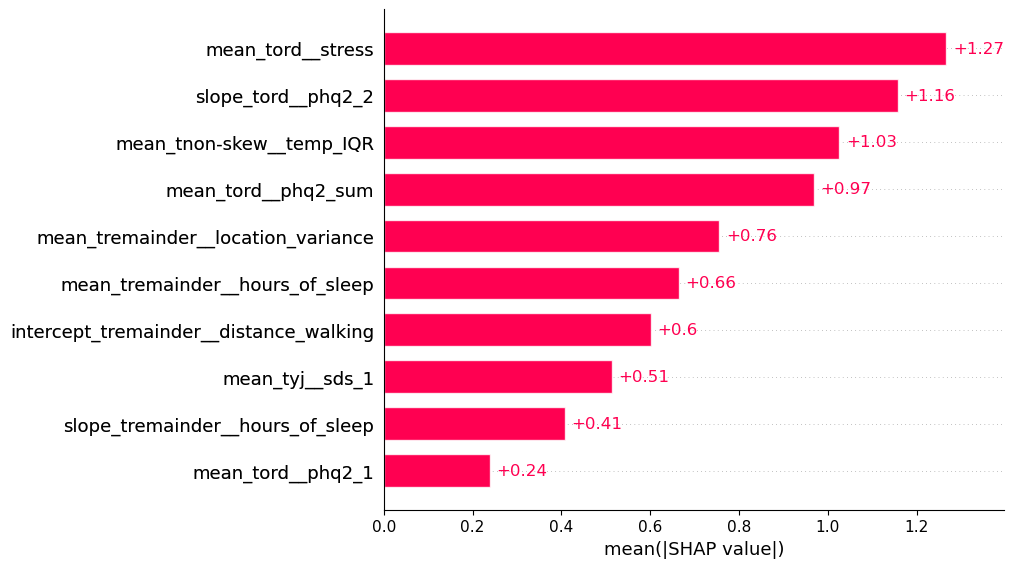

In [ ]:
# Feature importance 
# SHAP Printing 

for name in ['v1_day', 'v2_day', 'v1_week', 'v2_week']: #4
	for y_col in ['phq9_mean']: #2
		for type in ['both']: #3
			for model_name in models: #only one atm 
				mean_r2 = round(np.mean(model_dict_slopeint[name][y_col][type][model_name]['r2_scores']), 3)
				print(name, type, model_name, f'Mean R2: {mean_r2}')
				i=0 #change based on which CV you want to see
				explainer = shap.Explainer(model_dict_slopeint[name][y_col][type][model_name]['model'][i], approximate=True)
				shap_values = explainer(model_dict_slopeint[name][y_col][type][model_name]['X_test'][i], check_additivity=False)
				shap.plots.bar(shap_values)
				del explainer, shap_values
				gc.collect() 

Interestingly, adding the baseline features decreased the R2 score. 

Try PCA on long dataset

In [ ]:
for name in df_names:
	print(f'\n\nDATAFRAME: {name}')

	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_Xy_imputed_8wks_long_trainval.csv'))
	y_col = 'change_sum'
	X_col = [col for col in df.columns if any(item in col for item in daily_v2_weather)]

	corr = df[X_col + [y_col]].corr()
	corr = corr[y_col].sort_values(ascending=False)
	print(f'Top 5 features correlated with {y_col}:')
	print(corr.head(8))

correlated_weather_cols = ['non-skew__humidity_mean', 'non-skew__humidity_median', 'non-skew__cloud_cover_mean', 'non-skew__cloud_cover_median']


In [ ]:
for name in df_names:
	print(f'\n\nDATAFRAME: {name}')

	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_Xy_imputed_long_trainval.csv'))
	print(df.columns.to_list())
	print(len(df.columns.to_list()))




DATAFRAME: v1_day
['Unnamed: 0', 'day', 'num_id', 'remainder__phq2_1', 'remainder__phq2_2', 'remainder__phq2_sum', 'non-skew__aggregate_communication', 'non-skew__call_count', 'non-skew__call_duration', 'non-skew__interaction_diversity', 'non-skew__missed_interactions', 'non-skew__sms_count', 'non-skew__sms_length', 'bc__mobility', 'bc__mobility_radius', 'ord__gad7_1', 'ord__gad7_2', 'ord__gad7_3', 'ord__gad7_4', 'ord__gad7_5', 'ord__gad7_6', 'ord__gad7_7', 'ord__gad7_8', 'ord__gad7_sum', 'ord__gad_cat', 'ord__screen_1', 'yj__screen_2', 'yj__screen_3', 'yj__screen_4', 'cat__gender_0.0', 'cat__gender_1.0', 'cat__gender_nan', 'ord__education', 'ord__working', 'ord__income_satisfaction', 'ord__income_lastyear', 'ord__marital_status', 'cat__race_0.0', 'cat__race_1.0', 'cat__race_2.0', 'cat__race_3.0', 'cat__race_4.0', 'cat__race_5.0', 'cat__race_6.0', 'cat__race_nan', 'yj__age', 'ord__alc_1', 'yj__alc_2', 'yj__alc_3', 'ord__alc_sum', 'yj__sds_1', 'ord__sds_2', 'yj__sds_3', 'ord__stress',

In [ ]:

symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
sensor_matrices_df_dict = {}
target_matrices_df_dict = {}
flattened_sensor_df_dict = {}
flattened_target_df_dict = {}	

correlated_weather_cols = ['non-skew__humidity_mean', 'non-skew__humidity_median', 'non-skew__cloud_cover_mean', 'non-skew__cloud_cover_median']

#### Take the average of each subject's symptom correlation and use it to make clusters of variables

# Create dicts of all subjects' correlation matrices
for name in df_names:
	print(f'\n\nDATAFRAME: {name}')

	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_Xy_imputed_long_trainval.csv'))
	df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
	
	# Take out y columns
	y_cols = ['change_cat','change_sum','change_binary','phq9_mean','phq9_cat_mean']
	df = df.drop(columns=[col for col in df.columns if any(item in col for item in y_cols)])

	# Take out baseline columns
	df = df.drop(columns=[col for col in df.columns if any(item in col for item in baseline_cols)])

	# Make symptom/flattened dicts for all cols
	ignore_cols = [col for col in df.columns if any(item in col for item in baseline_cols+id_columns) or "_indicator" in col or "_bin" in col or "index" in col]
	ignore_cols.append('season')
	# target_cols = [col for col in df.columns if "phq9" in col]

	weather_cols_present = [col for col in df.columns if any(item in col for item in daily_v2_weather)]
	weather_cols_drop = [col for col in weather_cols_present if col not in correlated_weather_cols]
	ignore_cols += weather_cols_drop

	keep_columns = list(set(df.columns.to_list()) - set(ignore_cols))
	print(keep_columns)
	print(f"All cols for {name}:")
	symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=0)
	

	# Assign dicts to nested dict
	symptom_matrices_df_dict[name] = symptom_matrix_dict
	flattened_matrices_df_dict[name] = flattened_matrix_dict


	# Make separate symptom/flattened dicts for target cols vs. sensor cols
	if 'week' in name:
		target_cols = phq9_cols
		print(f"Sensor cols for {name}:")
		sensor_cols = [col for col in df.columns if any(item in col for item in daily_cols_v1+daily_cols_v2)]
		print(sensor_cols)
		nonsensor_cols = [col for col in df.columns if col not in sensor_cols]
		sensor_matrices_dict, flattened_sensor_dict = fs.make_symptom_matrices(df, ignore_cols+nonsensor_cols, num_to_plot=0)
		target_df = df.copy().drop(columns=[col for col in df.columns if col not in target_cols and 'num_id' not in col])
		print(f"Target cols for {name}:")

		target_matrices_dict, flattened_target_dict = fs.make_symptom_matrices(target_df, ignore_cols, num_to_plot=0)

	if 'day' in name:
		print(f"Sensor cols for {name}:")
		target_cols = phq2_cols
		sensor_cols = [col for col in df.columns if any(item in col for item in daily_cols_v1+daily_cols_v2)]
		print(sensor_cols)
		nonsensor_cols = [col for col in df.columns if col not in sensor_cols]
		sensor_matrices_dict, flattened_sensor_dict = fs.make_symptom_matrices(df, ignore_cols+nonsensor_cols, num_to_plot=0)
		target_df = df.copy().drop(columns=[col for col in df.columns if col not in target_cols and 'num_id' not in col])
		print(f"Target cols for {name}:")
		target_matrices_dict, flattened_target_dict = fs.make_symptom_matrices(target_df, ignore_cols, num_to_plot=0)

	#Assign sensor/target dicts to nested dict
	sensor_matrices_df_dict[name] = sensor_matrices_dict
	target_matrices_df_dict[name] = target_matrices_dict
	flattened_sensor_df_dict[name] = flattened_sensor_dict
	flattened_target_df_dict[name] = flattened_target_dict






DATAFRAME: v1_day
['non-skew__call_count', 'remainder__phq2_1', 'bc__mobility', 'remainder__phq2_2', 'ord__mhs_3', 'ord__mhs_5', 'ord__mhs_1', 'ord__sleep_2', 'non-skew__call_duration', 'non-skew__sms_count', 'yj__mood_1', 'ord__mhs_2', 'non-skew__aggregate_communication', 'bc__mobility_radius', 'ord__sleep_3', 'ord__support', 'ord__stress', 'yj__sds_3', 'remainder__phq2_sum', 'ord__mhs_4', 'non-skew__sms_length', 'mood_1_final', 'yj__sds_1', 'non-skew__missed_interactions', 'ord__sds_2', 'ord__sleep_1']
All cols for v1_day:
In df there are 231 subjects.
231 subs with symptom matrices
231 filled condensed arrays
Sensor cols for v1_day:
['non-skew__aggregate_communication', 'non-skew__call_count', 'non-skew__call_duration', 'non-skew__interaction_diversity', 'non-skew__missed_interactions', 'non-skew__sms_count', 'non-skew__sms_length', 'bc__mobility', 'bc__mobility_radius']
In df there are 231 subjects.
231 subs with symptom matrices
231 filled condensed arrays
Target cols for v1_day

In [ ]:
matrix = symptom_matrices_df_dict['v2_day'][1178.0]
display(matrix)
display(flattened_matrices_df_dict['v2_day'][1178.0])

ord__sds_2  \
ord__sds_2                                           1.000000   
yj__distance_high_speed_transportation_hr_nonzero    0.000000   
ord__sleep_1                                         0.000000   
remainder__phq2_sum                                  0.194988   
yj__mood_1                                          -0.697741   
ord__mhs_4                                           0.000000   
ord__support                                         0.465873   
yj__distance_walking_hr                             -0.127907   
yj__hours_of_sleep_hr                                0.119932   
mood_1_final                                         0.000000   
remainder__phq2_2                                   -0.267059   
yj__sds_3                                            0.993870   
yj__sds_1                                            0.979155   
ord__stress                                          0.986286   
yj__hours_high_speed_transportation_hr              -0.128247   
yj__distance_high_speed_transportation_hr           -0.128247   
ord__mhs_2                                           0.000000   
remainder__phq2_1                                    0.619460   
ord__mhs_5                                           0.000000   
ord__mhs_1                                           0.000000   
ord__mhs_3                                           0.000000   
non-skew__humidity_mean                              0.058099   
non-skew__humidity_median                            0.056546   
ord__sleep_2                                         0.000000   
ord__sleep_3                                         0.000000   

                                                   yj__distance_high_speed_transportation_hr_nonzero  \
ord__sds_2                                                                                       0.0   
yj__distance_high_speed_transportation_hr_nonzero                                                0.0   
ord__sleep_1                                                                                     0.0   
remainder__phq2_sum                                                                              0.0   
yj__mood_1                                                                                       0.0   
ord__mhs_4                                                                                       0.0   
ord__support                                                                                     0.0   
yj__distance_walking_hr                                                                          0.0   
yj__hours_of_sleep_hr                                                                            0.0   
mood_1_final                                                                                     0.0   
remainder__phq2_2                                                                                0.0   
yj__sds_3                                                                                        0.0   
yj__sds_1                                                                                        0.0   
ord__stress                                                                                      0.0   
yj__hours_high_speed_transportation_hr                                                           0.0   
yj__distance_high_speed_transportation_hr                                                        0.0   
ord__mhs_2                                                                                       0.0   
remainder__phq2_1                                                                                0.0   
ord__mhs_5                                                                                       0.0   
ord__mhs_1                                                                                       0.0   
ord__mhs_3                                                                                       0.0   
non-skew__humidity_mean                                                 

[0.0,
 0.0,
 0.19498826681319933,
 -0.6977407149243607,
 0.0,
 0.46587277121357973,
 -0.12790724682601307,
 0.1199316636824021,
 0.0,
 -0.2670588832739665,
 0.9938703702317653,
 0.979154801788663,
 0.986285553750134,
 -0.1282472940106441,
 -0.12824729401064408,
 0.0,
 0.619460200092208,
 0.0,
 0.0,
 0.0,
 0.05809878014554014,
 0.0565458121547059,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09209366121762301,
 0.0,
 0.37264932319770094,
 0.012242717399592694,
 -0.1459012154773994,
 0.0,
 0.8763200695812072,
 0.158584289938516,
 0.25561236157405576,
 0.1397492806891545,
 0.10798355319767003,
 0.10798355319767,
 0.0,
 0.8688636131405456,
 0.0,
 0.0,
 0.0,
 -0.05020191752612114,
 -0.06966769132949525,
 0.0,
 0.0,
 0.0,
 0.30880548042783823,
 0.061712923

In [ ]:
print(symptom_matrices_df_dict['v1_day'][next(iter(symptom_matrices_df_dict['v1_day']))].columns.to_list())
#ind = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]

['yj__sds_3', 'ord__sds_2', 'yj__sds_1', 'ord__stress', 'ord__sleep_1', 'non-skew__call_duration', 'non-skew__aggregate_communication', 'non-skew__missed_interactions', 'remainder__phq2_sum', 'yj__mood_1', 'ord__sleep_2', 'ord__mhs_2', 'ord__mhs_4', 'ord__support', 'remainder__phq2_1', 'bc__mobility_radius', 'ord__mhs_1', 'ord__mhs_5', 'non-skew__sms_length', 'bc__mobility', 'ord__mhs_3', 'mood_1_final', 'non-skew__call_count', 'non-skew__sms_count', 'remainder__phq2_2', 'ord__sleep_3']


T test https://www.youtube.com/watch?v=VekJxtk4BYM 

Needs normal distribution of the metric variables-- test for normal distribution of each corr value

also the variance between my two groups must be approximately equal -- levene's test

In [ ]:
#num_id	change_sum	week	change_binary	phq9_mean	phq9_bin
#v1_phq9_sum_change.csv

# SENSOR AND SURVEY 
# Network based statistics for high phq9 vs. low phq9 -- OVER WHOLE STUDY
import bct 
from bct import nbs
from scipy import stats

significance_level = 0.05

for v in ['v1','v2']:
	print(v)
	phq9_stats = pd.read_csv(os.path.join(brighten_dir, f'{v}_phq9_sum_change.csv'))

	depressed = phq9_stats[phq9_stats['phq9_bin']==1]['num_id']
	print(f'There are {len(depressed)} subs in the depressed group')
	depressed_present = [sub for sub in depressed if sub in symptom_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(depressed_present)} subs present from the depressed group')
	X = {key: symptom_matrices_df_dict[f'{v}_day'][key] for key in depressed_present}
	x_arr = np.stack([df.values for df in X.values()], axis=-1)
	print(f'x_arr shape {x_arr.shape}')
		
	nondepressed = phq9_stats[phq9_stats['phq9_bin']==0]['num_id']
	print(f'There are {len(depressed)} subs in the nondepressed group')
	nondepressed_present = [sub for sub in nondepressed if sub in symptom_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(nondepressed_present)} subs present from the nondepressed group')
	y = {key: symptom_matrices_df_dict[f'{v}_day'][key] for key in nondepressed_present}
	y_arr = np.stack([df.values for df in y.values()], axis=-1)
	print(f'y_arr shape {y_arr.shape}')

	degf = len(X) + len(y) - 2
	print(f'The degrees of freedom are: {degf}')

	t_thresh = stats.t.ppf(1-significance_level, degf)
	print(f'The critical t value is {round(t_thresh, 2)}')

	pval, adj, null = nbs.nbs_bct(x_arr, y_arr, thresh=t_thresh, verbose=False)
	print(pval)
	# Convert adj to boolean mask
	mask = adj.astype(bool)
	component_cols = y[next(iter(y))].loc[:, mask]
	print(component_cols.columns.to_list())


v1
There are 111 subs in the depressed group
There are 41 subs present from the depressed group
x_arr shape (26, 26, 41)
There are 111 subs in the nondepressed group
There are 102 subs present from the nondepressed group
y_arr shape (26, 26, 102)
The degrees of freedom are: 141
The critical t value is 1.66
max component size is 78
estimating null distribution with 1000 permutations
permutation 0 of 1000.  p-value so far is 0.000
permutation 100 of 1000.  p-value so far is 0.000
permutation 200 of 1000.  p-value so far is 0.000
permutation 300 of 1000.  p-value so far is 0.000
permutation 400 of 1000.  p-value so far is 0.000
permutation 500 of 1000.  p-value so far is 0.000
permutation 600 of 1000.  p-value so far is 0.000
permutation 700 of 1000.  p-value so far is 0.000
permutation 800 of 1000.  p-value so far is 0.000
permutation 900 of 1000.  p-value so far is 0.000
permutation 999 of 1000.  p-value so far is 0.000
[0.]
['ord__sleep_1', 'ord__sleep_1', 'ord__sleep_1', 'ord__sleep_1

In [ ]:
#num_id	change_sum	week	change_binary	phq9_mean	phq9_bin
#v1_phq9_sum_change.csv

# JUST SENSOR
# Network based statistics for high phq9 vs. low phq9 -- OVER WHOLE STUDY
import bct 
from bct import nbs
from scipy import stats

significance_level = 0.05

for v in ['v1','v2']:
	print(v)
	phq9_stats = pd.read_csv(os.path.join(brighten_dir, f'{v}_phq9_sum_change.csv'))
	depressed = phq9_stats[phq9_stats['phq9_bin']==1]['num_id']
	print(f'There are {len(depressed)} subs in the depressed group')
	depressed_present = [sub for sub in depressed if sub in sensor_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(depressed_present)} subs present from the depressed group')
	X = {key: sensor_matrices_df_dict[f'{v}_day'][key] for key in depressed_present}
	x_arr = np.stack([df.values for df in X.values()], axis=-1)
	print(f'x_arr shape {x_arr.shape}')
		
	nondepressed = phq9_stats[phq9_stats['phq9_bin']==0]['num_id']
	print(f'There are {len(depressed)} subs in the nondepressed group')
	nondepressed_present = [sub for sub in nondepressed if sub in sensor_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(nondepressed_present)} subs present from the nondepressed group')
	y = {key: sensor_matrices_df_dict[f'{v}_day'][key] for key in nondepressed_present}
	y_arr = np.stack([df.values for df in y.values()], axis=-1)
	print(f'y_arr shape {y_arr.shape}')

	degf = len(X) + len(y) - 2
	print(f'The degrees of freedom are: {degf}')

	t_thresh = stats.t.ppf(1-significance_level, degf)
	print(f'The critical t value is {round(t_thresh, 2)}')

	pval, adj, null = nbs.nbs_bct(x_arr, y_arr, thresh=t_thresh, verbose=False)
	print(pval)
	# Convert adj to boolean mask
	mask = adj.astype(bool)
	component_cols = y[next(iter(y))].loc[:, mask]
	print(component_cols.columns.to_list())


v1
There are 111 subs in the depressed group
There are 41 subs present from the depressed group
x_arr shape (8, 8, 41)
There are 111 subs in the nondepressed group
There are 102 subs present from the nondepressed group
y_arr shape (8, 8, 102)
The degrees of freedom are: 141
The critical t value is 1.66
max component size is 3
estimating null distribution with 1000 permutations
permutation 0 of 1000.  p-value so far is 1.000
permutation 100 of 1000.  p-value so far is 0.376
permutation 200 of 1000.  p-value so far is 0.378
permutation 300 of 1000.  p-value so far is 0.362
permutation 400 of 1000.  p-value so far is 0.357
permutation 500 of 1000.  p-value so far is 0.343
permutation 600 of 1000.  p-value so far is 0.354
permutation 700 of 1000.  p-value so far is 0.359
permutation 800 of 1000.  p-value so far is 0.360
permutation 900 of 1000.  p-value so far is 0.366
permutation 999 of 1000.  p-value so far is 0.363
[0.363]
['non-skew__missed_interactions', 'non-skew__missed_interactions

In [ ]:
#num_id	change_sum	week	change_binary	phq9_mean	phq9_bin
#v1_phq9_sum_change.csv

# Network based statistics for high phq9 vs. low phq9 --- ENDING/LAST PHQ9
import bct 
from bct import nbs
from scipy import stats

significance_level = 0.05

for v in ['v1','v2']:
	print(v)
	
	phq9_end_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_phq9sum_last'))
	phq9_end_df = phq9_end_df.loc[:, ~phq9_end_df.columns.str.contains('Unnamed')]

	depressed = phq9_end_df[phq9_end_df['depressed_binary']==1]['num_id']
	print(f'There are {len(depressed)} subs in the depressed group')
	depressed_present = [sub for sub in depressed if sub in symptom_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(depressed_present)} subs present from the depressed group')
	X = {key: symptom_matrices_df_dict[f'{v}_day'][key] for key in depressed_present}
	x_arr = np.stack([df.values for df in X.values()], axis=-1)
	print(f'x_arr shape {x_arr.shape}')
		
	nondepressed = phq9_end_df[phq9_end_df['depressed_binary']==0]['num_id']
	print(f'There are {len(depressed)} subs in the nondepressed group')
	nondepressed_present = [sub for sub in nondepressed if sub in symptom_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(nondepressed_present)} subs present from the nondepressed group')
	y = {key: symptom_matrices_df_dict[f'{v}_day'][key] for key in nondepressed_present}
	y_arr = np.stack([df.values for df in y.values()], axis=-1)
	print(f'y_arr shape {y_arr.shape}')

	degf = len(X) + len(y) - 2
	print(f'The degrees of freedom are: {degf}')

	t_thresh = stats.t.ppf(1-significance_level, degf)
	print(f'The critical t value is {round(t_thresh, 2)}')

	pval, adj, null = nbs.nbs_bct(x_arr, y_arr, thresh=t_thresh, verbose=False)
	print(pval)
	# Convert adj to boolean mask
	mask = adj.astype(bool)
	component_cols = y[next(iter(y))].loc[:, mask]
	print(component_cols.columns.to_list())


In [ ]:
#num_id	change_sum	week	change_binary	phq9_mean	phq9_bin
#v1_phq9_sum_change.csv

# Network based statistics for positive change vs. negative change
import bct 
from bct import nbs
from scipy import stats
from scipy.stats import ttest_ind


significance_level = 0.05

for v in ['v1','v2']:
	print(v)
	phq9_stats = pd.read_csv(os.path.join(brighten_dir, f'{v}_phq9_sum_change.csv'))
	pos = phq9_stats[phq9_stats['change_binary'].isin([0,1])]['num_id']
	print(f'There are {len(pos)} subs in the pos group')
	pos_present = [sub for sub in pos if sub in sensor_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(pos_present)} subs present from the pos group')
	X = {key: sensor_matrices_df_dict[f'{v}_day'][key] for key in pos_present}
	x_arr = np.stack([df.values for df in X.values()], axis=-1)
	print(f'x_arr shape {x_arr.shape}')
		
	neg = phq9_stats[phq9_stats['change_binary'].isin([-1])]['num_id']
	print(f'There are {len(neg)} subs in the neg group')
	neg_present = [sub for sub in neg if sub in sensor_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(nondepressed_present)} subs present from the neg group')
	y = {key: sensor_matrices_df_dict[f'{v}_day'][key] for key in neg_present}
	y_arr = np.stack([df.values for df in y.values()], axis=-1)
	print(f'y_arr shape {y_arr.shape}')

	degf = len(X) + len(y) - 2
	print(f'The degrees of freedom are: {degf}')

	t_thresh = stats.t.ppf(1-significance_level, degf)
	print(f'The critical t value is {round(t_thresh, 2)}')
	# Flatten along subjects
	tvals, pvals = ttest_ind(x_arr.transpose(2,0,1).reshape(len(X), -1),
							y_arr.transpose(2,0,1).reshape(len(y), -1),
							axis=0, equal_var=False)
	print("Max |t|:", np.nanmax(np.abs(tvals)))


	pval, adj, null = nbs.nbs_bct(x_arr, y_arr, thresh=t_thresh, verbose=False)

	print(pval)
	# Convert adj to boolean mask
	mask = adj.astype(bool)
	component_cols = y[next(iter(y))].loc[:, mask]
	print(component_cols.columns.to_list())


v1
There are 270 subs in the pos group
There are 95 subs present from the pos group
x_arr shape (8, 8, 95)
There are 124 subs in the neg group
There are 42 subs present from the neg group
y_arr shape (8, 8, 48)
The degrees of freedom are: 141
The critical t value is 1.66
Max |t|: 2.285218200133685


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


BCTParamError: Unsuitable threshold

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


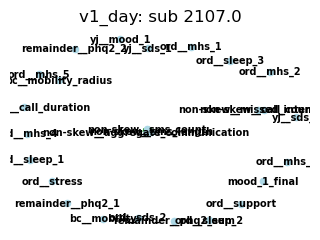

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


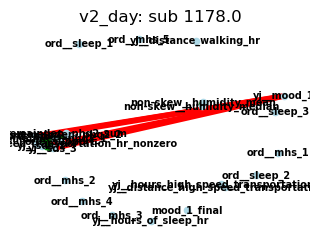

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


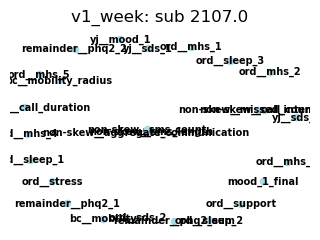

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


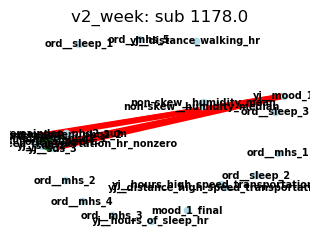

In [ ]:
# Plot a few symptom matrices
for name, df_dict in symptom_matrices_df_dict.items():
	count=0
	for sub, corr_matrix in df_dict.items():
		if count<1:
			fs.plot_network(corr_matrix, title=f'{name}: sub {sub}')
			count=+1

v1_day
(26, 26) variables included


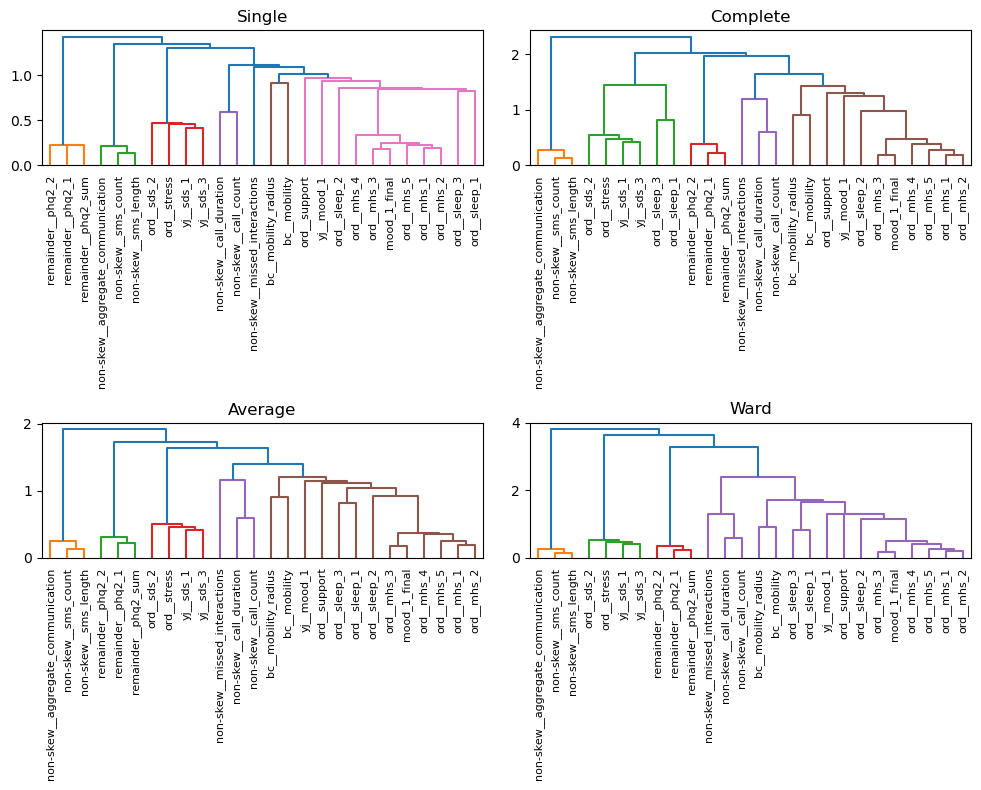

v2_day
(25, 25) variables included


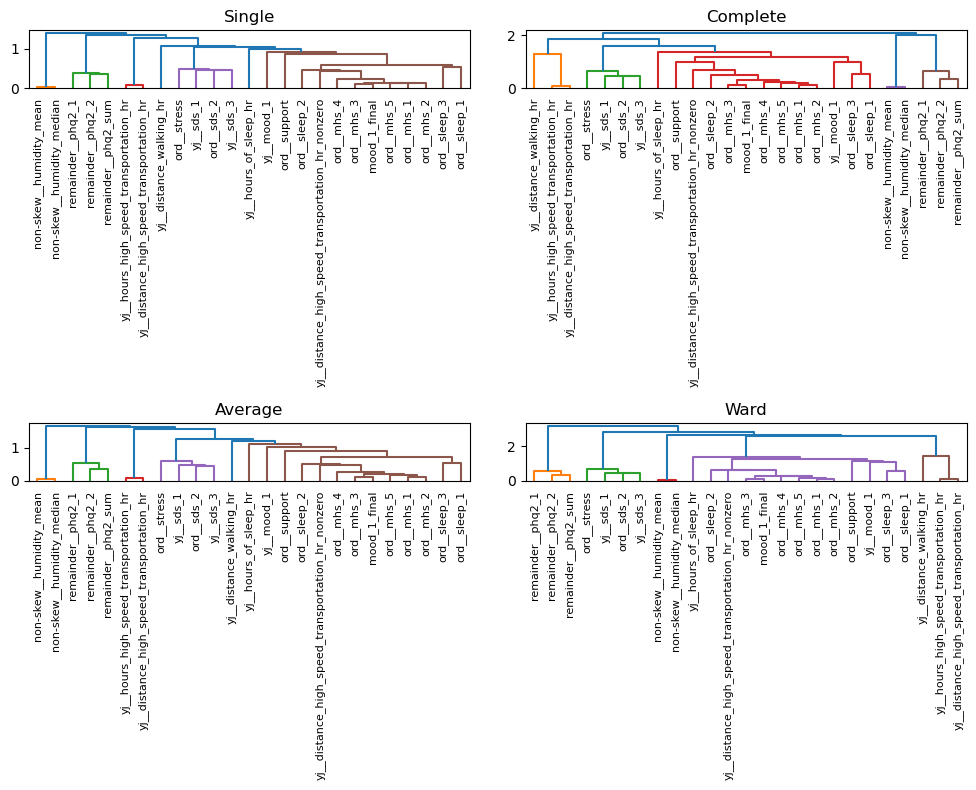

v1_week
(26, 26) variables included


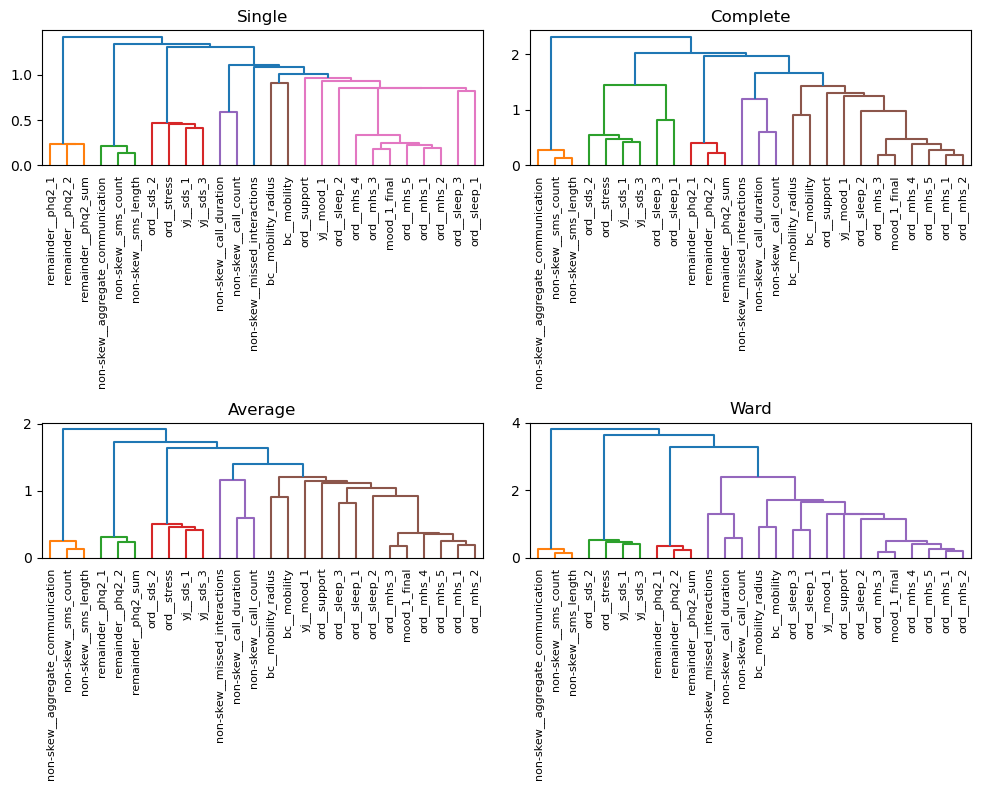

v2_week
(25, 25) variables included


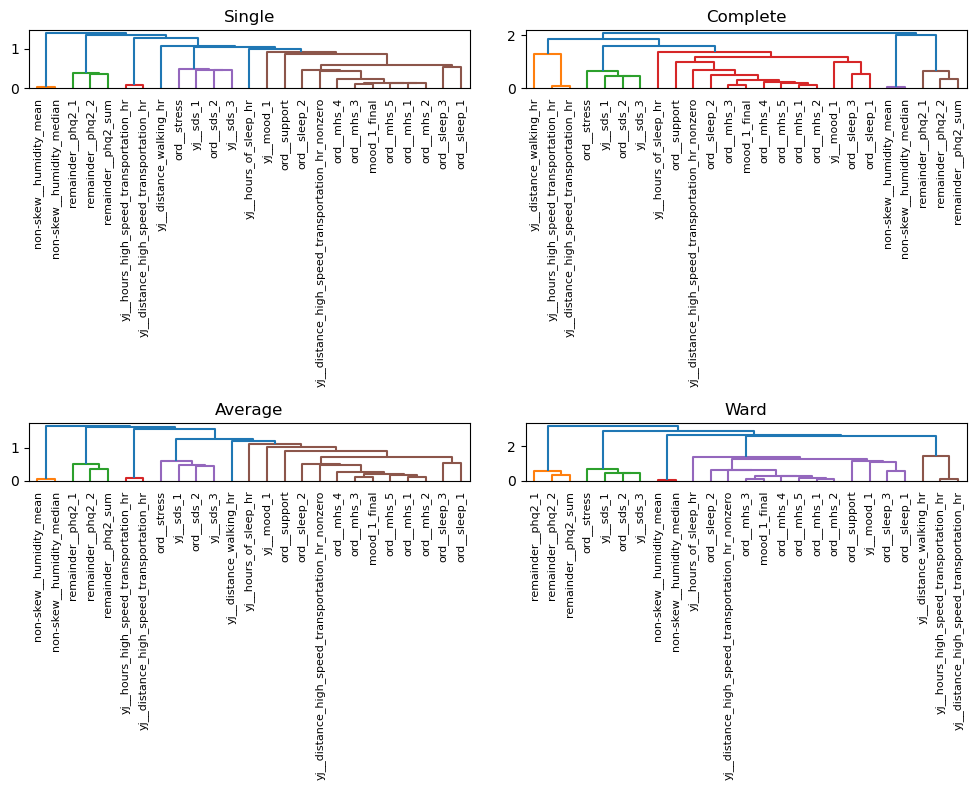

In [ ]:
## Plot options
for name, df in symptom_matrices_df_dict.items():
	avg_matrix = fs.average_matrix(df)
	fs.plot_hier_agg(avg_matrix, df[list(df.keys())[0]].index, is_dict=False, group_title=f'{name}') # 3, ward


In [ ]:
################# Create cluster_dict of Variables + Cluster Labels ############
# Fill in n clusters + linkage type

clust_dict = {}
# clust_dict['v1_day'] = v1_day_clust_dict
for name, dictionary in symptom_matrices_df_dict.items():
	avg_matrix = fs.average_matrix(dictionary)
	if 'v1_day' in name:
		clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=11, linkage='single', is_dict=False)
	elif 'v2_day' in name:
		clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=11, linkage='ward', is_dict=False)
	elif 'v1_week' in name:
		clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=11, linkage='single', is_dict=False)
	elif 'v2_week' in name:
	   clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=11, linkage='ward', is_dict=False)

In [ ]:
################# Create df_pca of Variables + 1st PC of clusters Labels ############
importlib.reload(fs)
dfs_pca = {}
dfs_pca_dict = {}
for name in df_names:
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_Xy_imputed_long_trainval.csv'))	
	
	print(f'\nFor {name}')
	dfs_pca[name], dfs_pca_dict[name] = fs.pca_on_clusters(df, clust_dict[name], n_clusters=9, wide=False) #n_clusters = number shown, so choose max



For v1_day
Cols for cluster 0: ['ord__sleep_1', 'ord__sleep_3', 'mood_1_final', 'ord__mhs_1', 'ord__mhs_2', 'ord__mhs_3', 'ord__mhs_4', 'ord__mhs_5']
Cols for cluster 1: ['non-skew__call_count', 'non-skew__call_duration']
Cols for cluster 2: ['non-skew__aggregate_communication', 'non-skew__sms_count', 'non-skew__sms_length']
Cols for cluster 3: ['remainder__phq2_1', 'remainder__phq2_2', 'remainder__phq2_sum']
Cols for cluster 4: ['yj__sds_1', 'ord__sds_2', 'yj__sds_3', 'ord__stress']
Cols for cluster 5: ['non-skew__missed_interactions']
Cols for cluster 6: ['yj__mood_1']
Cols for cluster 7: ['ord__support']
Cols for cluster 8: ['bc__mobility_radius']

For v2_day
Cols for cluster 0: ['yj__distance_high_speed_transportation_hr_nonzero', 'ord__sleep_2', 'mood_1_final', 'ord__mhs_1', 'ord__mhs_2', 'ord__mhs_3', 'ord__mhs_4', 'ord__mhs_5']
Cols for cluster 1: ['remainder__phq2_1', 'remainder__phq2_2', 'remainder__phq2_sum']
Cols for cluster 2: ['ord__sleep_1', 'ord__sleep_3']
Cols for clus

## Questions:

### SDS
- sds_1 	The symptoms have disrupted your work/school
- sds_2 	The symptoms have disrupted your social life / leisure activities
- sds_3 	The symptoms have disrupted your family life / home responsibilities
- stress 	In the last week, how much were you set back by stressful events or personal problems such as work, home, social, health, or financial problems?
- support In the past week, how much support have you received from friends, relatives, co-workers, etc., as a percentage of the amount you needed to cope?
	* *0 = not at all, 3 = Mildly, 6 = Moderately, 9 = Severely*

### Sleep
- sleep_1 	Thinking about your time in bed at night, over the past week, on average how long did it take you to fall asleep?
- sleep_3 	Thinking about your time in bed at night, over the past week, on average how long did you lie awake after having been asleep?
	* *1 = 0 - 15 minutes, 2 = 16 - 30 minutes, 3 = 31 - 60 minutes, 4 = 61 - 90 minutes, 5 = 91 - 120 minutes, 6 = More than 120 minutes*
- sleep_2 	Thinking about your time in bed at night, over the past week, on average how long were you actually asleep?
	* *1 = 5-6 hours, 2 = 6-7 hours, 3 = 7-8 hours, 4 = Less than 5 hours, 5 = More than 8 hours*

### Mental Health Services
- mhs_1 	An answer to, 'Do you see a psychiatrist for mental health or substance abuse treatment?'
- mhs_2 	An answer to, 'Do you see a psychologist, social worker, or other counselors for mental health or substance abuse treatment? '
- mhs_3 	An answer to, 'Do you attend any groups for mental health or substance abuse treatment?'
- mhs_4 	An answer to, ' Are you reading any self-help books for mental health or substance abuse treatment?'
- mhs_5 	An answer to, 'Are you taking any medications for mental health problems? 
	* *-1 = Decline, 0 = No, 1 = Yes* 

### Mood
- mood_1    'Since beginning this study, how would you describe the change (if any) in ACTIVITY LIMITATIONS, SYMPTOMS, EMOTIONS, and OVERALL QUALITY OF LIFE, related to your mood? '
	* *1 = No change, 2 = Almost the same, 3 = A little better, 4 = Somewhat better, 5 = Much better, 6 = Very much better*

In [ ]:
# # Name the clusters
dfs_pca_dict['v1_day'][0]['name'] = 'pc_sleep_mood_mhs'          # sleep_1, sleep_3, mhs_1-5
dfs_pca_dict['v1_day'][1]['name'] = 'pc_calls'                        # call_count, call_duration
dfs_pca_dict['v1_day'][2]['name'] = 'pc_lieAwake'                  # sds_1-3, stress
dfs_pca_dict['v1_day'][3]['name'] = 'pc_texts'         # sms_count, sms_length, aggregate_communication
dfs_pca_dict['v1_day'][4]['name'] = 'pc_phq2'                         # mood_1
dfs_pca_dict['v1_day'][5]['name'] = 'pc_sds_stress'                      # support
dfs_pca_dict['v1_day'][6]['name'] = 'pc_missed-interafctions'         # mobility_radius
dfs_pca_dict['v1_day'][7]['name'] = 'pc_mobility-radius'                    # mobility
dfs_pca_dict['v1_day'][8]['name'] = 'pc_mobility'              # sleep_2

dfs_pca_dict['v2_day'][0]['name'] = 'pc_sleep_mood_mhs'           # support, sleep_1-3, mhs_1-5
dfs_pca_dict['v2_day'][1]['name'] = 'pc_phq2'                  # sds_1-3, stress
dfs_pca_dict['v2_day'][2]['name'] = 'pc_lieAwake'       # humidity/temp IQR + std
dfs_pca_dict['v2_day'][3]['name'] = 'pc_sds'            # humidity mean + median
dfs_pca_dict['v2_day'][4]['name'] = 'pc_high-speed-trans'                # temp mean + median
dfs_pca_dict['v2_day'][5]['name'] = 'pc_distance-walk'                # dew point IQR + std
dfs_pca_dict['v2_day'][6]['name'] = 'pc_sleep-sensor'                # dew point mean + median
dfs_pca_dict['v2_day'][7]['name'] = 'pc_support'                      # precip_sum
dfs_pca_dict['v2_day'][8]['name'] = 'pc_mood-1'                         # mood_1

dfs_pca_dict['v1_week'][0]['name'] = 'pc_sleep_mood_mhs'          # sleep_1, sleep_3, mhs_1-5
dfs_pca_dict['v1_week'][1]['name'] = 'pc_calls'                        # call_count, call_duration
dfs_pca_dict['v1_week'][2]['name'] = 'pc_lieAwake'                  # sds_1-3, stress
dfs_pca_dict['v1_week'][3]['name'] = 'pc_texts'         # sms_count, sms_length, aggregate_communication
dfs_pca_dict['v1_week'][4]['name'] = 'pc_phq2'                         # mood_1
dfs_pca_dict['v1_week'][5]['name'] = 'pc_sds_stress'                      # support
dfs_pca_dict['v1_week'][6]['name'] = 'pc_missed-interafctions'         # mobility_radius
dfs_pca_dict['v1_week'][7]['name'] = 'pc_mobility-radius'                    # mobility
dfs_pca_dict['v1_week'][8]['name'] = 'pc_mobility'              # sleep_2

dfs_pca_dict['v2_week'][0]['name'] = 'pc_sleep_mood_mhs'           # support, sleep_1-3, mhs_1-5
dfs_pca_dict['v2_week'][1]['name'] = 'pc_phq2'                  # sds_1-3, stress
dfs_pca_dict['v2_week'][2]['name'] = 'pc_lieAwake'       # humidity/temp IQR + std
dfs_pca_dict['v2_week'][3]['name'] = 'pc_sds'            # humidity mean + median
dfs_pca_dict['v2_week'][4]['name'] = 'pc_high-speed-trans'                # temp mean + median
dfs_pca_dict['v2_week'][5]['name'] = 'pc_distance-walk'                # dew point IQR + std
dfs_pca_dict['v2_week'][6]['name'] = 'pc_sleep-sensor'                # dew point mean + median
dfs_pca_dict['v2_week'][7]['name'] = 'pc_support'                      # precip_sum
dfs_pca_dict['v2_week'][8]['name'] = 'pc_mood-1'                         # mood_1


importlib.reload(fs)
dfs_pca = {}
for name in df_names:
	df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_Xy_imputed_8wks_long_trainval.csv'))
	dfs_pca[name] = fs.merge_df_via_cluster_pca_dict(df_scaled, dfs_pca_dict[name], on_columns=['num_id','day'])
	dfs_pca[name].to_csv(os.path.join(brighten_dir, f'{name}_X_8wks_pca.csv'), index=False)
	print(f'Saved {name} PCA df to {name}_X_8wks_pca.csv')




Saved v1_day PCA df to v1_day_X_8wks_pca.csv
Saved v2_day PCA df to v2_day_X_8wks_pca.csv
Saved v1_week PCA df to v1_week_X_8wks_pca.csv
Saved v2_week PCA df to v2_week_X_8wks_pca.csv


In [ ]:
df_names

['v1_day', 'v2_day', 'v1_week', 'v2_week']

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


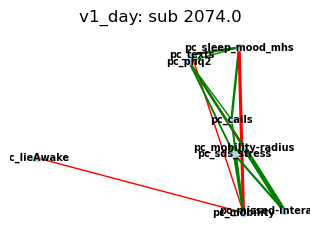

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


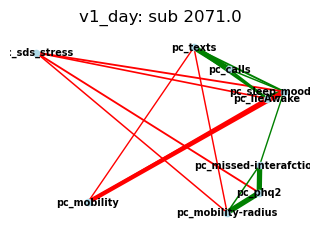

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


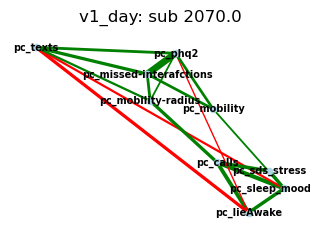

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


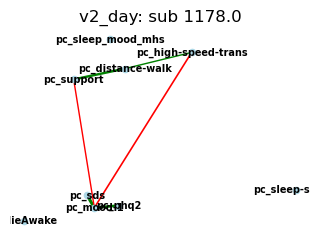

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


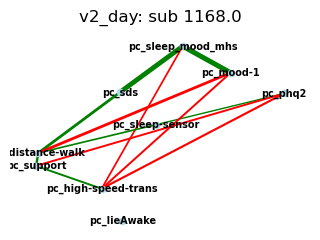

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


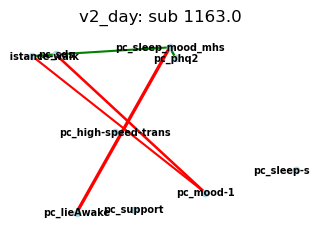

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


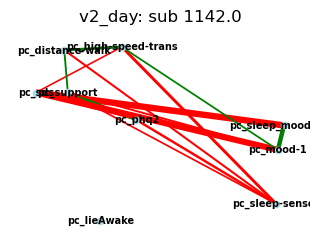

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


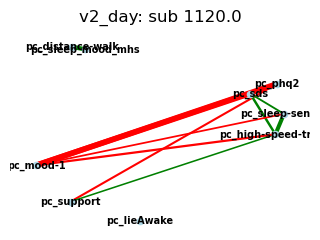

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


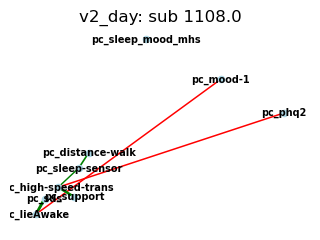

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


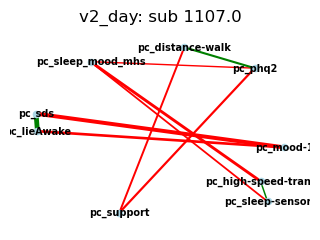

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


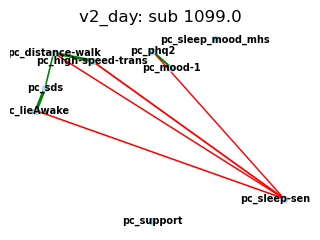

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


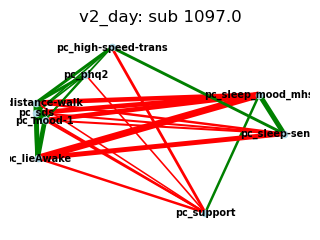

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


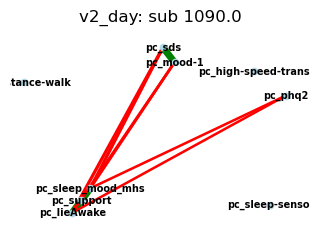

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


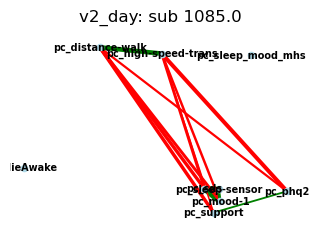

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


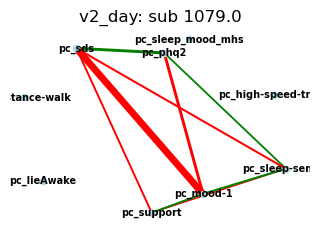

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


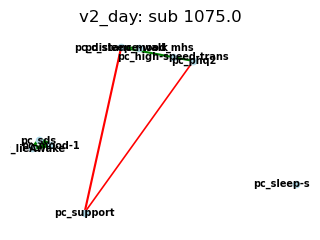

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


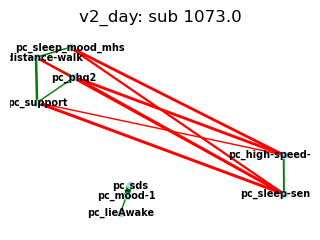

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


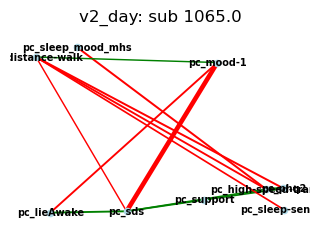

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


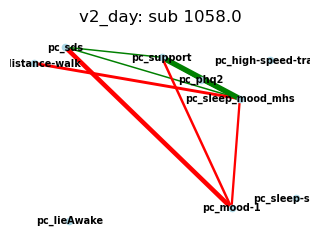

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


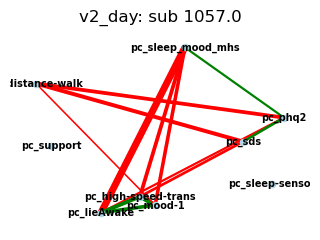

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


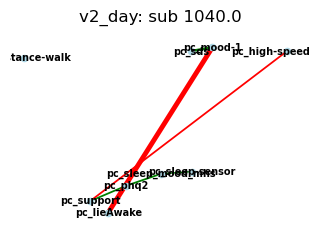

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


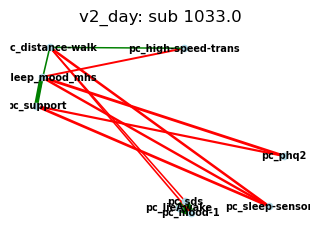

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


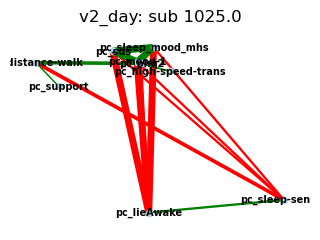

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


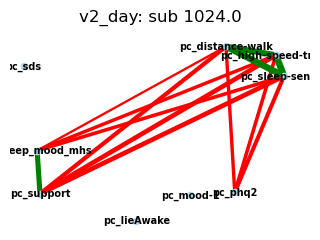

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


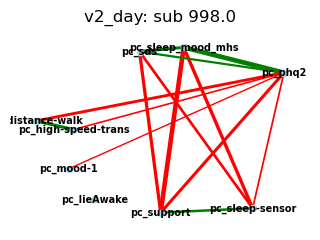

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


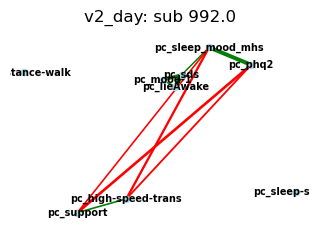

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


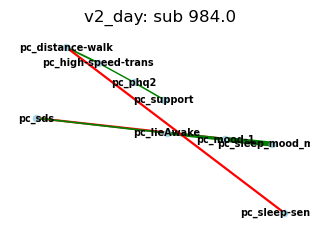

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


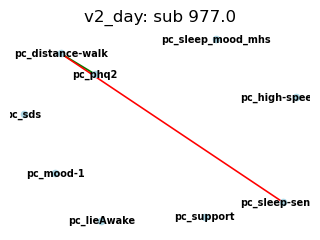

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


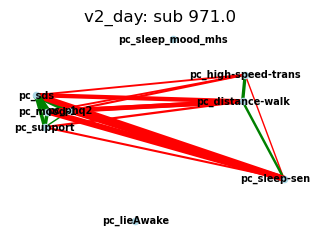

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


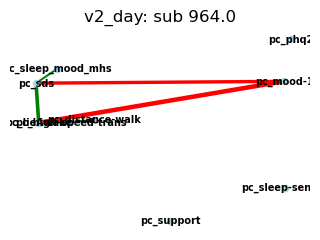

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


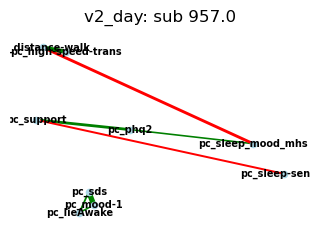

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


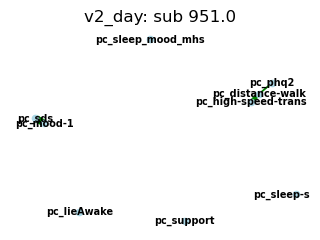

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


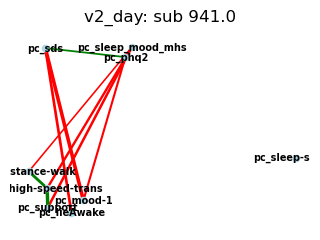

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


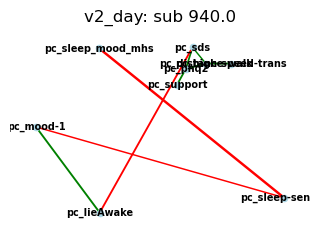

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


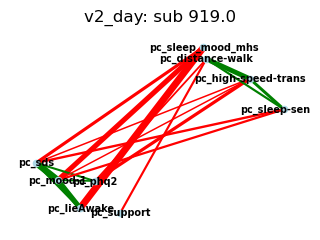

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


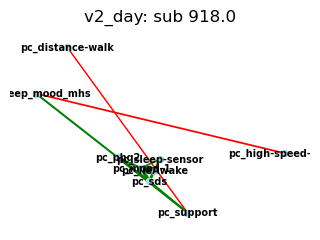

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


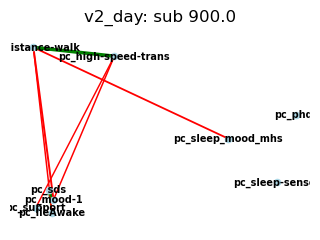

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


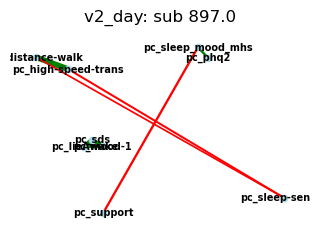

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


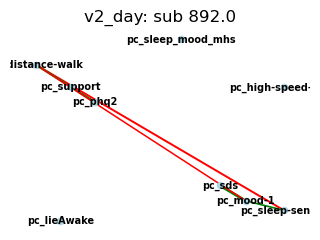

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


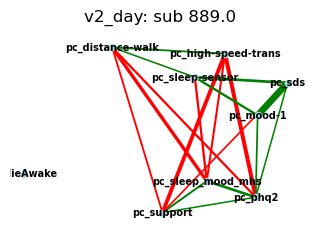

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


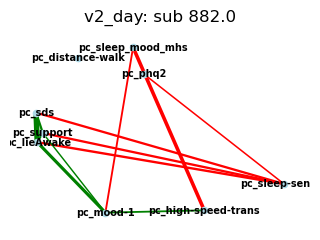

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


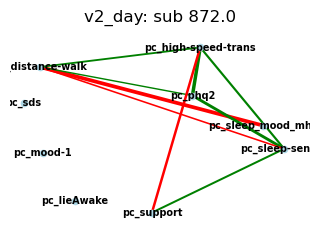

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


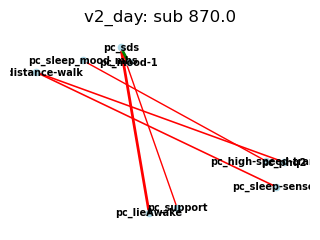

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


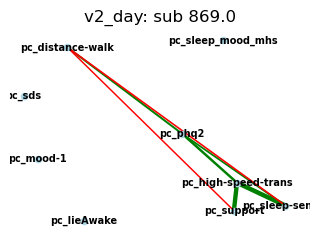

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


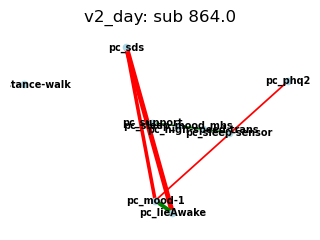

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


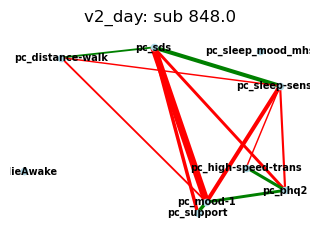

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


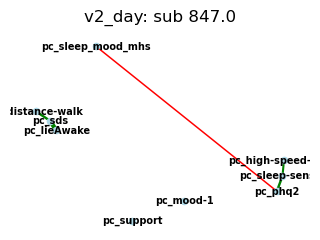

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


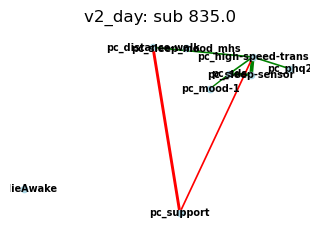

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


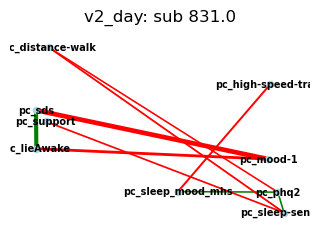

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


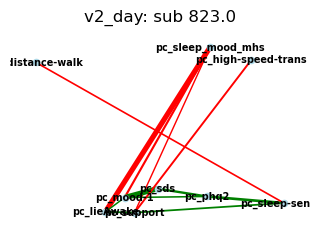

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


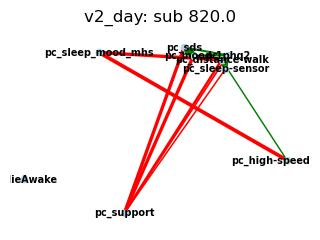

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


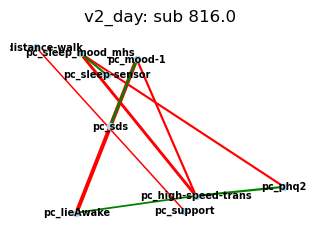

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


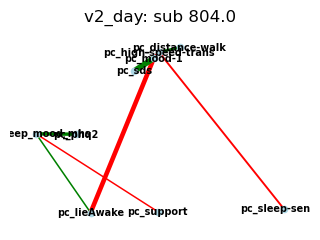

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


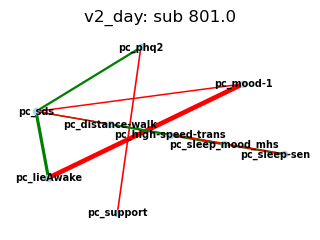

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


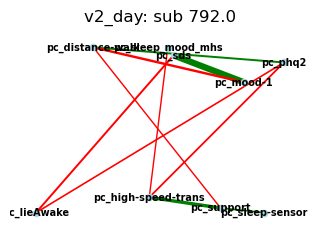

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


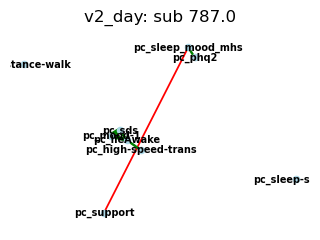

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


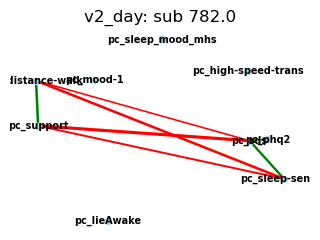

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


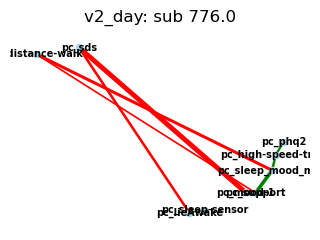

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


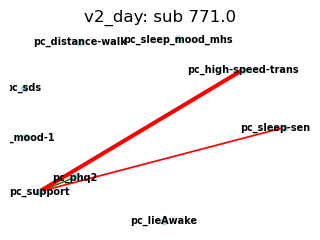

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


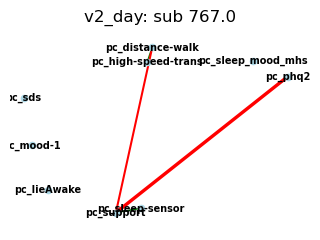

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


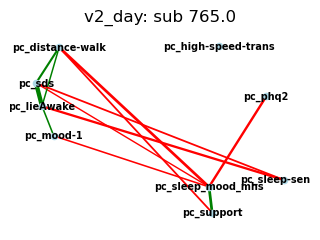

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


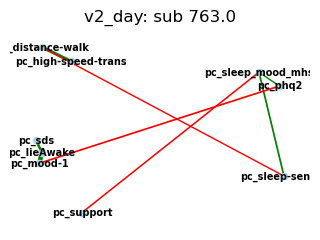

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


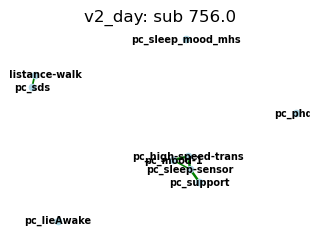

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


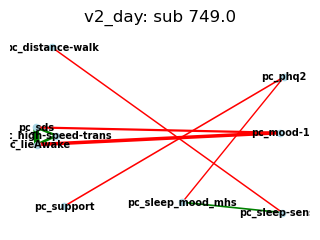

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


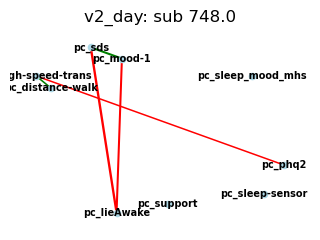

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


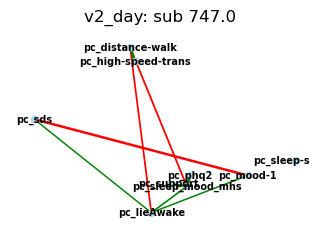

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


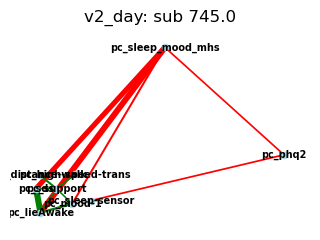

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


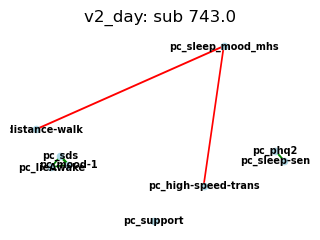

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


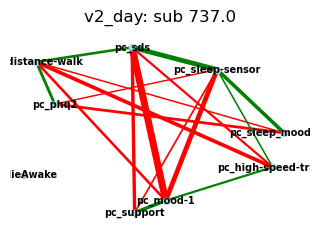

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


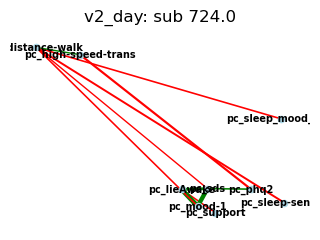

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


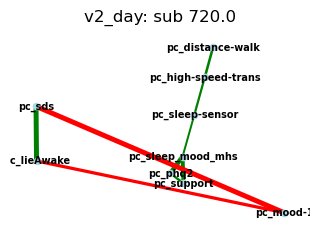

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


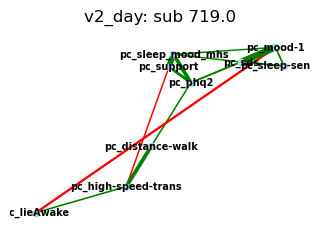

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


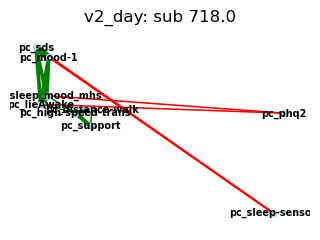

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


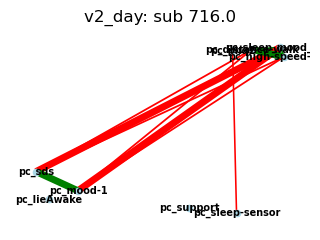

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


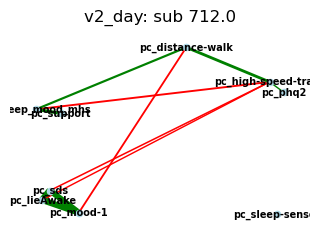

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


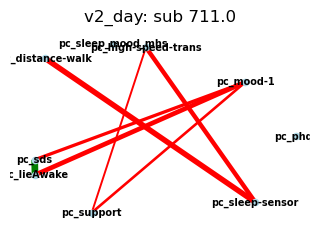

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


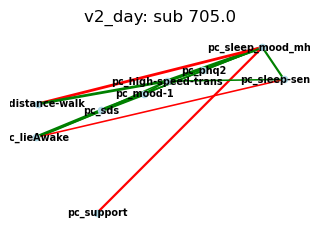

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


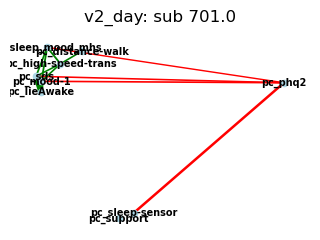

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


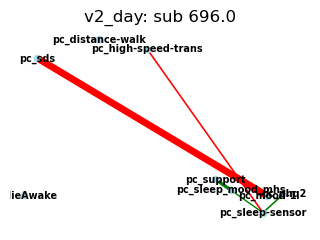

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


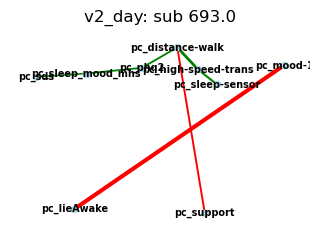

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


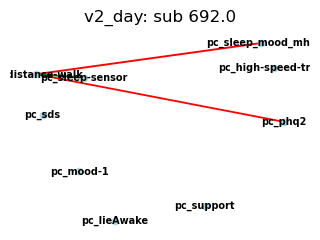

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


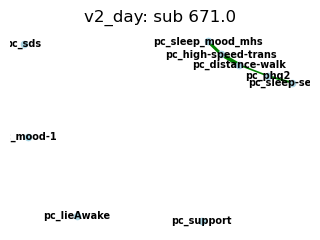

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


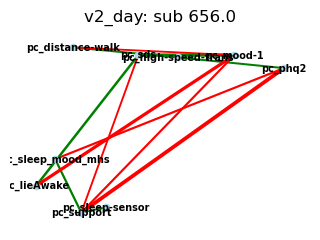

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


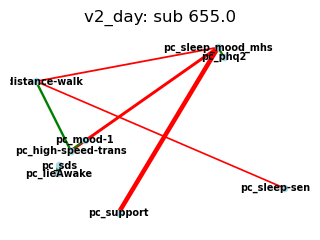

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


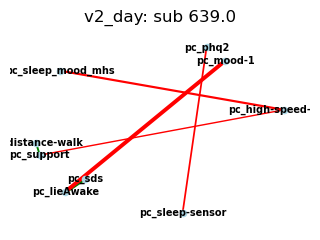

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


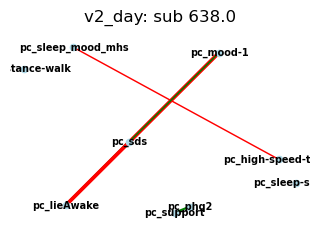

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


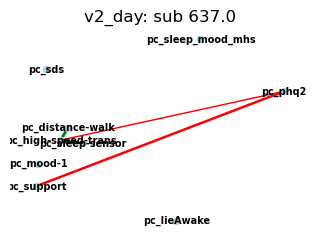

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


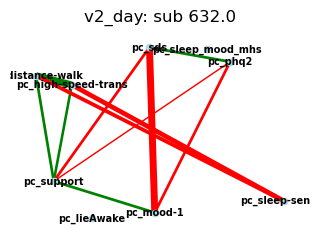

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


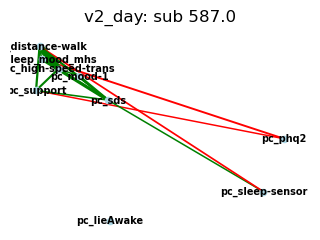

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


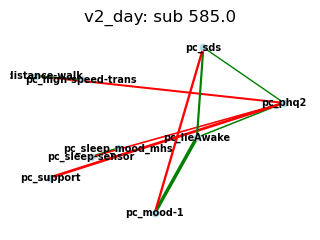

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


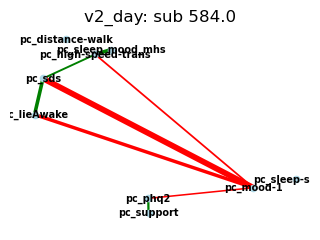

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


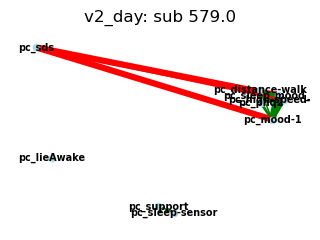

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


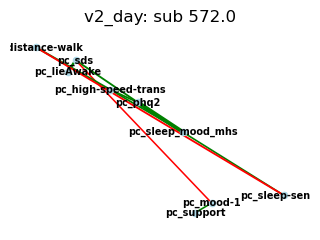

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


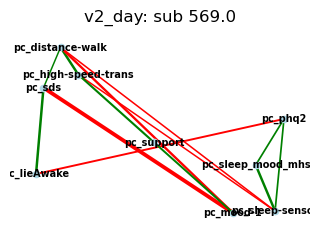

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


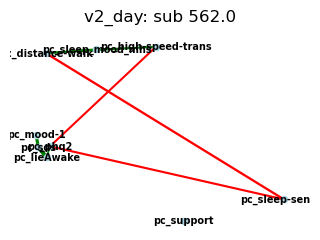

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


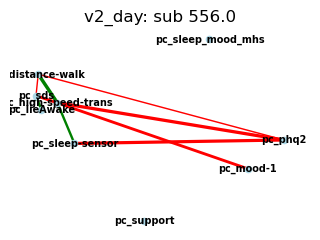

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


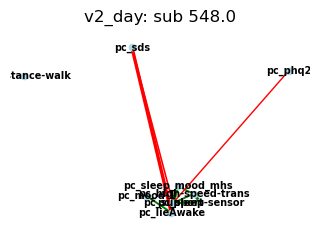

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


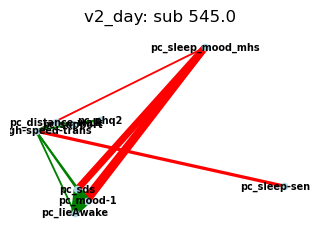

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


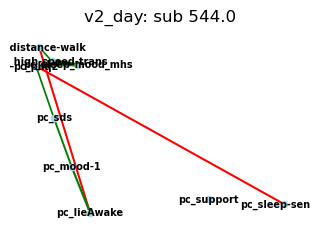

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


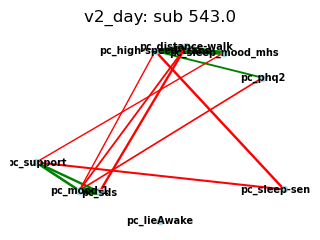

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


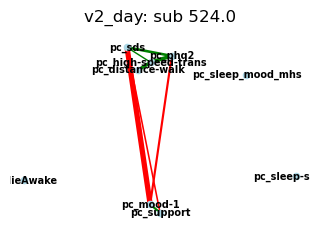

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


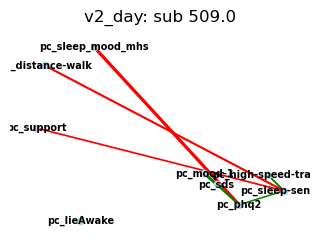

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


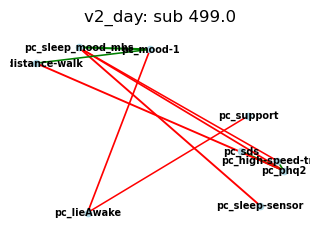

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


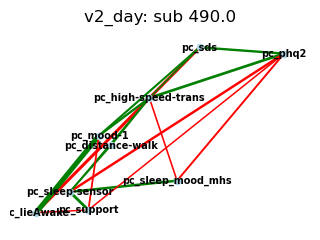

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


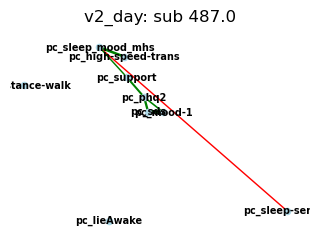

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


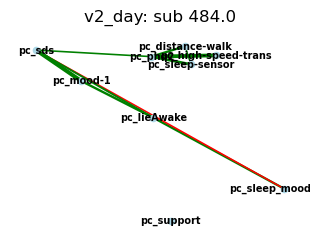

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


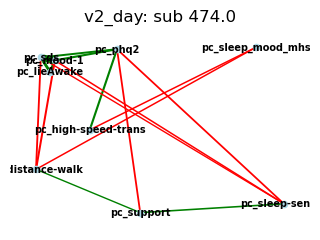

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


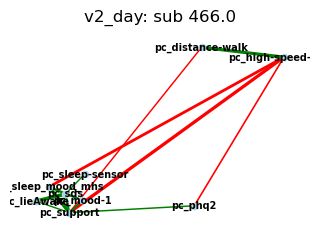

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


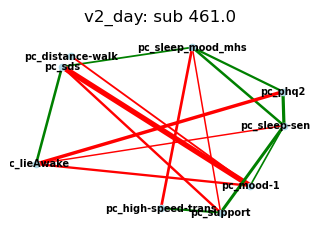

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


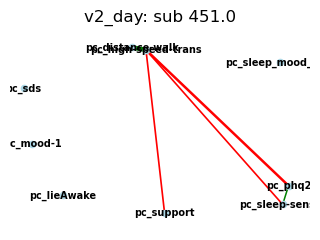

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


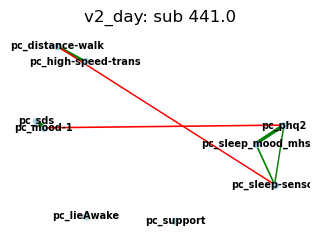

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


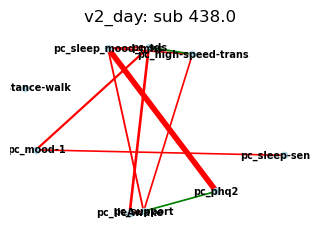

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


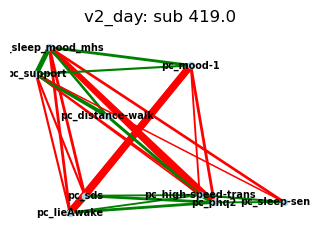

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


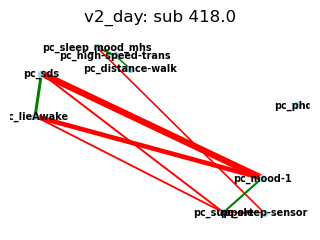

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


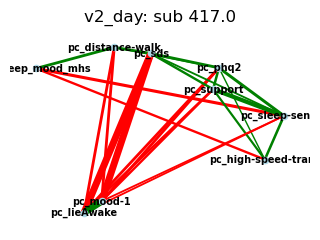

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


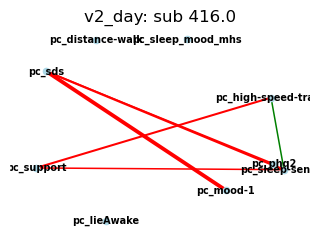

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


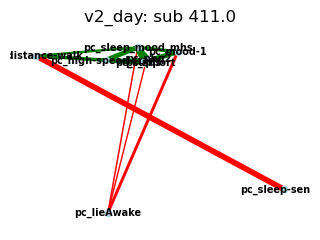

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


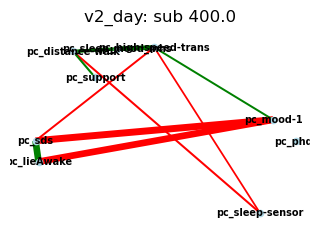

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


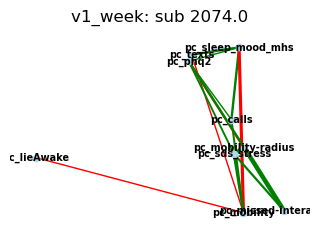

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


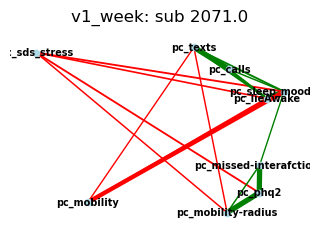

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


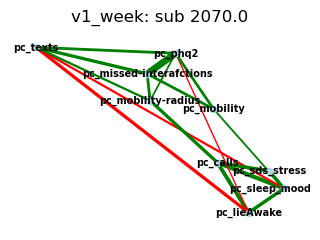

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


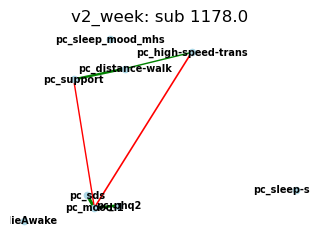

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


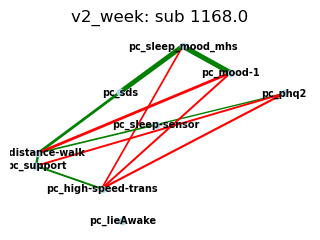

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


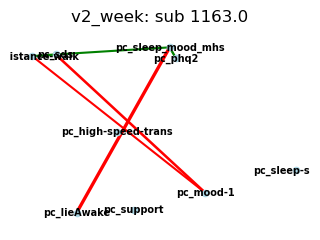

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


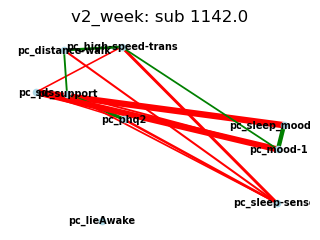

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


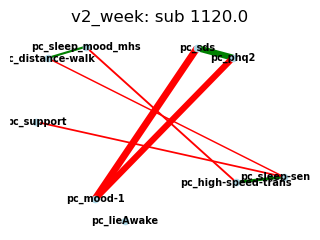

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


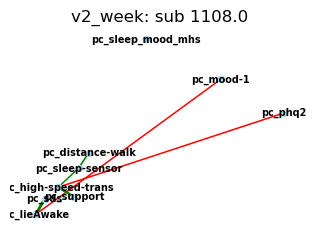

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


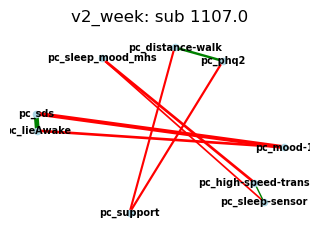

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


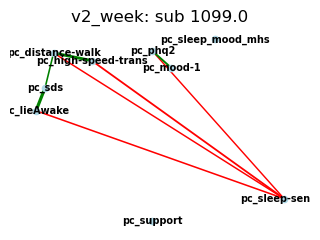

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


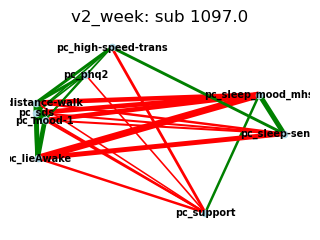

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


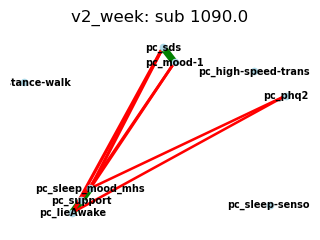

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


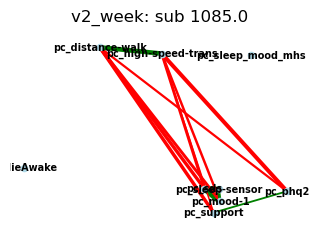

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


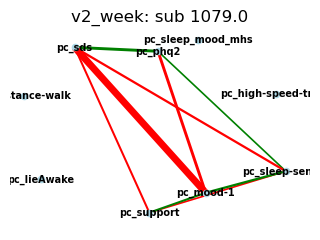

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


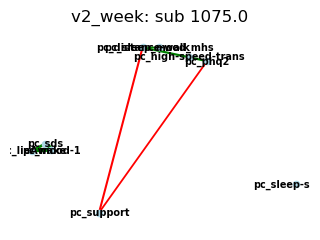

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


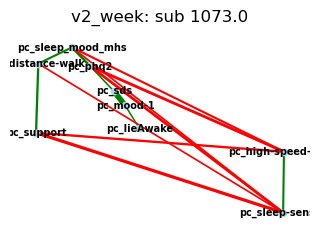

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


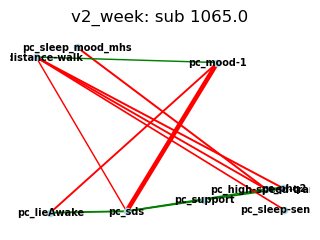

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


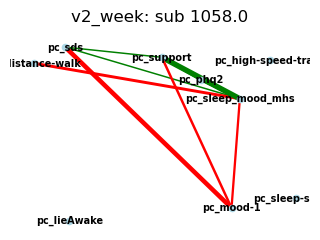

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


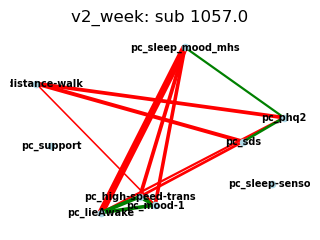

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


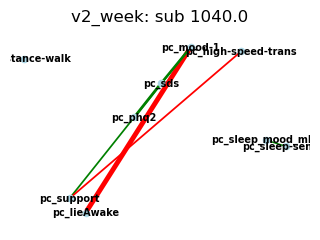

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


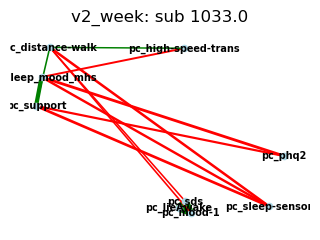

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


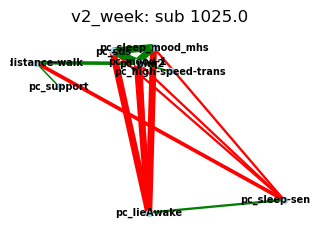

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


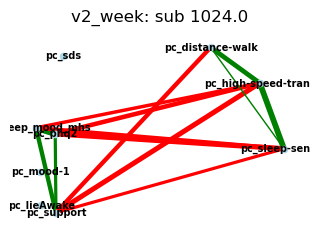

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


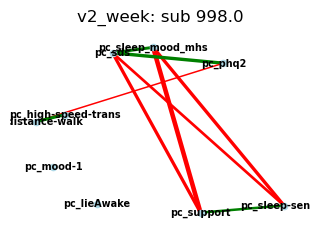

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


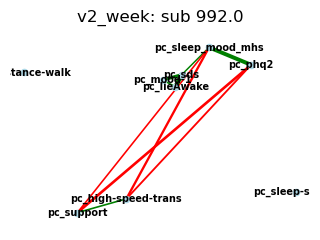

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


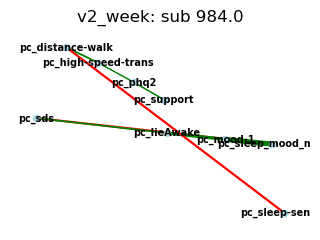

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


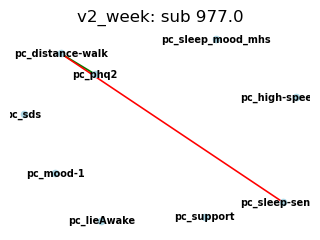

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


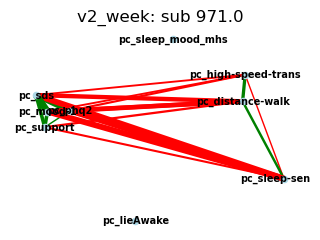

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


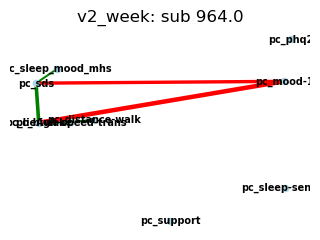

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


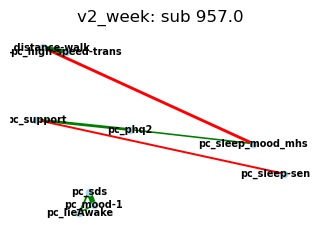

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


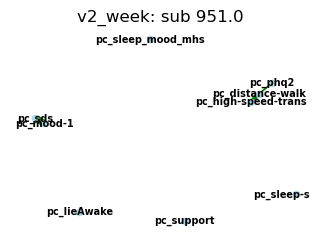

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


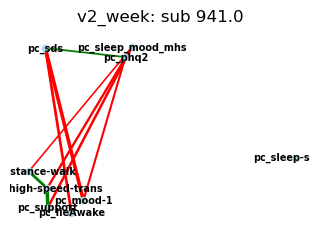

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


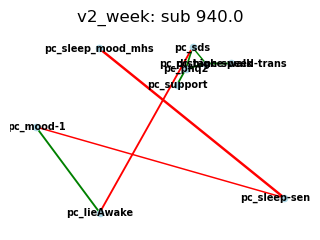

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


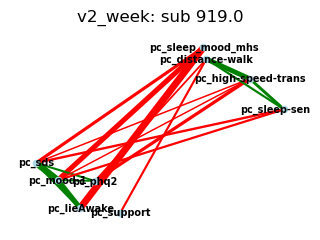

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


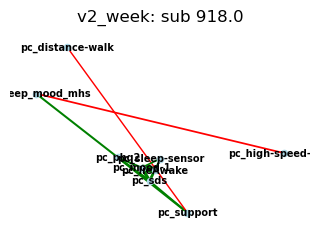

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


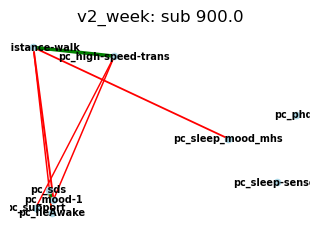

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


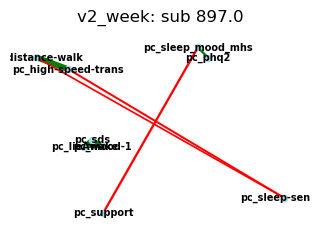

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


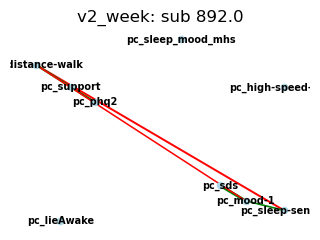

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


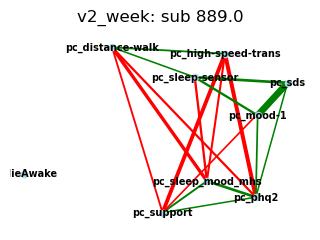

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


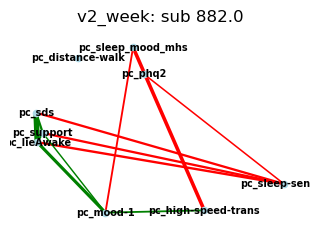

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


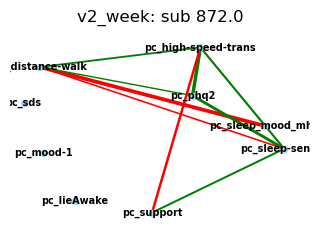

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


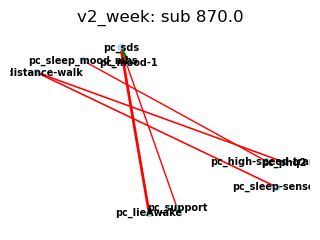

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


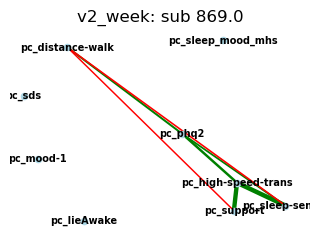

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


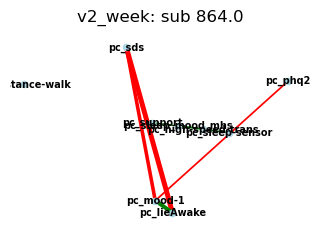

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


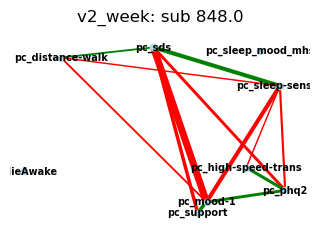

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


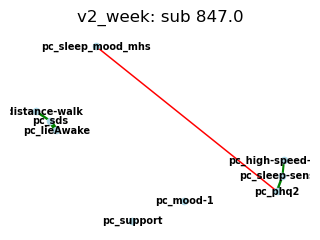

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


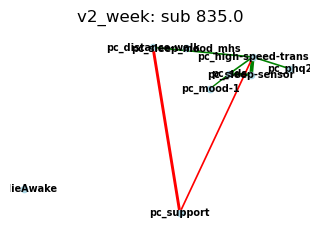

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


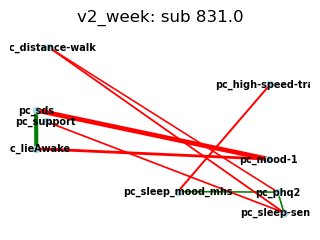

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


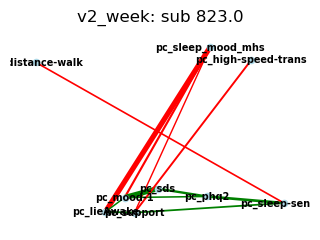

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


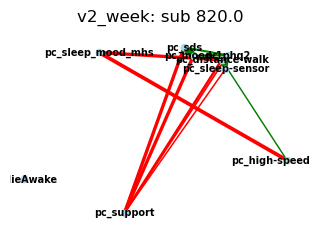

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


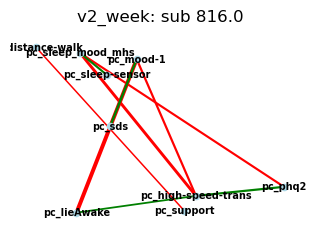

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


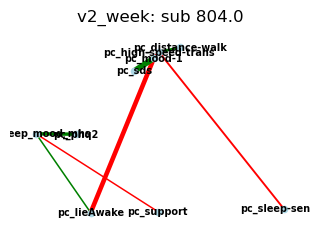

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


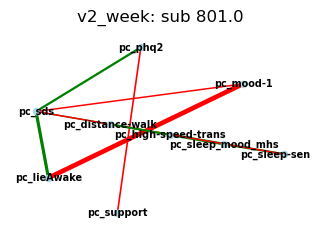

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


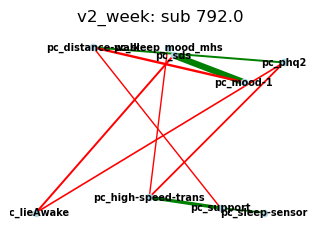

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


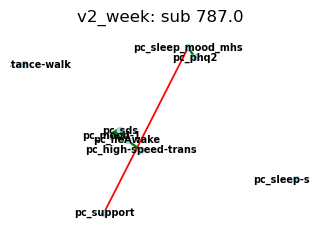

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


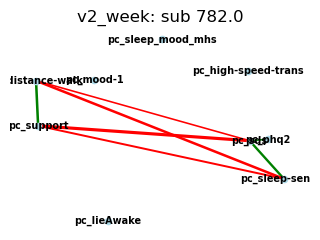

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


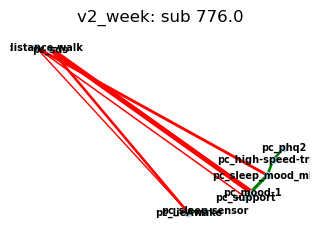

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


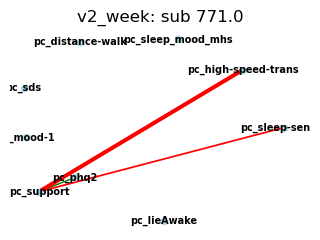

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


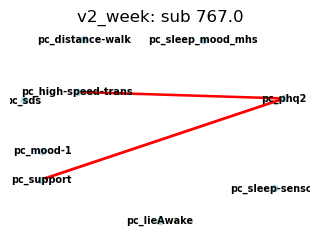

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


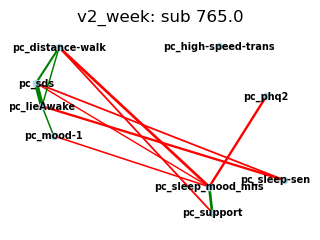

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


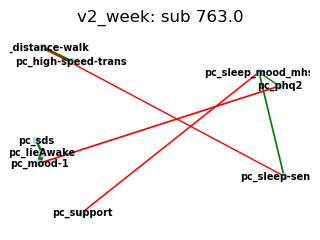

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


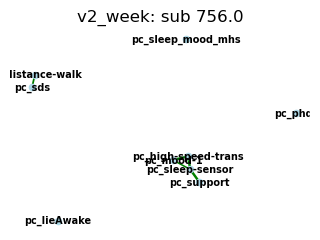

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


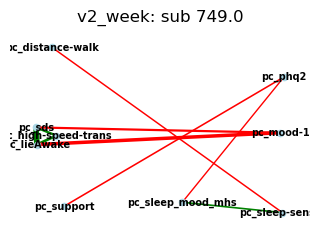

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


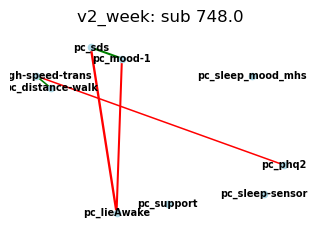

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


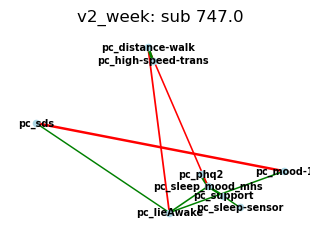

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


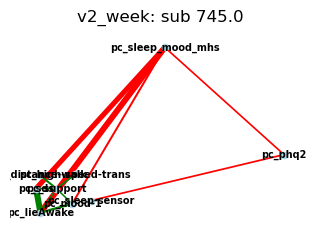

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


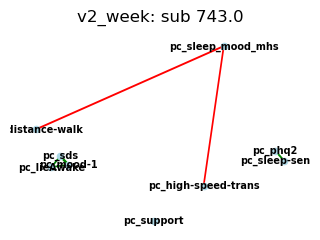

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


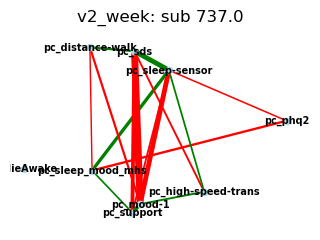

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


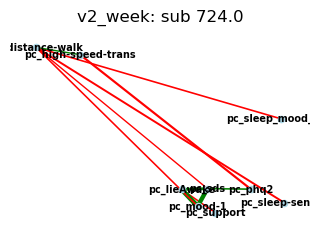

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


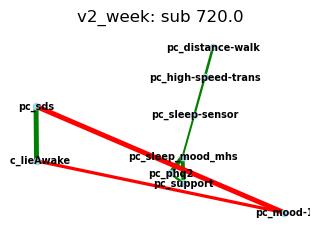

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


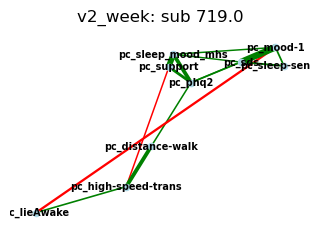

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


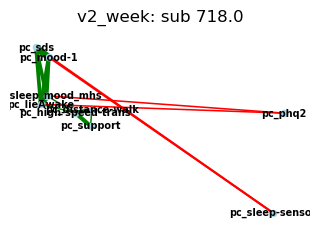

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


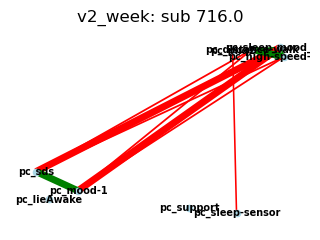

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


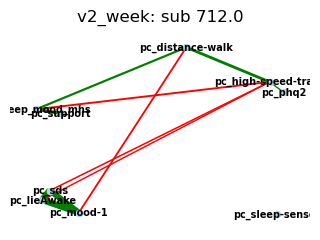

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


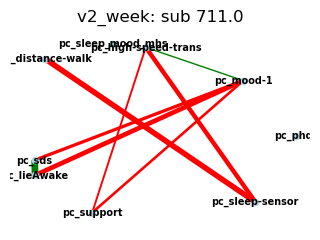

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


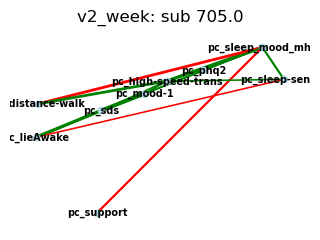

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


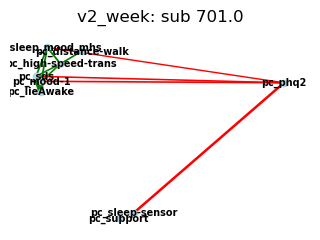

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


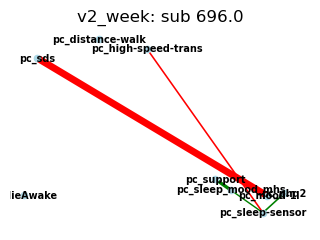

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


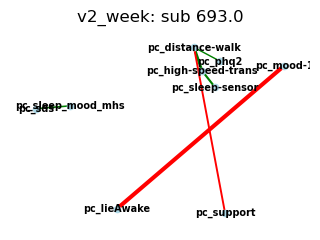

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


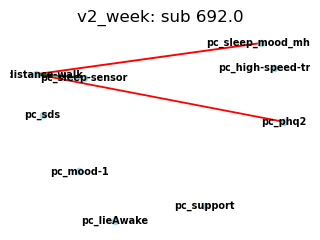

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


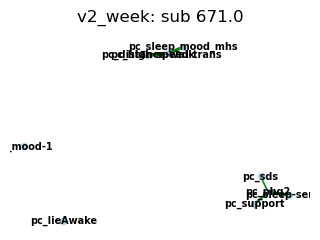

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


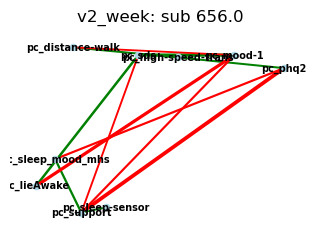

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


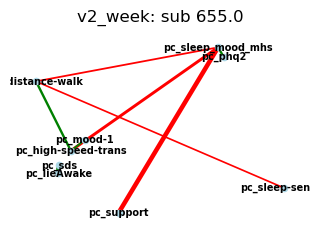

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


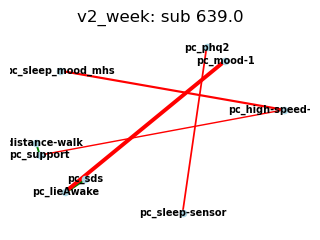

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


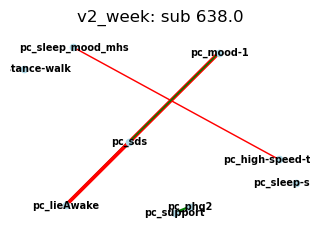

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


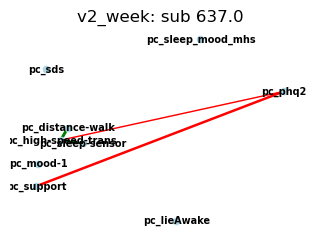

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


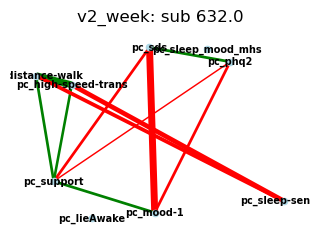

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


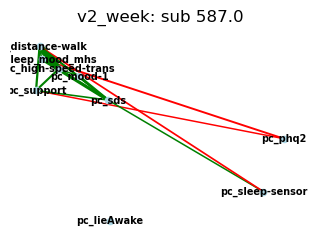

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


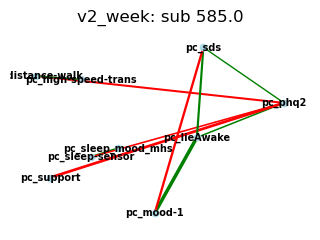

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


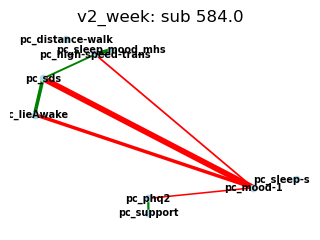

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


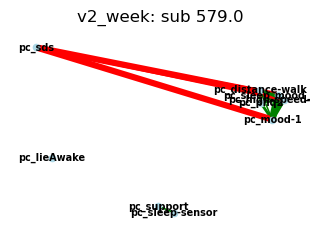

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


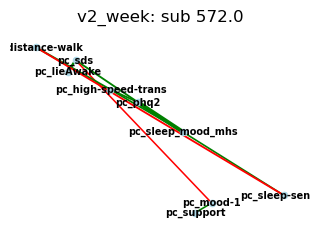

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


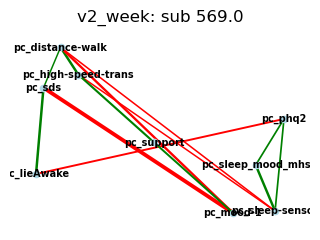

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


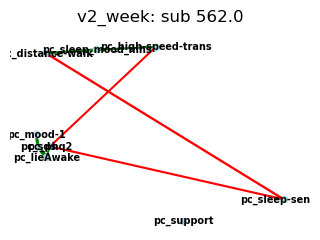

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


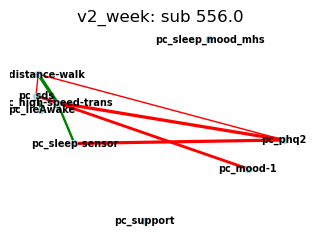

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


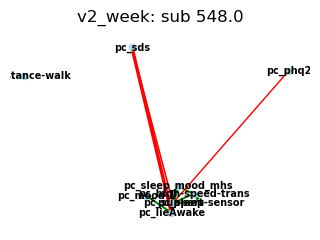

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


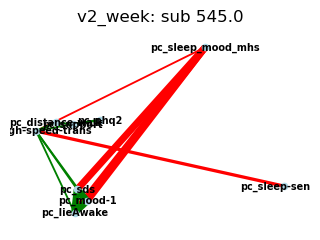

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


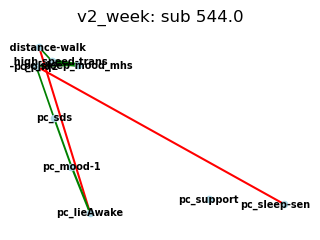

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


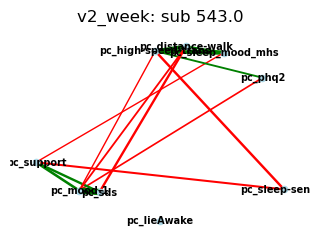

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


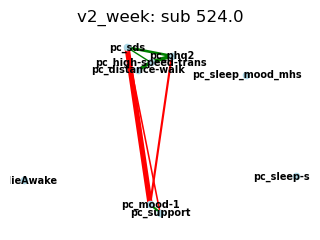

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


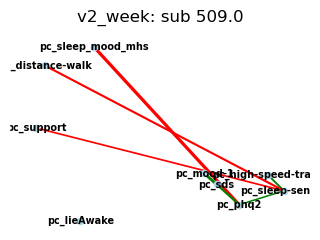

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


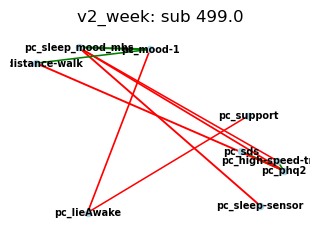

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


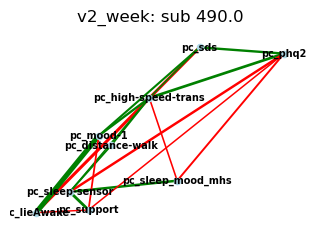

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


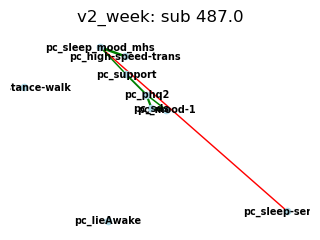

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


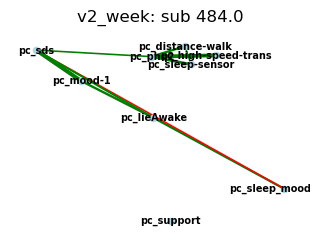

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


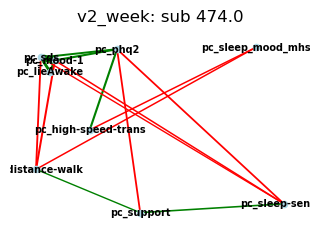

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


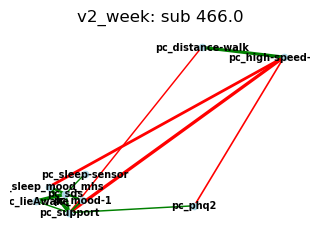

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


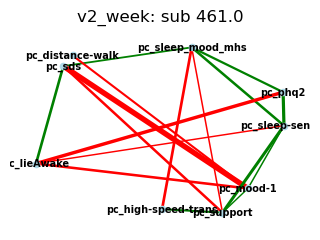

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


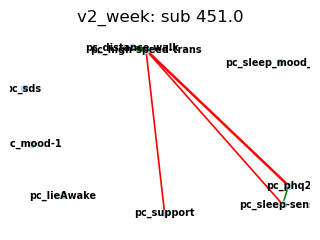

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


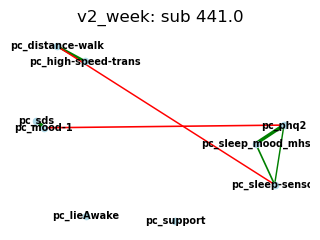

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


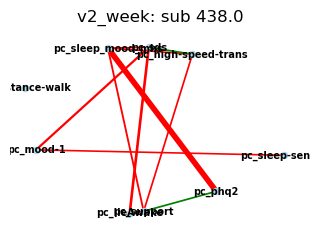

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


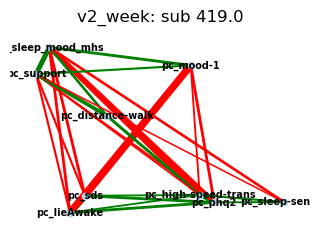

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


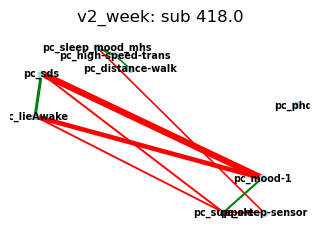

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


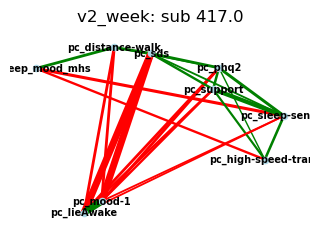

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


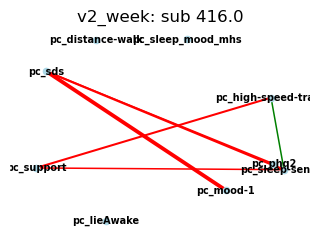

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


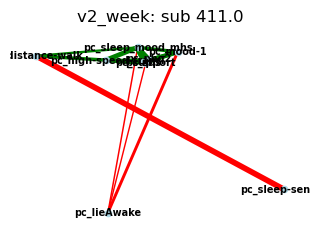

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone modelling etc notebooks copy/scripts/feature_selection.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


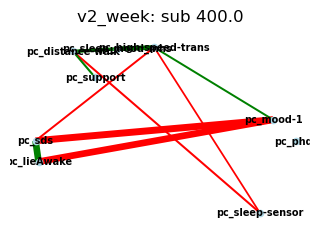

In [ ]:
############ Plot subjects' individual networks of PCs ############

# # Predefine fixed positions for nodes
# fixed_positions_v1_day = {
#     'pc_sleep-init-wake_mhs': (1, 3),
#     'pc_calls': (1, 2),
#     'pc_texts_communication': (2, 2),
#     'pc_sds_stress': (1, 4),
#     'pc_support': (2, 4),
#     'pc_mood': (1, 5),
#     'pc_mobility_radius': (3, 1),
#     'pc_mobility': (3, 2),
#     'pc_sleep-duration': (2, 3)
# }
# fixed_positions_v2_day = {
#     'pc_sleep-support_mhs': (1, 3),
#     'pc_sds_stress': (1, 4),
#     'pc_mood': (1, 5),
#     'pc_env_temp-humidity_var': (2, 2),
#     'pc_env_humidity_avg': (3, 2),
#     'pc_env_temp_avg': (3, 3),
#     'pc_dewpoint_var': (2, 3),
#     'pc_dewpoint_avg': (2, 4),
#     'pc_precip': (3, 4)
# }

# fixed_positions_v1_week = {
#     'pc_sleep-init-wake_mhs': (1, 3),
#     'pc_calls': (1, 2),
#     'pc_texts_communication': (2, 2),
#     'pc_sds_stress': (1, 4),
#     'pc_support': (2, 4),
#     'pc_mood': (1, 5),
#     'pc_mobility_radius': (3, 1),
#     'pc_mobility': (3, 2),
#     'pc_sleep-duration': (2, 3)
# }

# fixed_positions_v2_week = {
#     'pc_sleep-support_mhs': (1, 3),
#     'pc_sds_stress': (1, 4),
#     'pc_mood': (1, 5),
#     'pc_env_temp-humidity_var': (2, 2),
#     'pc_env_humidity_avg': (3, 2),
#     'pc_env_temp_avg': (3, 3),
#     'pc_dewpoint_var': (2, 3),
#     'pc_dewpoint_avg': (2, 4),
#     'pc_precip': (3, 4)
# }

for name, df in dfs_pca.items():
	count, count2, count3, count4 = 0, 0, 0, 0
	
	cols=[col for col in df.columns.to_list() if 'pc_' in col]
	for sub in df['num_id'].unique():
		sub_df = df[df['num_id']==sub]
		if sub_df.shape[0] > 8:
			corr_matrix = sub_df[cols].corr()
			if count<3:
				if 'v1_day' in name:
					fs.plot_network(corr_matrix, title=f'{name}: sub {sub}', threshold=0.2)
					count+=1
			if count2<3:
				if 'v1_week' in name:
					fs.plot_network(corr_matrix, title=f'{name}: sub {sub}', threshold=0.2)
					count2+=1
			if count3<3:
				if 'v2_day' in name:
					fs.plot_network(corr_matrix, title=f'{name}: sub {sub}', threshold=0.2)
					count2+=1
			if count4<3:
				if 'v2_week' in name:
					fs.plot_network(corr_matrix, title=f'{name}: sub {sub}', threshold=0.2)
					count2+=1


In [ ]:
for name in df_names: 
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_8wks_pca.csv'))
	display(df.head(10))

Unnamed: 0  day  num_id  change_cat  week  phq9_cat_mean  change_sum  \
0           0    0  2074.0         NaN   NaN            NaN         NaN   
1           1    2  2074.0         NaN   NaN            NaN         NaN   
2           2    3  2074.0         NaN   NaN            NaN         NaN   
3           3    4  2074.0         NaN   NaN            NaN         NaN   
4           4    5  2074.0         NaN   NaN            NaN         NaN   
5           5    6  2074.0         NaN   NaN            NaN         NaN   
6           6    7  2074.0         NaN   NaN            NaN         NaN   
7           7    8  2074.0         NaN   NaN            NaN         NaN   
8           8    9  2074.0         NaN   NaN            NaN         NaN   
9           9   10  2074.0         NaN   NaN            NaN         NaN   

   change_binary  phq9_mean  non-skew__aggregate_communication  ...  \
0            NaN        NaN                           0.000000  ...   
1            NaN        NaN                           0.000000  ...   
2            NaN        NaN                          -0.029234  ...   
3            NaN        NaN                           0.412574  ...   
4            NaN        NaN                          -0.300020  ...   
5            NaN        NaN                          -0.243012  ...   
6            NaN        NaN                          -0.271516  ...   
7            NaN        NaN                          -0.414035  ...   
8            NaN        NaN                           0.441078  ...   
9            NaN        NaN                           0.213048  ...   

   ord__mhs_5  pc_sleep_mood_mhs  pc_calls  pc_lieAwake  pc_texts   pc_phq2  \
0         0.0           0.039459 -0.941067    -0.162058 -3.786377 -0.096482   
1         0.0           0.039459 -0.730319    -0.166093 -1.336918 -4.061710   
2         1.0           0.039459 -0.705849     1.017370 -3.786377 -0.096482   
3         0.0           0.039459 -0.524515     0.208100  1.112540 -0.096482   
4         0.0           3.039423 -0.035073    -0.024577  1.112540 -0.096482   
5         0.0           3.057925 -0.035073    -0.024577  1.112540  9.160923   
6         0.0           3.039423 -0.823713     3.735635  3.561999 -0.096482   
7         0.0           3.039423 -0.164449     0.315609 -1.336918 -0.096482   
8         0.0           3.039423 -0.117342    -0.771039  1.112540 -0.096482   
9         0.0           3.039423 -0.542766    -0.755956  1.112540 -0.096482   

   pc_sds_stress  pc_missed-interafctions  pc_mobility-radius  pc_mobility  
0      -0.628069                 0.030012           -0.037235     0.545038  
1      -0.159145                 1.205086            2.962765     0.469287  
2      -0.628069                 0.030012           -0.037235     0.405674  
3      -0.628069                 0.030012           -0.037235     0.392413  
4      -0.028060                 0.030012           -0.037235     0.557243  
5      -0.028060                 0.030012            5.962765     0.557243  
6      -0.628069                 0.030012           -0.037235    -1.702061  
7      -0.159145                 0.030012           -0.037235     0.557243  
8      -0.628069                 0.030012           -0.037235     0.100798  
9      -0.628069                 0.030012           -0.037235    -1.972861  

[10 rows x 41 columns]

Unnamed: 0  day  num_id  change_cat  week  phq9_cat_mean  change_sum  \
0           0    0  1178.0         0.0  10.0            3.0        -4.0   
1           1   39  1178.0         0.0  10.0            3.0        -4.0   
2           2   40  1178.0         0.0  10.0            3.0        -4.0   
3           3   41  1178.0         0.0  10.0            3.0        -4.0   
4           4   42  1178.0         0.0  10.0            3.0        -4.0   
5           5   43  1178.0         0.0  10.0            3.0        -4.0   
6           6   44  1178.0         0.0  10.0            3.0        -4.0   
7           7   45  1178.0         0.0  10.0            3.0        -4.0   
8           8   46  1178.0         0.0  10.0            3.0        -4.0   
9           9   47  1178.0         0.0  10.0            3.0        -4.0   

   change_binary  phq9_mean  non-skew__cloud_cover_mean  ...  ord__mhs_5  \
0            0.0       17.0                1.635503e-16  ...         0.0   
1            0.0       17.0               -1.314347e+00  ...         0.0   
2            0.0       17.0                1.425675e+00  ...         0.0   
3            0.0       17.0                3.355587e-01  ...         0.0   
4            0.0       17.0               -1.049184e+00  ...         0.0   
5            0.0       17.0               -1.255422e+00  ...         0.0   
6            0.0       17.0               -1.078647e+00  ...         0.0   
7            0.0       17.0               -1.078647e+00  ...         0.0   
8            0.0       17.0               -1.343810e+00  ...         0.0   
9            0.0       17.0               -7.545578e-01  ...         0.0   

   pc_sleep_mood_mhs   pc_phq2  pc_lieAwake    pc_sds  pc_high-speed-trans  \
0          -0.292762 -1.782810     0.001009  0.063757             1.922946   
1          -0.292762 -1.782810     0.001009  0.063757             1.922946   
2          -0.292762 -1.782810     0.001009  0.063757            -0.958345   
3          -0.292762 -0.530611     0.001009  7.682817            -0.958345   
4          -0.292762 -1.782810     0.001009  0.063757             1.922946   
5          -0.292762  0.666473     0.001009  0.063757             1.922946   
6          -0.292762 -1.782810     0.001009  0.063757             1.922946   
7          -0.292762 -1.782810     0.001009  0.063757            -0.958345   
8          -0.292762 -2.998266     0.001009  0.063757            -0.958345   
9          -0.292762 -1.782810     0.001009  0.063757            -0.958345   

   pc_distance-walk  pc_sleep-sensor  pc_support  pc_mood-1  
0          0.346313         0.189285    0.064700  -0.111775  
1          0.346313         0.189285   -2.509383  -0.111775  
2          1.043833        -1.684866   -0.381929  -0.111775  
3         -0.622520         0.783899   -1.231575   0.888225  
4          0.346313         0.189285   -3.483973  -0.111775  
5          0.346313         0.189285   -3.229079  -0.111775  
6          0.346313         0.189285   -3.738867  -0.111775  
7          0.200254        -2.154218   -4.331950  -0.111775  
8         -1.748116        -1.337428   -2.845904  -0.111775  
9         -0.236467        -1.014578   -3.610585  -0.111775  

[10 rows x 49 columns]

Unnamed: 0   day  num_id  change_cat  week  phq9_cat_mean  change_sum  \
0           0   0.0  2074.0         NaN   NaN            NaN         NaN   
1           1  10.0  2074.0         NaN   NaN            NaN         NaN   
2           2  11.0  2074.0         NaN   NaN            NaN         NaN   
3           3  12.0  2074.0         NaN   NaN            NaN         NaN   
4           4  13.0  2074.0         NaN   NaN            NaN         NaN   
5           5  14.0  2074.0         NaN   NaN            NaN         NaN   
6           6  15.0  2074.0         NaN   NaN            NaN         NaN   
7           7  16.0  2074.0         NaN   NaN            NaN         NaN   
8           8  17.0  2074.0         NaN   NaN            NaN         NaN   
9           9  18.0  2074.0         NaN   NaN            NaN         NaN   

   change_binary  phq9_mean  non-skew__aggregate_communication  ...  \
0            NaN        NaN                           0.000000  ...   
1            NaN        NaN                           0.213048  ...   
2            NaN        NaN                           1.980281  ...   
3            NaN        NaN                           0.911390  ...   
4            NaN        NaN                          -0.542302  ...   
5            NaN        NaN                          -0.613561  ...   
6            NaN        NaN                           0.469582  ...   
7            NaN        NaN                          -0.556554  ...   
8            NaN        NaN                          -0.585058  ...   
9            NaN        NaN                          -0.399783  ...   

   ord__mhs_5  pc_sleep_mood_mhs  pc_calls  pc_lieAwake  pc_texts    pc_phq2  \
0         0.0           0.039459 -0.941067    -0.162058 -3.756941  -0.096482   
1         0.0           3.039423 -0.823713     3.735635  3.591431  -0.096482   
2         0.0           3.039423 -0.323097     2.517413  1.141974  -0.096482   
3         0.0           3.039423 -0.301175    -0.200705  6.040889  -0.096482   
4         0.0           3.039423  0.106812     0.231403  6.040889  11.241868   
5         0.0           3.039423 -0.542766    -0.755956  1.141974  -0.096482   
6         0.0           3.039423  0.007963    -0.091217  3.591431  -0.096482   
7         0.0           3.039423 -0.321159     0.243574 -1.307483  -0.096482   
8         0.0           3.039423 -0.698967     1.490164 -1.307483  -0.096482   
9         0.0           3.039423 -0.204824     0.149230 -1.307483  -0.096482   

   pc_sds_stress  pc_missed-interafctions  pc_mobility-radius  pc_mobility  
0      -0.628069                 0.030012           -0.037235     0.545038  
1      -0.628069                 0.030012           -0.037235    -1.702061  
2      -0.628069                 0.030012           -0.037235    -1.972001  
3      -0.628069                 0.030012           -0.037235    -0.964516  
4      -0.159145                 1.205086            3.962765    -1.562928  
5      -0.628069                 0.030012           -0.037235    -1.972861  
6      -0.628069                 0.030012           -0.037235    -0.895113  
7      -0.628069                 0.030012           -0.037235    -1.550854  
8      -0.159145                 0.030012           -0.037235    -1.969426  
9      -0.159145                 0.030012           -0.037235     0.557243  

[10 rows x 41 columns]

Unnamed: 0   day  num_id  change_cat  week  phq9_cat_mean  change_sum  \
0           0   0.0  1178.0         0.0  10.0            3.0        -4.0   
1           1  39.0  1178.0         0.0  10.0            3.0        -4.0   
2           2  40.0  1178.0         0.0  10.0            3.0        -4.0   
3           3  41.0  1178.0         0.0  10.0            3.0        -4.0   
4           4  42.0  1178.0         0.0  10.0            3.0        -4.0   
5           5  43.0  1178.0         0.0  10.0            3.0        -4.0   
6           6  44.0  1178.0         0.0  10.0            3.0        -4.0   
7           7  45.0  1178.0         0.0  10.0            3.0        -4.0   
8           8  46.0  1178.0         0.0  10.0            3.0        -4.0   
9           9  47.0  1178.0         0.0  10.0            3.0        -4.0   

   change_binary  phq9_mean  non-skew__cloud_cover_mean  ...  ord__mhs_5  \
0            0.0       17.0                1.635503e-16  ...         0.0   
1            0.0       17.0               -1.314347e+00  ...         0.0   
2            0.0       17.0                1.425675e+00  ...         0.0   
3            0.0       17.0                3.355587e-01  ...         0.0   
4            0.0       17.0               -1.049184e+00  ...         0.0   
5            0.0       17.0               -1.255422e+00  ...         0.0   
6            0.0       17.0               -1.078647e+00  ...         0.0   
7            0.0       17.0               -1.078647e+00  ...         0.0   
8            0.0       17.0               -1.343810e+00  ...         0.0   
9            0.0       17.0               -7.545578e-01  ...         0.0   

   pc_sleep_mood_mhs   pc_phq2  pc_lieAwake    pc_sds  pc_high-speed-trans  \
0          -0.292762 -1.736000     0.001009  0.063757             1.922946   
1          -0.292762 -1.736000     0.001009  0.063757             1.922946   
2          -0.292762 -1.736000     0.001009  0.063757            -0.958345   
3          -0.292762 -0.480485     0.001009  7.682817            -0.958345   
4          -0.292762 -1.736000     0.001009  0.063757             1.922946   
5          -0.292762  0.713229     0.001009  0.063757             1.922946   
6          -0.292762 -1.736000     0.001009  0.063757             1.922946   
7          -0.292762 -1.736000     0.001009  0.063757            -0.958345   
8          -0.292762 -2.950315     0.001009  0.063757            -0.958345   
9          -0.292762 -1.736000     0.001009  0.063757            -0.958345   

   pc_distance-walk  pc_sleep-sensor  pc_support  pc_mood-1  
0          0.346313         0.189285    0.064700  -0.111775  
1          0.346313         0.189285   -2.509383  -0.111775  
2          1.043833        -1.684866   -0.381929  -0.111775  
3         -0.622520         0.783899   -1.231575   0.888225  
4          0.346313         0.189285   -3.483973  -0.111775  
5          0.346313         0.189285   -3.229079  -0.111775  
6          0.346313         0.189285   -3.738867  -0.111775  
7          0.200254        -2.154218   -4.331950  -0.111775  
8         -1.748116        -1.337428   -2.845904  -0.111775  
9         -0.236467        -1.014578   -3.610585  -0.111775  

[10 rows x 49 columns]

In [ ]:
y_cols = ['change_cat','change_sum','change_binary','phq9_mean','phq9_cat_mean']

for name in df_names: 
	
	df_base=pd.read_csv(os.path.join(brighten_dir,  f'{name}_Xy_long_trainval.csv'))

	baseline_cols_present = [col for col in df_base.columns if any(item in col for item in y_cols+['dt','num_id'])]

	print(name, 'y cols present:', baseline_cols_present)

	




v1_day y cols present: ['dt', 'num_id', 'change_cat', 'phq9_cat_mean', 'change_sum', 'change_binary', 'phq9_mean']
v2_day y cols present: ['dt', 'num_id', 'change_cat', 'phq9_cat_mean', 'change_sum', 'change_binary', 'phq9_mean']
v1_week y cols present: ['dt', 'num_id', 'change_cat', 'phq9_cat_mean', 'change_sum', 'change_binary', 'phq9_mean']
v2_week y cols present: ['dt', 'num_id', 'change_cat', 'phq9_cat_mean', 'change_sum', 'change_binary', 'phq9_mean']


In [ ]:
for name in df_names: 
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_8wks_pca.csv'))
	print(df.columns.to_list())

['Unnamed: 0', 'day', 'num_id', 'change_cat', 'week', 'phq9_cat_mean', 'change_sum', 'change_binary', 'phq9_mean', 'non-skew__aggregate_communication', 'non-skew__call_count', 'non-skew__call_duration', 'non-skew__interaction_diversity', 'non-skew__missed_interactions', 'non-skew__sms_count', 'non-skew__sms_length', 'bc__mobility', 'bc__mobility_radius', 'yj__sds_1', 'ord__sds_2', 'yj__sds_3', 'ord__stress', 'ord__support', 'ord__sleep_1', 'ord__sleep_2', 'ord__sleep_3', 'yj__mood_1', 'ord__mhs_1', 'ord__mhs_2', 'ord__mhs_3', 'ord__mhs_4', 'ord__mhs_5', 'pc_sleep_mood_mhs', 'pc_calls', 'pc_lieAwake', 'pc_texts', 'pc_phq2', 'pc_sds_stress', 'pc_missed-interafctions', 'pc_mobility-radius', 'pc_mobility']
['Unnamed: 0', 'day', 'num_id', 'change_cat', 'week', 'phq9_cat_mean', 'change_sum', 'change_binary', 'phq9_mean', 'non-skew__cloud_cover_mean', 'non-skew__dew_point_mean', 'non-skew__humidity_mean', 'non-skew__temp_mean', 'yj__dew_point_IQR', 'non-skew__humidity_IQR', 'non-skew__temp_IQ

In [ ]:
### Sensor PCA -> mood

from sklearn.model_selection import train_test_split

y_cols =['phq2'] 
models = {
	'HistGradientBoostingRegressor': [HistGradientBoostingRegressor()]
}

model_dict_slopeint={}
for name in df_names: 
	model_dict_slopeint[name] = {}
	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_8wks_pca.csv'))
	#df_base=pd.read_csv(os.path.join(brighten_dir,  f'{name}_Xy_imputed_long_trainval.csv'))

	# baseline_cols_present = [col for col in df_base.columns if any(item in col for item in baseline_cols+['dt','num_id']+y_cols)]
	# df_base = df_base[baseline_cols_present]
	# df_merged = pd.merge(df, df_base, on=['num_id','day'])

	for y_col in ['pc_phq2']:
		model_dict_slopeint[name][y_col]={}
		for length_type in ['8wks']:
			for model_name in models:
				model_dict_slopeint[name][y_col][length_type]={}
				results_df = []
				# Xy_df = pd.merge(df_merged, y_df[['num_id', y_col]], on='num_id', how='outer')
				# Xy_df=Xy_df.dropna(subset=y_col)
				
				# print(f'X has {X.shape[0]} observations, {X.shape[1]} features.')
				#display(X)
				# non_numeric_cols = X.select_dtypes(include=['object']).columns
				# if len(non_numeric_cols) > 0:
				# 	print("Non-numeric columns found:", non_numeric_cols)
				# 	print(X[non_numeric_cols].head())
				
				# Inputs
				# groups = Xy_df['num_id']
				# gkf = GroupKFold(n_splits=5)
				# X2 = X.drop(columns='num_id').copy()  # drop group id from features for group KFold
				#print(([col for col in X2.columns if X2.isna().sum()[col]<200]))

				for sub, sub_df in df.groupby('num_id'):
					if len(sub_df)>50:
						y = sub_df[y_col]
						X_df = sub_df[[col for col in sub_df.columns if 'pc_' in col and y_col not in col]]

						model_dict_slopeint[name][y_col][length_type][model_name] = {}
						model_dict_slopeint[name][y_col][length_type][model_name][sub] = {}
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['model']=[]
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['X_test']=[]
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['y_pred']=[]
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['y_test']=[]
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['r2_scores']=[]
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['mae']=[]
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['corr']=[]



						X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3)

						model = models[model_name][0]
						# if y_col in ['change_cat','change_binary']:
						# 	model= models[model_name][1]
						model.fit(X_train, y_train)
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['model'].append(model)

						y_pred = np.round(model.predict(X_test)).astype(int) #ordinal Y
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['y_pred'] = y_pred
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['y_test'] = y_test
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['X_test'].append(X_test)

						r2 = r2_score(y_test, y_pred)
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['r2_scores'].append(r2)
						
						mae = mean_absolute_error(y_test, y_pred)
						model_dict_slopeint[name][y_col][length_type][model_name][sub]['mae'].append(mae)

						y_range = round(y.min(), 1) - round(y.max(), 1)
						mae_average = round(np.mean(model_dict_slopeint[name][y_col][length_type][model_name][sub]['mae']), 4)
						mae_percentage = mae_average/y_range


						results_df.append([sub, round(np.mean(model_dict_slopeint[name][y_col][length_type][model_name][sub]['r2_scores']), 4), mae_average, mae_percentage])


						print(f"Sub {sub}: {y_col} type {length_type} -- mean R²: {round(np.mean(model_dict_slopeint[name][y_col][length_type][model_name][sub]['r2_scores']), 4)}, mean MAE: {round(np.mean(model_dict_slopeint[name][y_col][length_type][model_name][sub]['mae']), 4)} of {round(y.min(), 1)}-{round(y.max(), 1)}")

				results_df = pd.DataFrame(results_df, columns=['Subject', 'R2 Mean', 'MAE', 'MAE Percentage'])
				results_df.to_csv(os.path.join(brighten_dir, f'{name}_{length_type}_bySub_predicting-{y_col}_pca.csv'))
			


Sub 416.0: pc_phq2 type 8wks -- mean R²: -15.4412, mean MAE: 1.1561 of -4.2-0.7
Sub 418.0: pc_phq2 type 8wks -- mean R²: -0.1015, mean MAE: 1.7263 of -4.2-5.6
Sub 438.0: pc_phq2 type 8wks -- mean R²: -0.4496, mean MAE: 0.9854 of -4.2-1.9
Sub 441.0: pc_phq2 type 8wks -- mean R²: -0.1603, mean MAE: 1.9884 of -4.2-4.3
Sub 466.0: pc_phq2 type 8wks -- mean R²: -3.5699, mean MAE: 1.3736 of -3.0-5.6
Sub 474.0: pc_phq2 type 8wks -- mean R²: -0.2617, mean MAE: 1.4153 of -3.0-3.1
Sub 484.0: pc_phq2 type 8wks -- mean R²: 0.0275, mean MAE: 1.017 of -1.8-0.7
Sub 487.0: pc_phq2 type 8wks -- mean R²: -0.0025, mean MAE: 1.5852 of -4.2-3.1
Sub 499.0: pc_phq2 type 8wks -- mean R²: -0.1693, mean MAE: 3.0611 of -3.0-5.6
Sub 544.0: pc_phq2 type 8wks -- mean R²: 0.3609, mean MAE: 1.6224 of -4.2-5.6
Sub 548.0: pc_phq2 type 8wks -- mean R²: -0.7452, mean MAE: 1.4192 of -4.2-5.6
Sub 556.0: pc_phq2 type 8wks -- mean R²: 0.1657, mean MAE: 1.7075 of -4.2-5.6
Sub 562.0: pc_phq2 type 8wks -- mean R²: 0.2884, mean M

In [ ]:
import plotly.express as px
for name in df_names: 
	for y_col in ['pc_phq2']:
		for length_type in ['8wks']:
			for model_name in models:
				results_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_{length_type}_bySub_predicting-{y_col}_pca.csv'))
				results_df = results_df.dropna()
				fig = px.bar(results_df, x='Subject', y='R2 Mean', title=f'R2 of {name} over {length_type} by Subject Predicting {y_col} with PCA inputs')
				fig.show()
				


In [ ]:
import plotly.express as px
for name in df_names: 
	for y_col in ['pc_phq2']:
		for length_type in ['8wks']:
			for model_name in models:
				results_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_{length_type}_bySub_predicting-{y_col}_pca.csv'))
				results_df = results_df.dropna()
				fig = px.bar(results_df, x='Subject', y='MAE Percentage', title=f'MAE Percentage of {name} over {length_type} by Subject Predicting {y_col} with PCA inputs')
				fig.show()

In [ ]:

pc_symptom_matrices_df_dict = {}
pc_flattened_matrices_df_dict = {}
pc_sensor_matrices_df_dict = {}
pc_target_matrices_df_dict = {}
pc_flattened_sensor_df_dict = {}
pc_flattened_target_df_dict = {}	

correlated_weather_cols = ['non-skew__humidity_mean', 'non-skew__humidity_median', 'non-skew__cloud_cover_mean', 'non-skew__cloud_cover_median']

#### Take the average of each subject's symptom correlation and use it to make clusters of variables

# Create dicts of all subjects' correlation matrices
for name in df_names:
	print(f'\n\nDATAFRAME: {name}')

	df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_8wks_pca.csv'))
	df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
	
	# Take out y columns
	y_cols = ['pc_phq2']
	df = df.drop(columns=[col for col in df.columns if any(item in col for item in y_cols)])

	# Make symptom/flattened dicts for all cols
	ignore_cols = [col for col in df.columns if "pc_" not in col]

	keep_columns = list(set(df.columns.to_list()) - set(ignore_cols))
	print(keep_columns)
	print(f"All cols for {name}:")
	symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=0)
	

	# Assign dicts to nested dict
	pc_symptom_matrices_df_dict[name] = symptom_matrix_dict
	pc_flattened_matrices_df_dict[name] = flattened_matrix_dict


	# Make separate symptom/flattened dicts for target cols vs. sensor cols
	target_cols = ['pc_phq2']
	print(f"Sensor cols for {name}:")
	sensor_cols = [col for col in df.columns if 'pc_' in col and col not in target_cols]
	print(sensor_cols)
	nonsensor_cols = [col for col in df.columns if col not in sensor_cols]
	sensor_matrices_dict, flattened_sensor_dict = fs.make_symptom_matrices(df, ignore_cols+nonsensor_cols, num_to_plot=0)
	target_df = df.copy().drop(columns=[col for col in df.columns if col not in target_cols and 'num_id' not in col])
	print(f"Target cols for {name}:")

	target_matrices_dict, flattened_target_dict = fs.make_symptom_matrices(target_df, ignore_cols, num_to_plot=0)

	#Assign sensor/target dicts to nested dict
	pc_sensor_matrices_df_dict[name] = sensor_matrices_dict
	pc_target_matrices_df_dict[name] = target_matrices_dict
	pc_flattened_sensor_df_dict[name] = flattened_sensor_dict
	pc_flattened_target_df_dict[name] = flattened_target_dict






DATAFRAME: v1_day
['pc_sds_stress', 'pc_support', 'pc_sleep_mood_mhs', 'pc_calls', 'pc_missed-interafctions', 'pc_mood1', 'pc_texts', 'pc_mobility']
All cols for v1_day:
In df there are 75 subjects.
75 subs with symptom matrices
75 filled condensed arrays
Sensor cols for v1_day:
['pc_sleep_mood_mhs', 'pc_calls', 'pc_texts', 'pc_sds_stress', 'pc_missed-interafctions', 'pc_mood1', 'pc_support', 'pc_mobility']
In df there are 75 subjects.
75 subs with symptom matrices
75 filled condensed arrays
Target cols for v1_day:
In df there are 75 subjects.
0 subs with symptom matrices
0 filled condensed arrays


DATAFRAME: v2_day
['pc_humidity', 'pc_support', 'pc_sleep_mood_mhs', 'pc_lieAwake', 'pc_sds', 'pc_sleepHours', 'pc_high-speed-trans', 'pc_distance-walk']
All cols for v2_day:
In df there are 117 subjects.
117 subs with symptom matrices
117 filled condensed arrays
Sensor cols for v2_day:
['pc_sleep_mood_mhs', 'pc_lieAwake', 'pc_sds', 'pc_high-speed-trans', 'pc_distance-walk', 'pc_sleepHour

In [ ]:
#num_id	change_sum	week	change_binary	phq9_mean	phq9_bin
#v1_phq9_sum_change.csv

# SENSOR AND SURVEY 
# Network based statistics for high phq9 vs. low phq9 -- OVER WHOLE STUDY
import bct 
from bct import nbs
from scipy import stats

significance_level = 0.05

for v in ['v1','v2']:
	print(v)
	phq9_stats = pd.read_csv(os.path.join(brighten_dir, f'{v}_phq9_sum_change.csv'))

	depressed = phq9_stats[phq9_stats['phq9_bin']==1]['num_id']
	print(f'There are {len(depressed)} subs in the depressed group')
	depressed_present = [sub for sub in depressed if sub in pc_symptom_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(depressed_present)} subs present from the depressed group')
	X = {key: pc_symptom_matrices_df_dict[f'{v}_day'][key] for key in depressed_present}
	x_arr = np.stack([df.values for df in X.values()], axis=-1)
	print(f'x_arr shape {x_arr.shape}')
		
	nondepressed = phq9_stats[phq9_stats['phq9_bin']==0]['num_id']
	print(f'There are {len(depressed)} subs in the nondepressed group')
	nondepressed_present = [sub for sub in nondepressed if sub in pc_symptom_matrices_df_dict[f'{v}_day']]
	print(f'There are {len(nondepressed_present)} subs present from the nondepressed group')
	y = {key: pc_symptom_matrices_df_dict[f'{v}_day'][key] for key in nondepressed_present}
	y_arr = np.stack([df.values for df in y.values()], axis=-1)
	print(f'y_arr shape {y_arr.shape}')

	degf = len(X) + len(y) - 2
	print(f'The degrees of freedom are: {degf}')

	t_thresh = stats.t.ppf(1-significance_level, degf)
	print(f'The critical t value is {round(t_thresh, 2)}')

	pval, adj, null = nbs.nbs_bct(x_arr, y_arr, thresh=t_thresh, verbose=False)
	print(pval)
	# Convert adj to boolean mask
	mask = adj.astype(bool)
	component_cols = y[next(iter(y))].loc[:, mask]
	print(component_cols.columns.to_list())


v1
There are 111 subs in the depressed group
There are 17 subs present from the depressed group
x_arr shape (8, 8, 17)
There are 111 subs in the nondepressed group
There are 35 subs present from the nondepressed group
y_arr shape (8, 8, 35)
The degrees of freedom are: 50
The critical t value is 1.68
max component size is 4
estimating null distribution with 1000 permutations
permutation 0 of 1000.  p-value so far is 1.000
permutation 100 of 1000.  p-value so far is 0.238
permutation 200 of 1000.  p-value so far is 0.189
permutation 300 of 1000.  p-value so far is 0.203
permutation 400 of 1000.  p-value so far is 0.204
permutation 500 of 1000.  p-value so far is 0.204
permutation 600 of 1000.  p-value so far is 0.198
permutation 700 of 1000.  p-value so far is 0.195
permutation 800 of 1000.  p-value so far is 0.199
permutation 900 of 1000.  p-value so far is 0.195
permutation 999 of 1000.  p-value so far is 0.194
[0.194 0.939]
['pc_sds_stress', 'pc_sds_stress', 'pc_support', 'pc_support'

In [ ]:
# SHAP Printing -- do after above, can't run without first making results {}
import gc 

for name in ['v1_day', 'v2_day', 'v1_week', 'v2_week']: #4
	for y_col in ['phq9_mean']: #2
		for type in ['8wks']: #3
			for model_name in models: #only one atm 
				mean_r2 = round(np.mean(model_dict[name][y_col][type][model_name]['r2_scores']), 3)
				print(name, type, model_name, f'Mean R2: {mean_r2}')
				i=0 #change based on which CV you want to see
				explainer = shap.Explainer(model_dict[name][y_col][type][model_name]['model'][i], approximate=True)
				shap_values = explainer(model_dict[name][y_col][type][model_name]['X_test'][i], check_additivity=False)
				shap.plots.bar(shap_values)
				del explainer, shap_values
				gc.collect()  
				
				#shap.summary_plot(shap_values, model_dict[name][y_col][type][model_name]['X_test'][i], show=False)


In [ ]:
# import plotly.express as px


# for name in ['v1_week', 'v2_week']:
# 	for score in scoring_metrics:
# 		results_df = pd.read_csv(os.path.join(brighten_dir, f'phq9_full_results.csv'))
# 		# target_df = results_df[results_df['target']==target]
# 		# model_df = target_df[target_df['model']==model]
		
# 		scoring_df = results_df[results_df['scoring']==score]
# 		name_df = scoring_df[scoring_df['df_name']==name]
# 		model_df=name_df.loc[:, ~name_df.columns.str.contains('^Unnamed')]
# 		model_df = model_df.drop_duplicates()

		
# 		title = f'Average {score} scoring predicting phq9_cols, for {name}'
# 		fig = px.bar(model_df, x='target', y='cv_average', color='model', barmode='group', title=title)
# 		fig.show()
		

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

############# Plot Hierarchical Agglomerative Clustering ##################
def plot_hier_agg(flattened_matrices, matrix_labels=None, is_dict=False, group_title=None):
	# Compute pairwise distances
	if is_dict is True:
		distances = pdist(list(flattened_matrices.values()), metric='euclidean')
	else:
		distances = pdist(flattened_matrices)

	# Step 3: Create clustering with different solutions
	Z1 = linkage(distances, method='single', metric='euclidean')
	Z2 = linkage(distances, method='complete', metric='euclidean')
	Z3 = linkage(distances, method='average', metric='euclidean')
	Z4 = linkage(distances, method='ward', metric='euclidean')

	# Step 4: Plot the dendrograms
	plt.figure(figsize=(10, 8))
	if not (matrix_labels is None):
		labels = matrix_labels
	elif is_dict is True:
		labels = list(flattened_matrices.keys())
	else:
		labels=None

	print(group_title)
	if is_dict is True:
		print(len(flattened_matrices.keys()), 'matrices included')
	else:
		print(flattened_matrices.shape, 'variables included')
	plt.subplot(2,2,1), dendrogram(Z1, labels=labels, leaf_rotation=90, leaf_font_size=8), plt.title('Single')
	plt.subplot(2,2,2), dendrogram(Z2, labels=labels, leaf_rotation=90, leaf_font_size=8), plt.title('Complete')
	plt.subplot(2,2,3), dendrogram(Z3, labels=labels, leaf_rotation=90, leaf_font_size=8), plt.title('Average')
	plt.subplot(2,2,4), dendrogram(Z4, labels=labels, leaf_rotation=90, leaf_font_size=8), plt.title('Ward')
	plt.tight_layout()  # Prevent overlapping elements
	plt.show()


############# Create Hierarchical Agglomerative Clustering Labels ##################
def hier_agg_clustering(matrices, labels, n_clusters=2, linkage='ward', is_dict=False):
	hierarchical_cluster = AgglomerativeClustering(
		n_clusters=n_clusters,  # Number of clusters
		linkage=linkage  # Linkage method
	)

	if is_dict is True:
		cluster_labels = hierarchical_cluster.fit_predict(list(matrices.values()))
	else:
		cluster_labels = hierarchical_cluster.fit_predict(matrices)
	
	# # Map subject ids to labels
	subject_clusters = dict(zip(labels, cluster_labels))

	# Print cluster counts
	# cluster_counts = pd.Series(list(subject_clusters.values())).value_counts()
	# print(cluster_counts)

	return subject_clusters

In [ ]:
# Put all features into high/low
# profiles of features
# what percentage of each profile are depressed / not depressed, what are their things, etc